In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# %cd /content/drive/MyDrive/YOURPATH/

In [3]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time
from tqdm import tqdm

import torch.nn.functional as F

In [4]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: NVIDIA GeForce GTX 1660 Ti


In [5]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

In [6]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


d:\Documents\Repository\AML\homeworks + project\Homework 3\Practice\utils\h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


In [7]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 180077
>>> Validation dataset length: 28110


In [8]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

def instantiate_model(num_joints=joints_to_consider, num_frames=input_n, num_frames_out=output_n, num_heads=n_heads, num_channels=3, kernel_size=[3,3], use_pes=True):
    model = Model(num_joints, num_frames, num_frames_out, num_heads, num_channels, kernel_size, use_pes).to(device)
    print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    return model

Using device: cuda


In [9]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

In [10]:
import os
from os import path

def train(model, data_loader, vald_loader, lr, ml, wd, gamma, use_scheduler=True, save_and_plot=True, path_to_save_model=None, path_to_save_plots=None):
    optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=wd)

    if use_scheduler:
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=ml, gamma=gamma)

    # Creation of a folder where to save plots
    if path.exists(path_to_save_plots) == False:
        os.mkdir(path_to_save_plots)

    # Creation of a folder where to save models
    if path.exists(path_to_save_model) == False:
        os.mkdir(path_to_save_model)

    train_loss = []
    val_loss = []
    val_loss_best = 1000

    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                        26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                        46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                        75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    for epoch in range(n_epochs-1):
        running_loss=0
        n=0
        model.train()
        for cnt,batch in enumerate(data_loader):
            batch=batch.float().to(device)
            batch_dim=batch.shape[0]
            n+=batch_dim

            sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
            sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

            optimizer.zero_grad()
            sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)


            loss=mpjpe_error(sequences_predict,sequences_gt)


            if cnt % log_step == 0:
                print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

            optimizer.step()
            running_loss += loss*batch_dim

        train_loss.append(running_loss.detach().cpu()/n)
        model.eval()
        with torch.no_grad():
            running_loss=0
            n=0
            for cnt,batch in enumerate(vald_loader):
                batch=batch.float().to(device)
                batch_dim=batch.shape[0]
                n+=batch_dim


                sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
                sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

                sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
                loss=mpjpe_error(sequences_predict,sequences_gt)

                if cnt % log_step == 0:
                            print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
                running_loss+=loss*batch_dim
            val_loss.append(running_loss.detach().cpu()/n)
            if running_loss/n < val_loss_best:
                val_loss_best = running_loss/n

        if use_scheduler:
            scheduler.step()

        # save and plot model every 5 epochs
        '''
        Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
        '''
        if save_and_plot and (epoch+1)%5==0 and epoch!=0: # Save the model and display the losses every 5 epochs
            torch.save(model.state_dict(), f'{path_to_save_model}/h36m_3d_25frames_ckpt_epoch_{epoch+1}_q1.pt')

            # Plot the training and validation loss
            fig, ax = plt.subplots()
            x_tick_freq = 1 if epoch < 16 else 2 if epoch<26 else 4
            epochs = range(1, epoch+2, x_tick_freq) # The epoch numbering in the plots starts from 1 in order to stick with the code above
            x_list = list(range(1, len(train_loss)+1))
            ax.plot(x_list, train_loss, 'r', label='Train loss') # Line that displays the train loss
            ax.plot(x_list, val_loss, 'g', label='Val loss') # Line that displays the validation loss
            params = "Hyperparams: lr-> " + str(lr) + ", ml->" + str(ml) + ", wd->" + str(wd)
            ax.set_xticks(list(epochs))
            ax.set_xlabel('Epochs \n ' + params)
            ax.set_ylabel('Loss')
            plt.legend()
            plt.title('Loss History', fontsize=12)

            plt.savefig(path_to_save_plots + "/loss_epoch_"+str(epoch+1)+"-"+str(lr)+"-"+str(ml)+"-"+str(wd)+".png", bbox_inches='tight')
            plt.show()

    return train_loss, val_loss

  0%|          | 0/18 [00:00<?, ?it/s]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 559.474
[Epoch: 1, Iteration:   201]  training loss: 135.369
[Epoch: 1, Iteration:   401]  training loss: 119.737
[Epoch: 1, Iteration:   601]  training loss: 112.404
[Epoch: 1, Iteration:     1]  validation loss: 104.945
[Epoch: 2, Iteration:     1]  training loss: 107.503
[Epoch: 2, Iteration:   201]  training loss: 108.162
[Epoch: 2, Iteration:   401]  training loss: 97.673
[Epoch: 2, Iteration:   601]  training loss: 104.950
[Epoch: 2, Iteration:     1]  validation loss: 99.696
[Epoch: 3, Iteration:     1]  training loss: 103.431
[Epoch: 3, Iteration:   201]  training loss: 95.900
[Epoch: 3, Iteration:   401]  training loss: 95.825
[Epoch: 3, Iteration:   601]  training loss: 97.294
[Epoch: 3, Iteration:     1]  validation loss: 86.079
[Epoch: 4, Iteration:     1]  training loss: 96.467
[Epoch: 4, Iteration:   201]  training loss: 92.308
[Epoch: 4, Iteration:   401]  training loss: 99.1

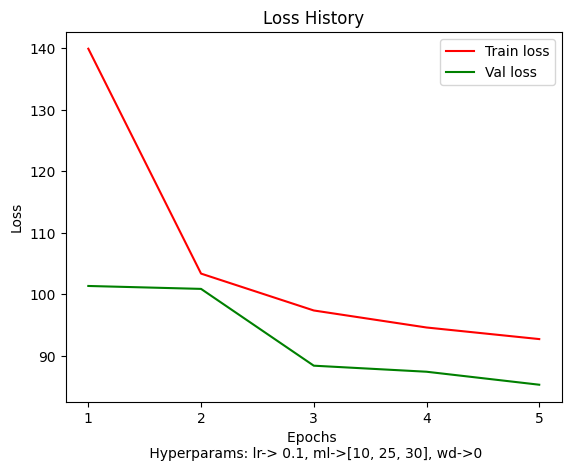

[Epoch: 6, Iteration:     1]  training loss: 89.739
[Epoch: 6, Iteration:   201]  training loss: 91.846
[Epoch: 6, Iteration:   401]  training loss: 95.131
[Epoch: 6, Iteration:   601]  training loss: 88.486
[Epoch: 6, Iteration:     1]  validation loss: 87.426
[Epoch: 7, Iteration:     1]  training loss: 89.657
[Epoch: 7, Iteration:   201]  training loss: 91.030
[Epoch: 7, Iteration:   401]  training loss: 90.192
[Epoch: 7, Iteration:   601]  training loss: 89.198
[Epoch: 7, Iteration:     1]  validation loss: 85.193
[Epoch: 8, Iteration:     1]  training loss: 90.361
[Epoch: 8, Iteration:   201]  training loss: 93.390
[Epoch: 8, Iteration:   401]  training loss: 87.951
[Epoch: 8, Iteration:   601]  training loss: 88.116
[Epoch: 8, Iteration:     1]  validation loss: 85.116
[Epoch: 9, Iteration:     1]  training loss: 88.379
[Epoch: 9, Iteration:   201]  training loss: 89.577
[Epoch: 9, Iteration:   401]  training loss: 89.008
[Epoch: 9, Iteration:   601]  training loss: 87.592
[Epoch

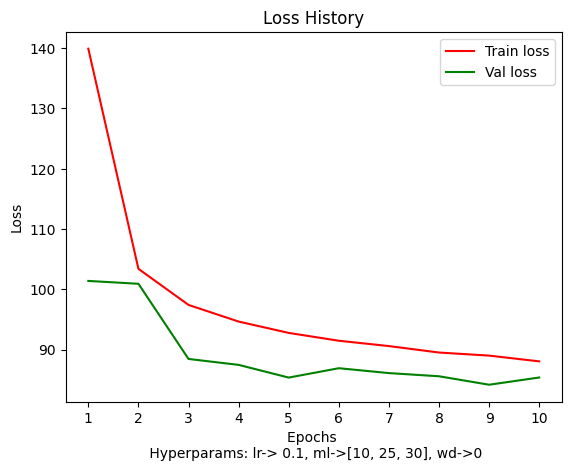

[Epoch: 11, Iteration:     1]  training loss: 87.115
[Epoch: 11, Iteration:   201]  training loss: 84.678
[Epoch: 11, Iteration:   401]  training loss: 88.678
[Epoch: 11, Iteration:   601]  training loss: 84.883
[Epoch: 11, Iteration:     1]  validation loss: 82.772
[Epoch: 12, Iteration:     1]  training loss: 85.698
[Epoch: 12, Iteration:   201]  training loss: 85.231
[Epoch: 12, Iteration:   401]  training loss: 84.360
[Epoch: 12, Iteration:   601]  training loss: 85.216
[Epoch: 12, Iteration:     1]  validation loss: 84.820
[Epoch: 13, Iteration:     1]  training loss: 83.586
[Epoch: 13, Iteration:   201]  training loss: 84.001
[Epoch: 13, Iteration:   401]  training loss: 82.923
[Epoch: 13, Iteration:   601]  training loss: 83.366
[Epoch: 13, Iteration:     1]  validation loss: 79.161
[Epoch: 14, Iteration:     1]  training loss: 86.145
[Epoch: 14, Iteration:   201]  training loss: 85.674
[Epoch: 14, Iteration:   401]  training loss: 87.104
[Epoch: 14, Iteration:   601]  training 

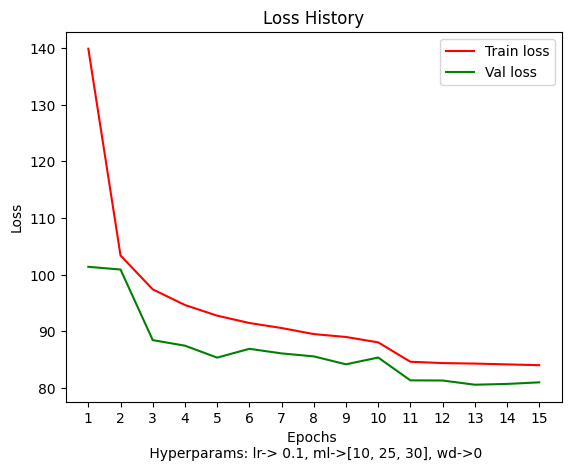

[Epoch: 16, Iteration:     1]  training loss: 84.704
[Epoch: 16, Iteration:   201]  training loss: 87.771
[Epoch: 16, Iteration:   401]  training loss: 89.119
[Epoch: 16, Iteration:   601]  training loss: 86.050
[Epoch: 16, Iteration:     1]  validation loss: 84.635
[Epoch: 17, Iteration:     1]  training loss: 83.746
[Epoch: 17, Iteration:   201]  training loss: 82.624
[Epoch: 17, Iteration:   401]  training loss: 84.163
[Epoch: 17, Iteration:   601]  training loss: 80.153
[Epoch: 17, Iteration:     1]  validation loss: 86.632
[Epoch: 18, Iteration:     1]  training loss: 82.195
[Epoch: 18, Iteration:   201]  training loss: 81.928
[Epoch: 18, Iteration:   401]  training loss: 82.038
[Epoch: 18, Iteration:   601]  training loss: 83.904
[Epoch: 18, Iteration:     1]  validation loss: 81.817
[Epoch: 19, Iteration:     1]  training loss: 87.049
[Epoch: 19, Iteration:   201]  training loss: 85.217
[Epoch: 19, Iteration:   401]  training loss: 85.505
[Epoch: 19, Iteration:   601]  training 

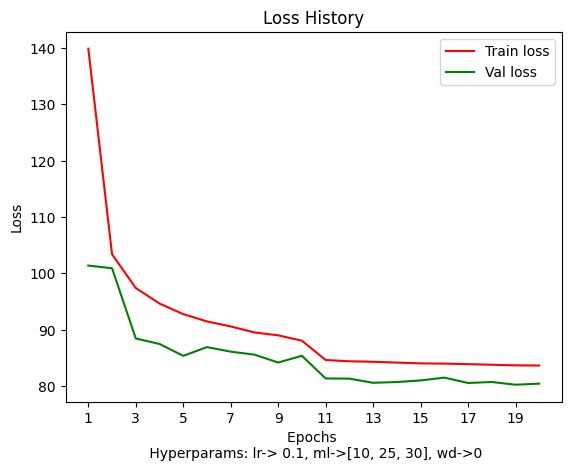

[Epoch: 21, Iteration:     1]  training loss: 84.626
[Epoch: 21, Iteration:   201]  training loss: 80.833
[Epoch: 21, Iteration:   401]  training loss: 84.716
[Epoch: 21, Iteration:   601]  training loss: 89.186
[Epoch: 21, Iteration:     1]  validation loss: 79.175
[Epoch: 22, Iteration:     1]  training loss: 85.366
[Epoch: 22, Iteration:   201]  training loss: 79.770
[Epoch: 22, Iteration:   401]  training loss: 84.703
[Epoch: 22, Iteration:   601]  training loss: 85.965
[Epoch: 22, Iteration:     1]  validation loss: 79.779
[Epoch: 23, Iteration:     1]  training loss: 84.684
[Epoch: 23, Iteration:   201]  training loss: 88.009
[Epoch: 23, Iteration:   401]  training loss: 84.826
[Epoch: 23, Iteration:   601]  training loss: 86.687
[Epoch: 23, Iteration:     1]  validation loss: 79.075
[Epoch: 24, Iteration:     1]  training loss: 83.153
[Epoch: 24, Iteration:   201]  training loss: 86.150
[Epoch: 24, Iteration:   401]  training loss: 80.788
[Epoch: 24, Iteration:   601]  training 

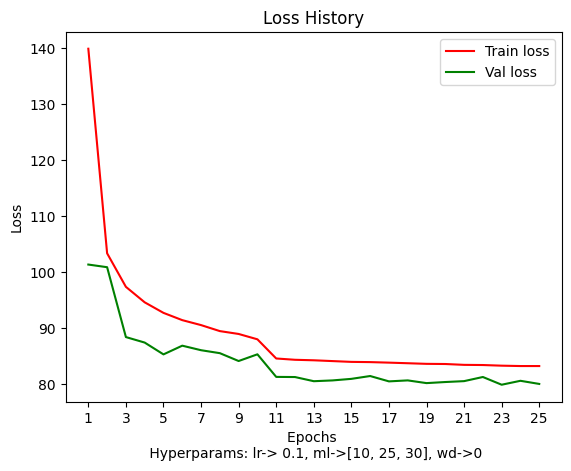

[Epoch: 26, Iteration:     1]  training loss: 78.084
[Epoch: 26, Iteration:   201]  training loss: 86.582
[Epoch: 26, Iteration:   401]  training loss: 77.159
[Epoch: 26, Iteration:   601]  training loss: 83.564
[Epoch: 26, Iteration:     1]  validation loss: 83.946
[Epoch: 27, Iteration:     1]  training loss: 86.133
[Epoch: 27, Iteration:   201]  training loss: 85.001
[Epoch: 27, Iteration:   401]  training loss: 82.935
[Epoch: 27, Iteration:   601]  training loss: 81.358
[Epoch: 27, Iteration:     1]  validation loss: 81.326
[Epoch: 28, Iteration:     1]  training loss: 84.007
[Epoch: 28, Iteration:   201]  training loss: 83.136
[Epoch: 28, Iteration:   401]  training loss: 80.504
[Epoch: 28, Iteration:   601]  training loss: 83.476
[Epoch: 28, Iteration:     1]  validation loss: 80.127
[Epoch: 29, Iteration:     1]  training loss: 85.197
[Epoch: 29, Iteration:   201]  training loss: 81.238
[Epoch: 29, Iteration:   401]  training loss: 79.448
[Epoch: 29, Iteration:   601]  training 

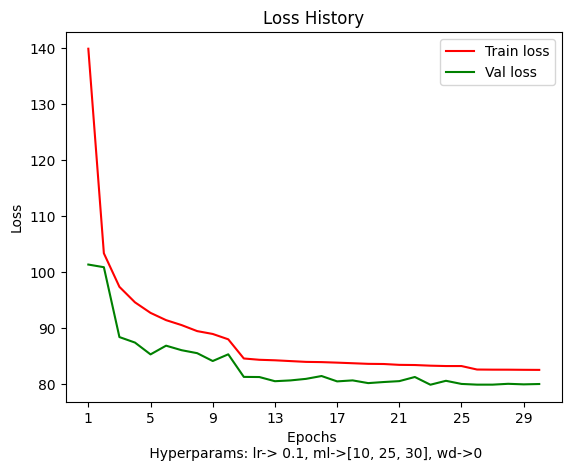

[Epoch: 31, Iteration:     1]  training loss: 80.925
[Epoch: 31, Iteration:   201]  training loss: 81.809
[Epoch: 31, Iteration:   401]  training loss: 79.090
[Epoch: 31, Iteration:   601]  training loss: 86.711
[Epoch: 31, Iteration:     1]  validation loss: 82.978
[Epoch: 32, Iteration:     1]  training loss: 83.737
[Epoch: 32, Iteration:   201]  training loss: 81.241
[Epoch: 32, Iteration:   401]  training loss: 81.442
[Epoch: 32, Iteration:   601]  training loss: 82.297
[Epoch: 32, Iteration:     1]  validation loss: 81.348
[Epoch: 33, Iteration:     1]  training loss: 81.027
[Epoch: 33, Iteration:   201]  training loss: 80.645
[Epoch: 33, Iteration:   401]  training loss: 79.620
[Epoch: 33, Iteration:   601]  training loss: 83.878
[Epoch: 33, Iteration:     1]  validation loss: 84.528
[Epoch: 34, Iteration:     1]  training loss: 82.257
[Epoch: 34, Iteration:   201]  training loss: 86.008
[Epoch: 34, Iteration:   401]  training loss: 78.762
[Epoch: 34, Iteration:   601]  training 

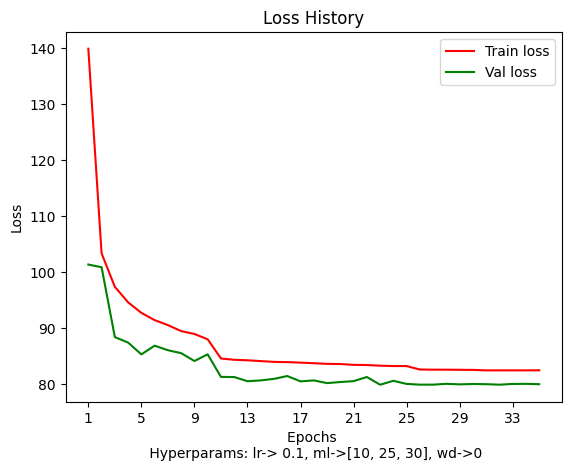

[Epoch: 36, Iteration:     1]  training loss: 77.893
[Epoch: 36, Iteration:   201]  training loss: 89.653
[Epoch: 36, Iteration:   401]  training loss: 88.654
[Epoch: 36, Iteration:   601]  training loss: 80.894
[Epoch: 36, Iteration:     1]  validation loss: 77.889
[Epoch: 37, Iteration:     1]  training loss: 81.171
[Epoch: 37, Iteration:   201]  training loss: 84.018
[Epoch: 37, Iteration:   401]  training loss: 78.616
[Epoch: 37, Iteration:   601]  training loss: 83.847
[Epoch: 37, Iteration:     1]  validation loss: 82.139
[Epoch: 38, Iteration:     1]  training loss: 86.307
[Epoch: 38, Iteration:   201]  training loss: 82.127
[Epoch: 38, Iteration:   401]  training loss: 80.519
[Epoch: 38, Iteration:   601]  training loss: 81.044
[Epoch: 38, Iteration:     1]  validation loss: 78.561
[Epoch: 39, Iteration:     1]  training loss: 81.025
[Epoch: 39, Iteration:   201]  training loss: 80.773
[Epoch: 39, Iteration:   401]  training loss: 85.001
[Epoch: 39, Iteration:   601]  training 

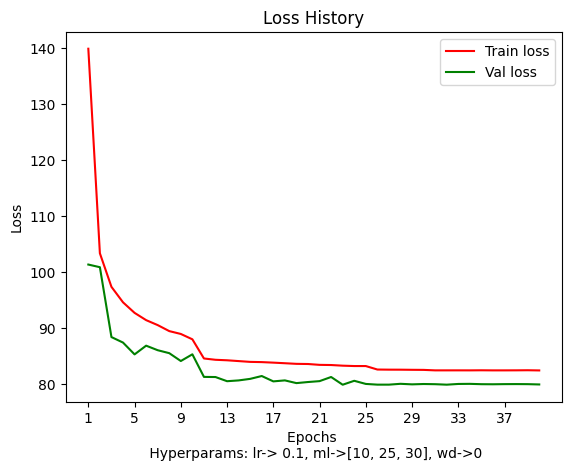

  6%|▌         | 1/18 [16:38<4:42:59, 998.80s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 565.745
[Epoch: 1, Iteration:   201]  training loss: 133.406
[Epoch: 1, Iteration:   401]  training loss: 120.664
[Epoch: 1, Iteration:   601]  training loss: 112.963
[Epoch: 1, Iteration:     1]  validation loss: 113.194
[Epoch: 2, Iteration:     1]  training loss: 109.617
[Epoch: 2, Iteration:   201]  training loss: 114.297
[Epoch: 2, Iteration:   401]  training loss: 111.724
[Epoch: 2, Iteration:   601]  training loss: 103.530
[Epoch: 2, Iteration:     1]  validation loss: 114.303
[Epoch: 3, Iteration:     1]  training loss: 102.837
[Epoch: 3, Iteration:   201]  training loss: 107.905
[Epoch: 3, Iteration:   401]  training loss: 104.415
[Epoch: 3, Iteration:   601]  training loss: 103.870
[Epoch: 3, Iteration:     1]  validation loss: 104.749
[Epoch: 4, Iteration:     1]  training loss: 102.113
[Epoch: 4, Iteration:   201]  training loss: 101.682
[Epoch: 4, Iteration:   401]  training lo

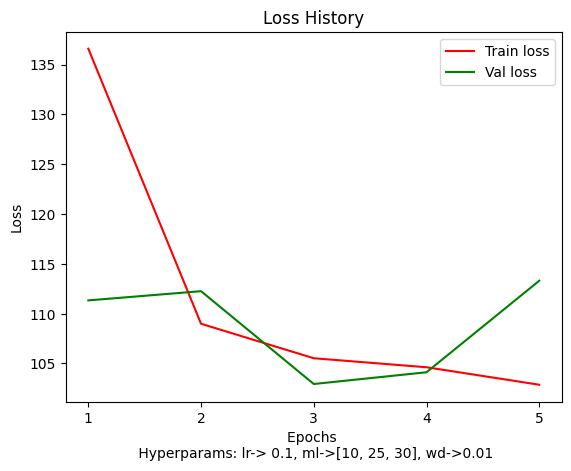

[Epoch: 6, Iteration:     1]  training loss: 101.573
[Epoch: 6, Iteration:   201]  training loss: 101.374
[Epoch: 6, Iteration:   401]  training loss: 103.932
[Epoch: 6, Iteration:   601]  training loss: 99.174
[Epoch: 6, Iteration:     1]  validation loss: 102.400
[Epoch: 7, Iteration:     1]  training loss: 102.279
[Epoch: 7, Iteration:   201]  training loss: 106.773
[Epoch: 7, Iteration:   401]  training loss: 102.152
[Epoch: 7, Iteration:   601]  training loss: 104.786
[Epoch: 7, Iteration:     1]  validation loss: 97.957
[Epoch: 8, Iteration:     1]  training loss: 93.853
[Epoch: 8, Iteration:   201]  training loss: 102.596
[Epoch: 8, Iteration:   401]  training loss: 98.779
[Epoch: 8, Iteration:   601]  training loss: 100.962
[Epoch: 8, Iteration:     1]  validation loss: 115.708
[Epoch: 9, Iteration:     1]  training loss: 103.502
[Epoch: 9, Iteration:   201]  training loss: 98.301
[Epoch: 9, Iteration:   401]  training loss: 97.940
[Epoch: 9, Iteration:   601]  training loss: 1

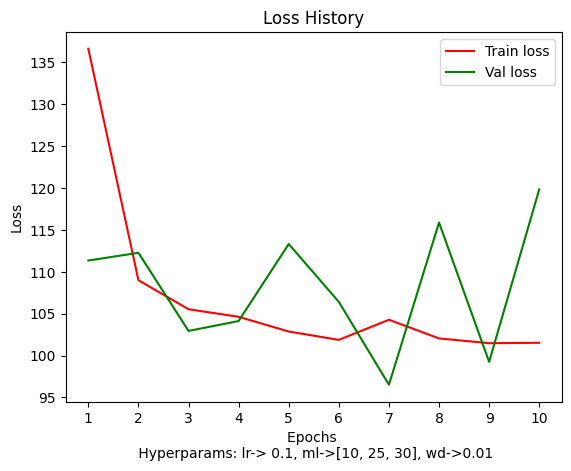

[Epoch: 11, Iteration:     1]  training loss: 111.400
[Epoch: 11, Iteration:   201]  training loss: 92.817
[Epoch: 11, Iteration:   401]  training loss: 87.602
[Epoch: 11, Iteration:   601]  training loss: 93.151
[Epoch: 11, Iteration:     1]  validation loss: 84.946
[Epoch: 12, Iteration:     1]  training loss: 91.406
[Epoch: 12, Iteration:   201]  training loss: 91.092
[Epoch: 12, Iteration:   401]  training loss: 97.756
[Epoch: 12, Iteration:   601]  training loss: 84.022
[Epoch: 12, Iteration:     1]  validation loss: 88.597
[Epoch: 13, Iteration:     1]  training loss: 99.698
[Epoch: 13, Iteration:   201]  training loss: 91.011
[Epoch: 13, Iteration:   401]  training loss: 87.706
[Epoch: 13, Iteration:   601]  training loss: 89.402
[Epoch: 13, Iteration:     1]  validation loss: 84.684
[Epoch: 14, Iteration:     1]  training loss: 93.688
[Epoch: 14, Iteration:   201]  training loss: 83.511
[Epoch: 14, Iteration:   401]  training loss: 91.911
[Epoch: 14, Iteration:   601]  training

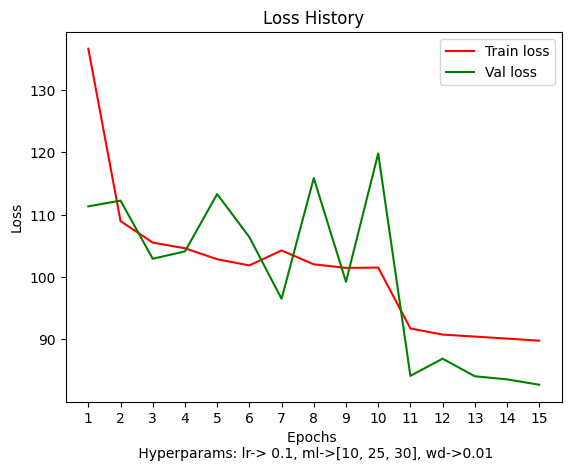

[Epoch: 16, Iteration:     1]  training loss: 88.722
[Epoch: 16, Iteration:   201]  training loss: 84.618
[Epoch: 16, Iteration:   401]  training loss: 94.903
[Epoch: 16, Iteration:   601]  training loss: 92.187
[Epoch: 16, Iteration:     1]  validation loss: 86.998
[Epoch: 17, Iteration:     1]  training loss: 94.232
[Epoch: 17, Iteration:   201]  training loss: 94.074
[Epoch: 17, Iteration:   401]  training loss: 89.527
[Epoch: 17, Iteration:   601]  training loss: 88.836
[Epoch: 17, Iteration:     1]  validation loss: 79.256
[Epoch: 18, Iteration:     1]  training loss: 84.341
[Epoch: 18, Iteration:   201]  training loss: 87.194
[Epoch: 18, Iteration:   401]  training loss: 94.867
[Epoch: 18, Iteration:   601]  training loss: 87.134
[Epoch: 18, Iteration:     1]  validation loss: 84.037
[Epoch: 19, Iteration:     1]  training loss: 88.314
[Epoch: 19, Iteration:   201]  training loss: 89.921
[Epoch: 19, Iteration:   401]  training loss: 94.824
[Epoch: 19, Iteration:   601]  training 

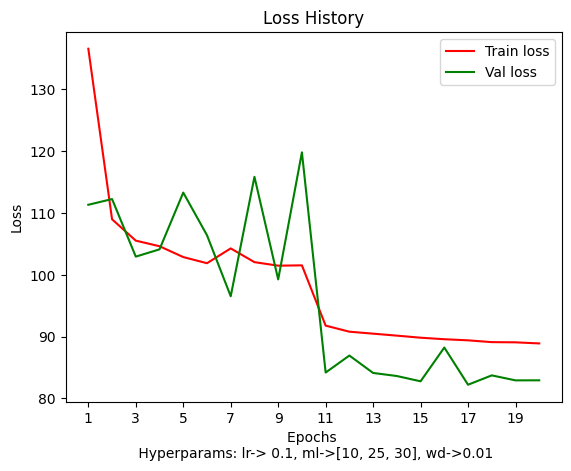

[Epoch: 21, Iteration:     1]  training loss: 90.516
[Epoch: 21, Iteration:   201]  training loss: 88.850
[Epoch: 21, Iteration:   401]  training loss: 90.368
[Epoch: 21, Iteration:   601]  training loss: 89.331
[Epoch: 21, Iteration:     1]  validation loss: 87.623
[Epoch: 22, Iteration:     1]  training loss: 88.768
[Epoch: 22, Iteration:   201]  training loss: 83.796
[Epoch: 22, Iteration:   401]  training loss: 94.387
[Epoch: 22, Iteration:   601]  training loss: 89.169
[Epoch: 22, Iteration:     1]  validation loss: 81.255
[Epoch: 23, Iteration:     1]  training loss: 91.058
[Epoch: 23, Iteration:   201]  training loss: 88.427
[Epoch: 23, Iteration:   401]  training loss: 87.676
[Epoch: 23, Iteration:   601]  training loss: 83.170
[Epoch: 23, Iteration:     1]  validation loss: 90.653
[Epoch: 24, Iteration:     1]  training loss: 87.793
[Epoch: 24, Iteration:   201]  training loss: 87.092
[Epoch: 24, Iteration:   401]  training loss: 87.087
[Epoch: 24, Iteration:   601]  training 

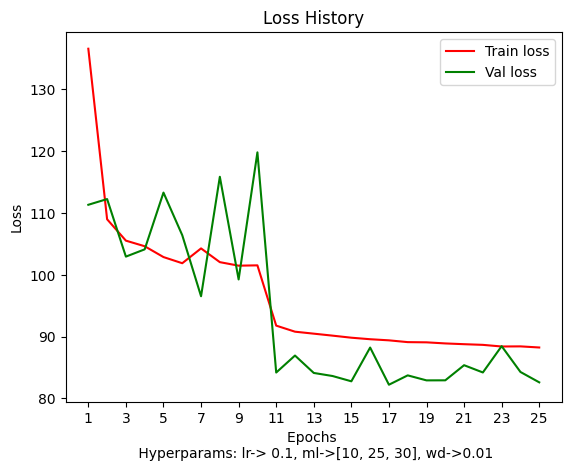

[Epoch: 26, Iteration:     1]  training loss: 85.924
[Epoch: 26, Iteration:   201]  training loss: 88.087
[Epoch: 26, Iteration:   401]  training loss: 83.209
[Epoch: 26, Iteration:   601]  training loss: 83.568
[Epoch: 26, Iteration:     1]  validation loss: 79.820
[Epoch: 27, Iteration:     1]  training loss: 81.151
[Epoch: 27, Iteration:   201]  training loss: 83.598
[Epoch: 27, Iteration:   401]  training loss: 86.052
[Epoch: 27, Iteration:   601]  training loss: 87.328
[Epoch: 27, Iteration:     1]  validation loss: 80.300
[Epoch: 28, Iteration:     1]  training loss: 84.728
[Epoch: 28, Iteration:   201]  training loss: 86.425
[Epoch: 28, Iteration:   401]  training loss: 83.120
[Epoch: 28, Iteration:   601]  training loss: 83.566
[Epoch: 28, Iteration:     1]  validation loss: 79.110
[Epoch: 29, Iteration:     1]  training loss: 82.597
[Epoch: 29, Iteration:   201]  training loss: 78.979
[Epoch: 29, Iteration:   401]  training loss: 79.601
[Epoch: 29, Iteration:   601]  training 

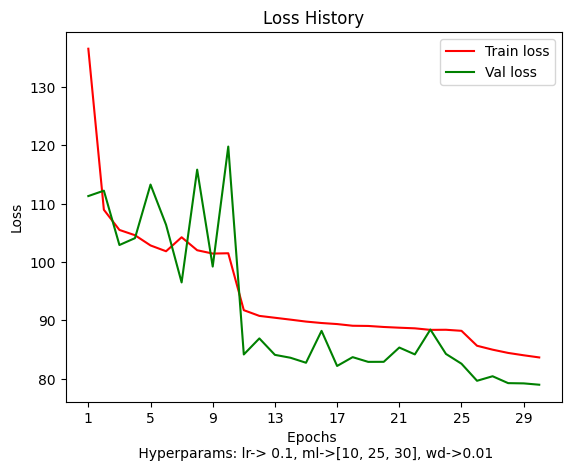

[Epoch: 31, Iteration:     1]  training loss: 85.914
[Epoch: 31, Iteration:   201]  training loss: 80.085
[Epoch: 31, Iteration:   401]  training loss: 84.482
[Epoch: 31, Iteration:   601]  training loss: 84.352
[Epoch: 31, Iteration:     1]  validation loss: 79.884
[Epoch: 32, Iteration:     1]  training loss: 80.415
[Epoch: 32, Iteration:   201]  training loss: 82.062
[Epoch: 32, Iteration:   401]  training loss: 82.379
[Epoch: 32, Iteration:   601]  training loss: 84.906
[Epoch: 32, Iteration:     1]  validation loss: 80.458
[Epoch: 33, Iteration:     1]  training loss: 79.317
[Epoch: 33, Iteration:   201]  training loss: 80.941
[Epoch: 33, Iteration:   401]  training loss: 78.785
[Epoch: 33, Iteration:   601]  training loss: 76.463
[Epoch: 33, Iteration:     1]  validation loss: 79.245
[Epoch: 34, Iteration:     1]  training loss: 83.525
[Epoch: 34, Iteration:   201]  training loss: 81.103
[Epoch: 34, Iteration:   401]  training loss: 79.148
[Epoch: 34, Iteration:   601]  training 

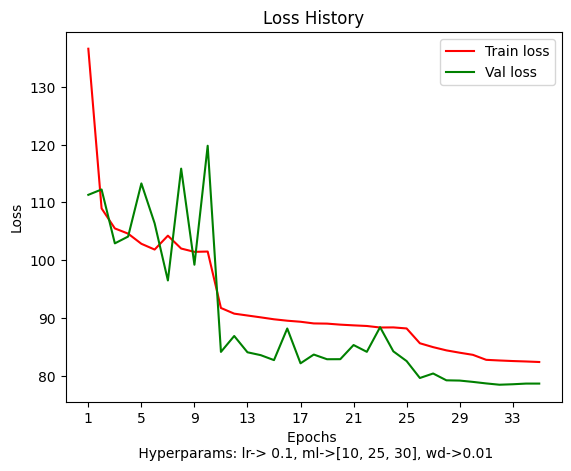

[Epoch: 36, Iteration:     1]  training loss: 82.494
[Epoch: 36, Iteration:   201]  training loss: 77.499
[Epoch: 36, Iteration:   401]  training loss: 84.493
[Epoch: 36, Iteration:   601]  training loss: 78.841
[Epoch: 36, Iteration:     1]  validation loss: 78.775
[Epoch: 37, Iteration:     1]  training loss: 75.584
[Epoch: 37, Iteration:   201]  training loss: 86.315
[Epoch: 37, Iteration:   401]  training loss: 83.522
[Epoch: 37, Iteration:   601]  training loss: 82.796
[Epoch: 37, Iteration:     1]  validation loss: 78.188
[Epoch: 38, Iteration:     1]  training loss: 79.396
[Epoch: 38, Iteration:   201]  training loss: 83.660
[Epoch: 38, Iteration:   401]  training loss: 79.151
[Epoch: 38, Iteration:   601]  training loss: 91.564
[Epoch: 38, Iteration:     1]  validation loss: 83.681
[Epoch: 39, Iteration:     1]  training loss: 78.104
[Epoch: 39, Iteration:   201]  training loss: 80.661
[Epoch: 39, Iteration:   401]  training loss: 83.692
[Epoch: 39, Iteration:   601]  training 

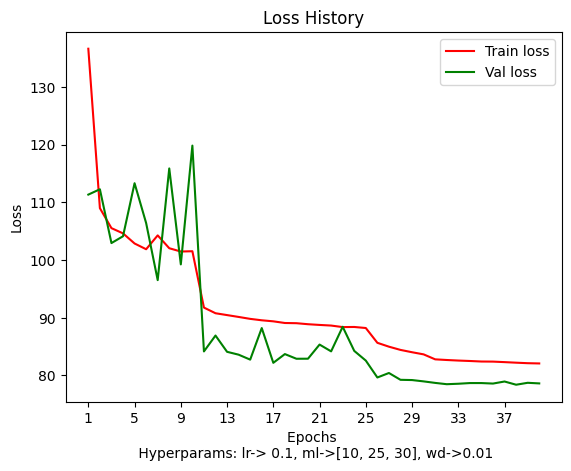

 11%|█         | 2/18 [32:29<4:18:46, 970.41s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 565.437
[Epoch: 1, Iteration:   201]  training loss: 126.894
[Epoch: 1, Iteration:   401]  training loss: 120.566
[Epoch: 1, Iteration:   601]  training loss: 117.079
[Epoch: 1, Iteration:     1]  validation loss: 93.228
[Epoch: 2, Iteration:     1]  training loss: 106.518
[Epoch: 2, Iteration:   201]  training loss: 100.585
[Epoch: 2, Iteration:   401]  training loss: 98.676
[Epoch: 2, Iteration:   601]  training loss: 96.456
[Epoch: 2, Iteration:     1]  validation loss: 96.644
[Epoch: 3, Iteration:     1]  training loss: 92.032
[Epoch: 3, Iteration:   201]  training loss: 92.526
[Epoch: 3, Iteration:   401]  training loss: 93.824
[Epoch: 3, Iteration:   601]  training loss: 100.396
[Epoch: 3, Iteration:     1]  validation loss: 93.787
[Epoch: 4, Iteration:     1]  training loss: 92.265
[Epoch: 4, Iteration:   201]  training loss: 93.158
[Epoch: 4, Iteration:   401]  training loss: 99.667

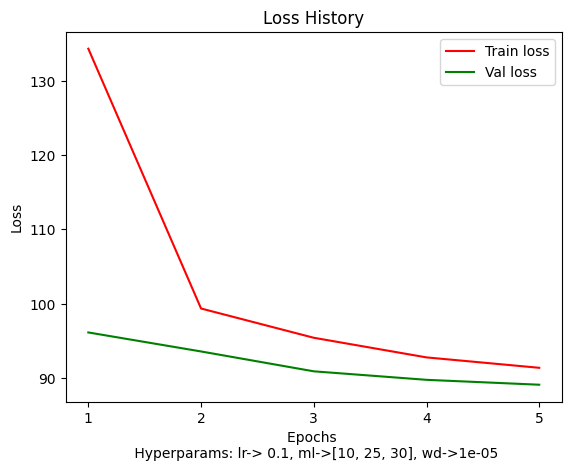

[Epoch: 6, Iteration:     1]  training loss: 87.743
[Epoch: 6, Iteration:   201]  training loss: 93.686
[Epoch: 6, Iteration:   401]  training loss: 92.107
[Epoch: 6, Iteration:   601]  training loss: 91.627
[Epoch: 6, Iteration:     1]  validation loss: 83.580
[Epoch: 7, Iteration:     1]  training loss: 87.262
[Epoch: 7, Iteration:   201]  training loss: 90.726
[Epoch: 7, Iteration:   401]  training loss: 91.591
[Epoch: 7, Iteration:   601]  training loss: 86.917
[Epoch: 7, Iteration:     1]  validation loss: 85.505
[Epoch: 8, Iteration:     1]  training loss: 86.617
[Epoch: 8, Iteration:   201]  training loss: 88.644
[Epoch: 8, Iteration:   401]  training loss: 90.823
[Epoch: 8, Iteration:   601]  training loss: 85.479
[Epoch: 8, Iteration:     1]  validation loss: 89.463
[Epoch: 9, Iteration:     1]  training loss: 87.658
[Epoch: 9, Iteration:   201]  training loss: 88.155
[Epoch: 9, Iteration:   401]  training loss: 89.569
[Epoch: 9, Iteration:   601]  training loss: 93.669
[Epoch

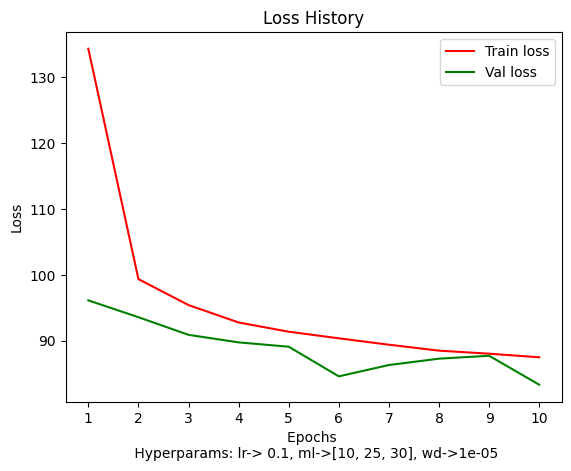

[Epoch: 11, Iteration:     1]  training loss: 83.398
[Epoch: 11, Iteration:   201]  training loss: 86.779
[Epoch: 11, Iteration:   401]  training loss: 86.803
[Epoch: 11, Iteration:   601]  training loss: 85.227
[Epoch: 11, Iteration:     1]  validation loss: 79.791
[Epoch: 12, Iteration:     1]  training loss: 85.855
[Epoch: 12, Iteration:   201]  training loss: 83.609
[Epoch: 12, Iteration:   401]  training loss: 80.557
[Epoch: 12, Iteration:   601]  training loss: 78.642
[Epoch: 12, Iteration:     1]  validation loss: 77.577
[Epoch: 13, Iteration:     1]  training loss: 89.602
[Epoch: 13, Iteration:   201]  training loss: 78.962
[Epoch: 13, Iteration:   401]  training loss: 81.665
[Epoch: 13, Iteration:   601]  training loss: 79.594
[Epoch: 13, Iteration:     1]  validation loss: 83.415
[Epoch: 14, Iteration:     1]  training loss: 80.411
[Epoch: 14, Iteration:   201]  training loss: 85.275
[Epoch: 14, Iteration:   401]  training loss: 80.368
[Epoch: 14, Iteration:   601]  training 

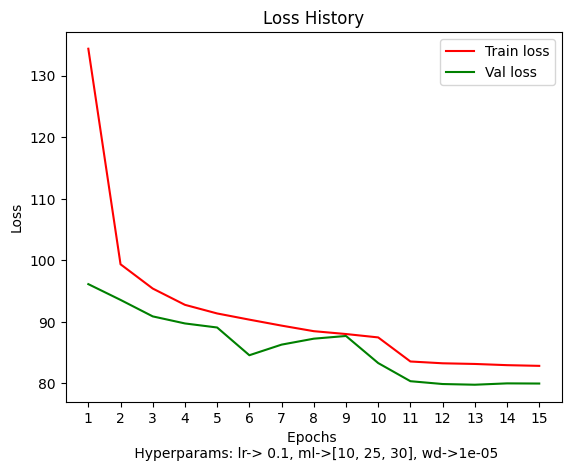

[Epoch: 16, Iteration:     1]  training loss: 84.712
[Epoch: 16, Iteration:   201]  training loss: 82.601
[Epoch: 16, Iteration:   401]  training loss: 83.590
[Epoch: 16, Iteration:   601]  training loss: 79.795
[Epoch: 16, Iteration:     1]  validation loss: 79.620
[Epoch: 17, Iteration:     1]  training loss: 83.262
[Epoch: 17, Iteration:   201]  training loss: 88.902
[Epoch: 17, Iteration:   401]  training loss: 74.036
[Epoch: 17, Iteration:   601]  training loss: 80.333
[Epoch: 17, Iteration:     1]  validation loss: 77.758
[Epoch: 18, Iteration:     1]  training loss: 81.737
[Epoch: 18, Iteration:   201]  training loss: 87.059
[Epoch: 18, Iteration:   401]  training loss: 80.532
[Epoch: 18, Iteration:   601]  training loss: 86.271
[Epoch: 18, Iteration:     1]  validation loss: 79.020
[Epoch: 19, Iteration:     1]  training loss: 80.005
[Epoch: 19, Iteration:   201]  training loss: 82.903
[Epoch: 19, Iteration:   401]  training loss: 83.805
[Epoch: 19, Iteration:   601]  training 

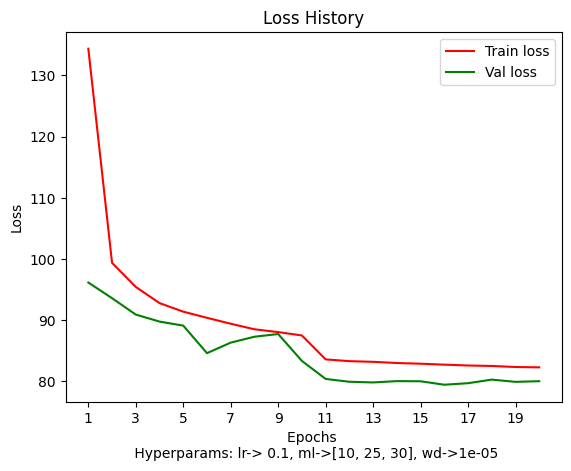

[Epoch: 21, Iteration:     1]  training loss: 81.382
[Epoch: 21, Iteration:   201]  training loss: 78.996
[Epoch: 21, Iteration:   401]  training loss: 80.000
[Epoch: 21, Iteration:   601]  training loss: 79.084
[Epoch: 21, Iteration:     1]  validation loss: 77.352
[Epoch: 22, Iteration:     1]  training loss: 81.728
[Epoch: 22, Iteration:   201]  training loss: 79.405
[Epoch: 22, Iteration:   401]  training loss: 85.686
[Epoch: 22, Iteration:   601]  training loss: 78.707
[Epoch: 22, Iteration:     1]  validation loss: 81.088
[Epoch: 23, Iteration:     1]  training loss: 80.777
[Epoch: 23, Iteration:   201]  training loss: 85.878
[Epoch: 23, Iteration:   401]  training loss: 80.606
[Epoch: 23, Iteration:   601]  training loss: 81.612
[Epoch: 23, Iteration:     1]  validation loss: 76.764
[Epoch: 24, Iteration:     1]  training loss: 80.521
[Epoch: 24, Iteration:   201]  training loss: 82.663
[Epoch: 24, Iteration:   401]  training loss: 82.462
[Epoch: 24, Iteration:   601]  training 

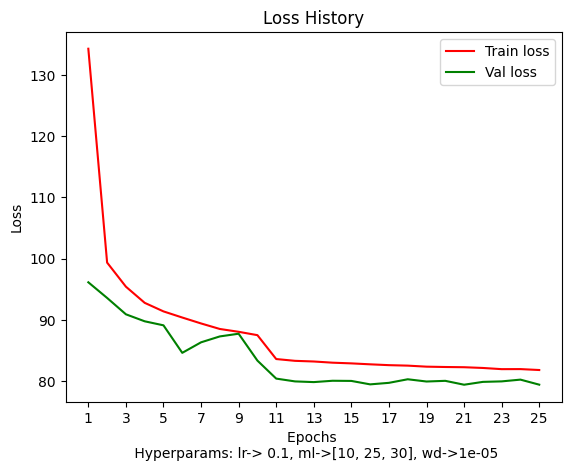

[Epoch: 26, Iteration:     1]  training loss: 79.364
[Epoch: 26, Iteration:   201]  training loss: 75.655
[Epoch: 26, Iteration:   401]  training loss: 80.449
[Epoch: 26, Iteration:   601]  training loss: 78.386
[Epoch: 26, Iteration:     1]  validation loss: 71.576
[Epoch: 27, Iteration:     1]  training loss: 84.282
[Epoch: 27, Iteration:   201]  training loss: 85.263
[Epoch: 27, Iteration:   401]  training loss: 80.049
[Epoch: 27, Iteration:   601]  training loss: 83.981
[Epoch: 27, Iteration:     1]  validation loss: 79.746
[Epoch: 28, Iteration:     1]  training loss: 79.158
[Epoch: 28, Iteration:   201]  training loss: 81.938
[Epoch: 28, Iteration:   401]  training loss: 80.625
[Epoch: 28, Iteration:   601]  training loss: 81.735
[Epoch: 28, Iteration:     1]  validation loss: 78.983
[Epoch: 29, Iteration:     1]  training loss: 75.565
[Epoch: 29, Iteration:   201]  training loss: 82.139
[Epoch: 29, Iteration:   401]  training loss: 78.116
[Epoch: 29, Iteration:   601]  training 

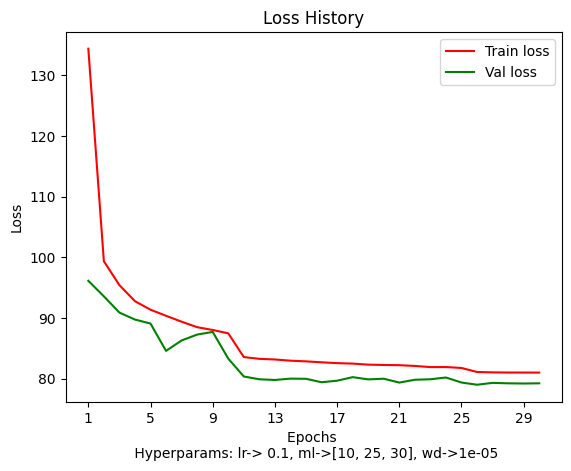

[Epoch: 31, Iteration:     1]  training loss: 80.176
[Epoch: 31, Iteration:   201]  training loss: 86.128
[Epoch: 31, Iteration:   401]  training loss: 78.623
[Epoch: 31, Iteration:   601]  training loss: 85.511
[Epoch: 31, Iteration:     1]  validation loss: 80.935
[Epoch: 32, Iteration:     1]  training loss: 80.029
[Epoch: 32, Iteration:   201]  training loss: 80.584
[Epoch: 32, Iteration:   401]  training loss: 84.195
[Epoch: 32, Iteration:   601]  training loss: 82.444
[Epoch: 32, Iteration:     1]  validation loss: 77.240
[Epoch: 33, Iteration:     1]  training loss: 79.318
[Epoch: 33, Iteration:   201]  training loss: 83.077
[Epoch: 33, Iteration:   401]  training loss: 82.817
[Epoch: 33, Iteration:   601]  training loss: 79.288
[Epoch: 33, Iteration:     1]  validation loss: 78.953
[Epoch: 34, Iteration:     1]  training loss: 82.797
[Epoch: 34, Iteration:   201]  training loss: 77.834
[Epoch: 34, Iteration:   401]  training loss: 85.289
[Epoch: 34, Iteration:   601]  training 

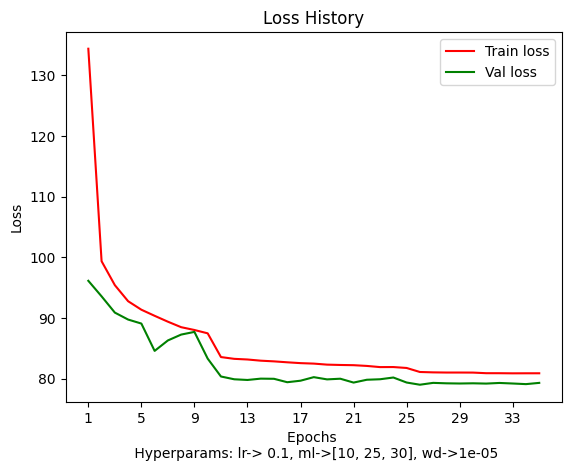

[Epoch: 36, Iteration:     1]  training loss: 81.917
[Epoch: 36, Iteration:   201]  training loss: 78.554
[Epoch: 36, Iteration:   401]  training loss: 84.823
[Epoch: 36, Iteration:   601]  training loss: 79.225
[Epoch: 36, Iteration:     1]  validation loss: 74.049
[Epoch: 37, Iteration:     1]  training loss: 82.500
[Epoch: 37, Iteration:   201]  training loss: 82.760
[Epoch: 37, Iteration:   401]  training loss: 76.368
[Epoch: 37, Iteration:   601]  training loss: 81.347
[Epoch: 37, Iteration:     1]  validation loss: 77.677
[Epoch: 38, Iteration:     1]  training loss: 78.275
[Epoch: 38, Iteration:   201]  training loss: 81.890
[Epoch: 38, Iteration:   401]  training loss: 81.111
[Epoch: 38, Iteration:   601]  training loss: 79.355
[Epoch: 38, Iteration:     1]  validation loss: 74.398
[Epoch: 39, Iteration:     1]  training loss: 78.292
[Epoch: 39, Iteration:   201]  training loss: 80.214
[Epoch: 39, Iteration:   401]  training loss: 78.815
[Epoch: 39, Iteration:   601]  training 

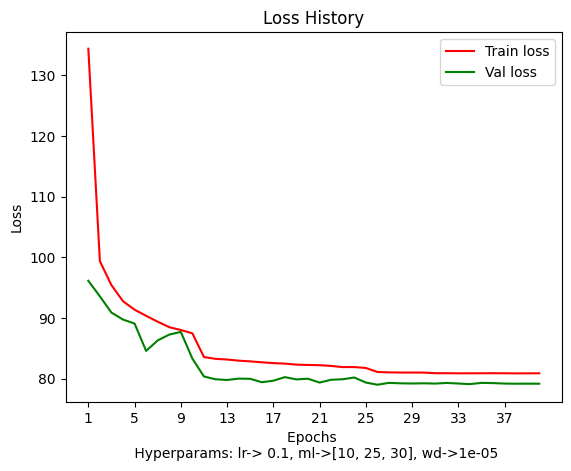

 17%|█▋        | 3/18 [48:45<4:03:14, 972.97s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 563.523
[Epoch: 1, Iteration:   201]  training loss: 137.916
[Epoch: 1, Iteration:   401]  training loss: 122.088
[Epoch: 1, Iteration:   601]  training loss: 110.366
[Epoch: 1, Iteration:     1]  validation loss: 104.878
[Epoch: 2, Iteration:     1]  training loss: 103.800
[Epoch: 2, Iteration:   201]  training loss: 107.098
[Epoch: 2, Iteration:   401]  training loss: 99.344
[Epoch: 2, Iteration:   601]  training loss: 94.639
[Epoch: 2, Iteration:     1]  validation loss: 91.180
[Epoch: 3, Iteration:     1]  training loss: 97.833
[Epoch: 3, Iteration:   201]  training loss: 97.886
[Epoch: 3, Iteration:   401]  training loss: 99.952
[Epoch: 3, Iteration:   601]  training loss: 98.759
[Epoch: 3, Iteration:     1]  validation loss: 84.739
[Epoch: 4, Iteration:     1]  training loss: 91.105
[Epoch: 4, Iteration:   201]  training loss: 93.845
[Epoch: 4, Iteration:   401]  training loss: 93.638

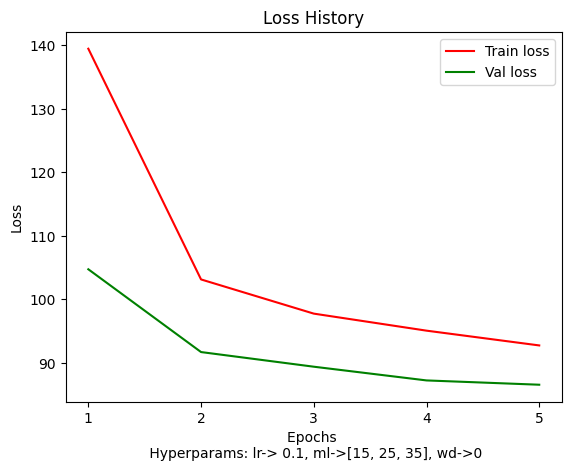

[Epoch: 6, Iteration:     1]  training loss: 89.543
[Epoch: 6, Iteration:   201]  training loss: 86.492
[Epoch: 6, Iteration:   401]  training loss: 91.296
[Epoch: 6, Iteration:   601]  training loss: 90.727
[Epoch: 6, Iteration:     1]  validation loss: 86.461
[Epoch: 7, Iteration:     1]  training loss: 97.094
[Epoch: 7, Iteration:   201]  training loss: 84.686
[Epoch: 7, Iteration:   401]  training loss: 89.965
[Epoch: 7, Iteration:   601]  training loss: 90.534
[Epoch: 7, Iteration:     1]  validation loss: 90.834
[Epoch: 8, Iteration:     1]  training loss: 90.770
[Epoch: 8, Iteration:   201]  training loss: 88.439
[Epoch: 8, Iteration:   401]  training loss: 88.070
[Epoch: 8, Iteration:   601]  training loss: 84.200
[Epoch: 8, Iteration:     1]  validation loss: 84.442
[Epoch: 9, Iteration:     1]  training loss: 85.976
[Epoch: 9, Iteration:   201]  training loss: 89.665
[Epoch: 9, Iteration:   401]  training loss: 87.386
[Epoch: 9, Iteration:   601]  training loss: 87.932
[Epoch

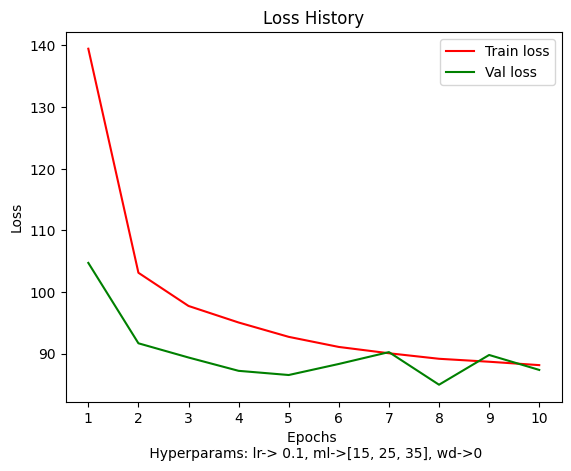

[Epoch: 11, Iteration:     1]  training loss: 90.372
[Epoch: 11, Iteration:   201]  training loss: 90.897
[Epoch: 11, Iteration:   401]  training loss: 83.895
[Epoch: 11, Iteration:   601]  training loss: 87.119
[Epoch: 11, Iteration:     1]  validation loss: 88.124
[Epoch: 12, Iteration:     1]  training loss: 88.300
[Epoch: 12, Iteration:   201]  training loss: 89.379
[Epoch: 12, Iteration:   401]  training loss: 86.671
[Epoch: 12, Iteration:   601]  training loss: 81.595
[Epoch: 12, Iteration:     1]  validation loss: 84.437
[Epoch: 13, Iteration:     1]  training loss: 87.802
[Epoch: 13, Iteration:   201]  training loss: 83.539
[Epoch: 13, Iteration:   401]  training loss: 84.240
[Epoch: 13, Iteration:   601]  training loss: 86.582
[Epoch: 13, Iteration:     1]  validation loss: 90.730
[Epoch: 14, Iteration:     1]  training loss: 91.192
[Epoch: 14, Iteration:   201]  training loss: 86.872
[Epoch: 14, Iteration:   401]  training loss: 85.983
[Epoch: 14, Iteration:   601]  training 

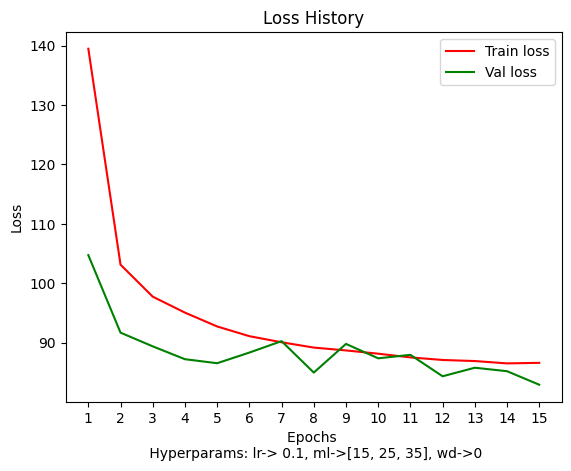

[Epoch: 16, Iteration:     1]  training loss: 84.771
[Epoch: 16, Iteration:   201]  training loss: 82.730
[Epoch: 16, Iteration:   401]  training loss: 83.014
[Epoch: 16, Iteration:   601]  training loss: 83.261
[Epoch: 16, Iteration:     1]  validation loss: 82.394
[Epoch: 17, Iteration:     1]  training loss: 79.219
[Epoch: 17, Iteration:   201]  training loss: 81.642
[Epoch: 17, Iteration:   401]  training loss: 83.580
[Epoch: 17, Iteration:   601]  training loss: 85.139
[Epoch: 17, Iteration:     1]  validation loss: 84.091
[Epoch: 18, Iteration:     1]  training loss: 85.629
[Epoch: 18, Iteration:   201]  training loss: 82.345
[Epoch: 18, Iteration:   401]  training loss: 94.388
[Epoch: 18, Iteration:   601]  training loss: 86.187
[Epoch: 18, Iteration:     1]  validation loss: 78.974
[Epoch: 19, Iteration:     1]  training loss: 81.857
[Epoch: 19, Iteration:   201]  training loss: 80.021
[Epoch: 19, Iteration:   401]  training loss: 82.144
[Epoch: 19, Iteration:   601]  training 

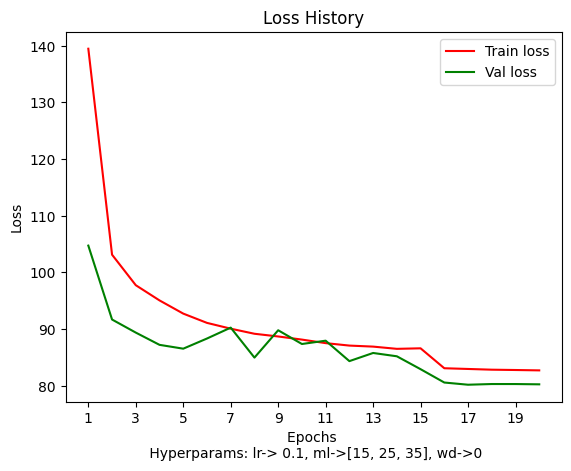

[Epoch: 21, Iteration:     1]  training loss: 84.697
[Epoch: 21, Iteration:   201]  training loss: 83.249
[Epoch: 21, Iteration:   401]  training loss: 82.890
[Epoch: 21, Iteration:   601]  training loss: 84.450
[Epoch: 21, Iteration:     1]  validation loss: 76.696
[Epoch: 22, Iteration:     1]  training loss: 84.042
[Epoch: 22, Iteration:   201]  training loss: 84.668
[Epoch: 22, Iteration:   401]  training loss: 77.662
[Epoch: 22, Iteration:   601]  training loss: 78.692
[Epoch: 22, Iteration:     1]  validation loss: 85.114
[Epoch: 23, Iteration:     1]  training loss: 81.953
[Epoch: 23, Iteration:   201]  training loss: 82.206
[Epoch: 23, Iteration:   401]  training loss: 84.007
[Epoch: 23, Iteration:   601]  training loss: 83.965
[Epoch: 23, Iteration:     1]  validation loss: 78.283
[Epoch: 24, Iteration:     1]  training loss: 81.784
[Epoch: 24, Iteration:   201]  training loss: 77.400
[Epoch: 24, Iteration:   401]  training loss: 84.312
[Epoch: 24, Iteration:   601]  training 

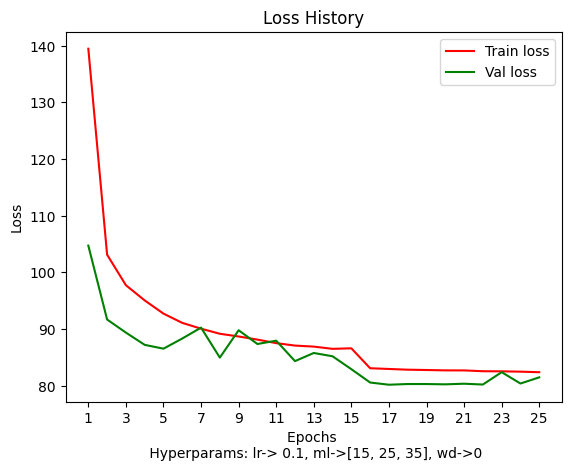

[Epoch: 26, Iteration:     1]  training loss: 82.357
[Epoch: 26, Iteration:   201]  training loss: 81.430
[Epoch: 26, Iteration:   401]  training loss: 82.063
[Epoch: 26, Iteration:   601]  training loss: 83.285
[Epoch: 26, Iteration:     1]  validation loss: 79.971
[Epoch: 27, Iteration:     1]  training loss: 85.433
[Epoch: 27, Iteration:   201]  training loss: 80.363
[Epoch: 27, Iteration:   401]  training loss: 85.354
[Epoch: 27, Iteration:   601]  training loss: 85.062
[Epoch: 27, Iteration:     1]  validation loss: 84.430
[Epoch: 28, Iteration:     1]  training loss: 84.167
[Epoch: 28, Iteration:   201]  training loss: 77.611
[Epoch: 28, Iteration:   401]  training loss: 78.998
[Epoch: 28, Iteration:   601]  training loss: 78.440
[Epoch: 28, Iteration:     1]  validation loss: 79.678
[Epoch: 29, Iteration:     1]  training loss: 77.008
[Epoch: 29, Iteration:   201]  training loss: 79.396
[Epoch: 29, Iteration:   401]  training loss: 78.237
[Epoch: 29, Iteration:   601]  training 

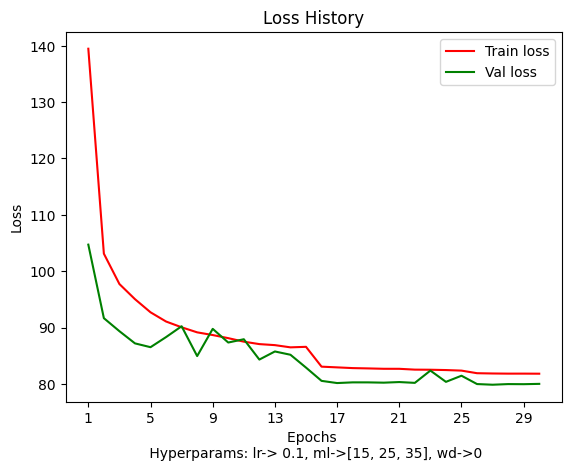

[Epoch: 31, Iteration:     1]  training loss: 82.077
[Epoch: 31, Iteration:   201]  training loss: 83.182
[Epoch: 31, Iteration:   401]  training loss: 86.848
[Epoch: 31, Iteration:   601]  training loss: 85.164
[Epoch: 31, Iteration:     1]  validation loss: 78.435
[Epoch: 32, Iteration:     1]  training loss: 80.976
[Epoch: 32, Iteration:   201]  training loss: 79.521
[Epoch: 32, Iteration:   401]  training loss: 81.864
[Epoch: 32, Iteration:   601]  training loss: 83.985
[Epoch: 32, Iteration:     1]  validation loss: 79.673
[Epoch: 33, Iteration:     1]  training loss: 81.634
[Epoch: 33, Iteration:   201]  training loss: 84.659
[Epoch: 33, Iteration:   401]  training loss: 76.750
[Epoch: 33, Iteration:   601]  training loss: 76.634
[Epoch: 33, Iteration:     1]  validation loss: 79.528
[Epoch: 34, Iteration:     1]  training loss: 80.391
[Epoch: 34, Iteration:   201]  training loss: 83.829
[Epoch: 34, Iteration:   401]  training loss: 85.204
[Epoch: 34, Iteration:   601]  training 

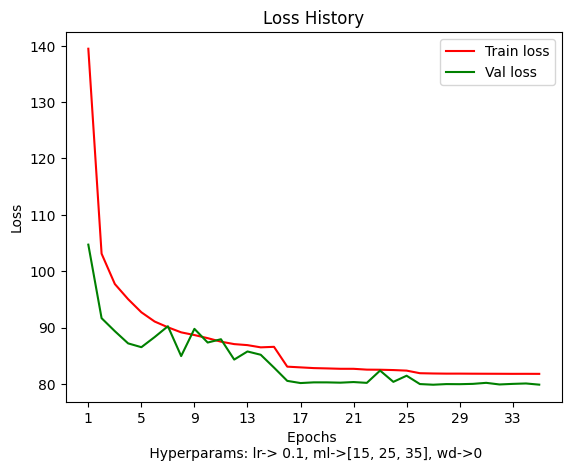

[Epoch: 36, Iteration:     1]  training loss: 82.060
[Epoch: 36, Iteration:   201]  training loss: 80.453
[Epoch: 36, Iteration:   401]  training loss: 77.648
[Epoch: 36, Iteration:   601]  training loss: 83.127
[Epoch: 36, Iteration:     1]  validation loss: 76.896
[Epoch: 37, Iteration:     1]  training loss: 82.779
[Epoch: 37, Iteration:   201]  training loss: 89.927
[Epoch: 37, Iteration:   401]  training loss: 86.191
[Epoch: 37, Iteration:   601]  training loss: 82.879
[Epoch: 37, Iteration:     1]  validation loss: 83.302
[Epoch: 38, Iteration:     1]  training loss: 83.011
[Epoch: 38, Iteration:   201]  training loss: 78.575
[Epoch: 38, Iteration:   401]  training loss: 84.101
[Epoch: 38, Iteration:   601]  training loss: 80.875
[Epoch: 38, Iteration:     1]  validation loss: 77.419
[Epoch: 39, Iteration:     1]  training loss: 82.536
[Epoch: 39, Iteration:   201]  training loss: 82.217
[Epoch: 39, Iteration:   401]  training loss: 79.091
[Epoch: 39, Iteration:   601]  training 

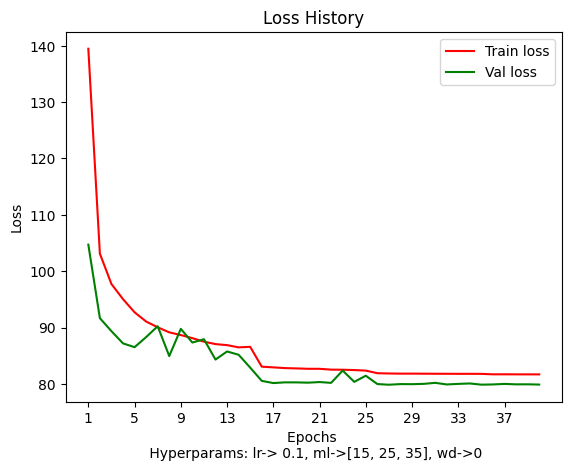

 22%|██▏       | 4/18 [1:05:24<3:49:23, 983.14s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 556.728
[Epoch: 1, Iteration:   201]  training loss: 129.239
[Epoch: 1, Iteration:   401]  training loss: 123.952
[Epoch: 1, Iteration:   601]  training loss: 114.270
[Epoch: 1, Iteration:     1]  validation loss: 112.124
[Epoch: 2, Iteration:     1]  training loss: 117.994
[Epoch: 2, Iteration:   201]  training loss: 109.463
[Epoch: 2, Iteration:   401]  training loss: 112.919
[Epoch: 2, Iteration:   601]  training loss: 105.624
[Epoch: 2, Iteration:     1]  validation loss: 104.802
[Epoch: 3, Iteration:     1]  training loss: 109.603
[Epoch: 3, Iteration:   201]  training loss: 115.405
[Epoch: 3, Iteration:   401]  training loss: 107.637
[Epoch: 3, Iteration:   601]  training loss: 107.563
[Epoch: 3, Iteration:     1]  validation loss: 114.232
[Epoch: 4, Iteration:     1]  training loss: 103.502
[Epoch: 4, Iteration:   201]  training loss: 99.667
[Epoch: 4, Iteration:   401]  training los

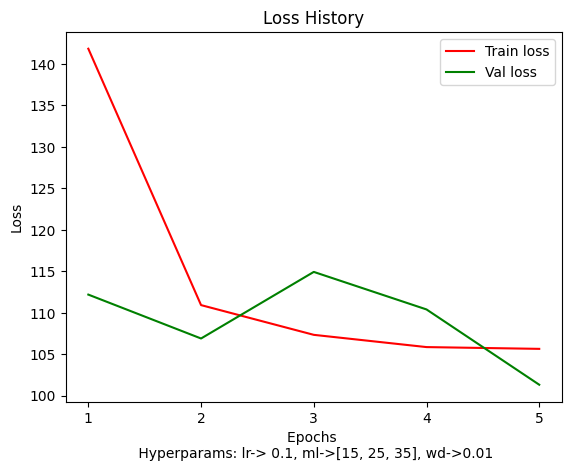

[Epoch: 6, Iteration:     1]  training loss: 98.267
[Epoch: 6, Iteration:   201]  training loss: 103.600
[Epoch: 6, Iteration:   401]  training loss: 101.346
[Epoch: 6, Iteration:   601]  training loss: 101.624
[Epoch: 6, Iteration:     1]  validation loss: 102.279
[Epoch: 7, Iteration:     1]  training loss: 99.072
[Epoch: 7, Iteration:   201]  training loss: 103.702
[Epoch: 7, Iteration:   401]  training loss: 106.692
[Epoch: 7, Iteration:   601]  training loss: 103.160
[Epoch: 7, Iteration:     1]  validation loss: 100.547
[Epoch: 8, Iteration:     1]  training loss: 109.872
[Epoch: 8, Iteration:   201]  training loss: 108.760
[Epoch: 8, Iteration:   401]  training loss: 103.960
[Epoch: 8, Iteration:   601]  training loss: 106.005
[Epoch: 8, Iteration:     1]  validation loss: 114.173
[Epoch: 9, Iteration:     1]  training loss: 108.699
[Epoch: 9, Iteration:   201]  training loss: 104.165
[Epoch: 9, Iteration:   401]  training loss: 101.552
[Epoch: 9, Iteration:   601]  training los

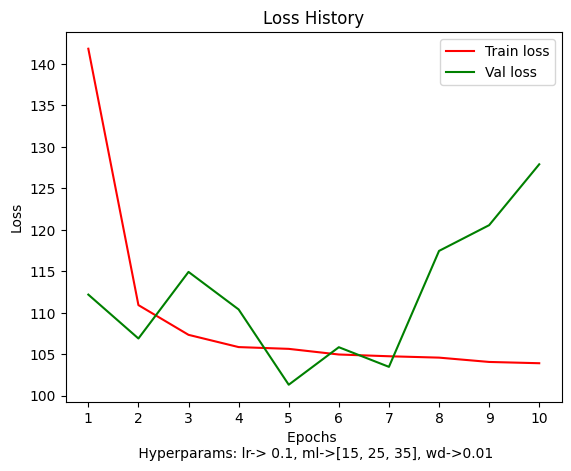

[Epoch: 11, Iteration:     1]  training loss: 113.642
[Epoch: 11, Iteration:   201]  training loss: 98.107
[Epoch: 11, Iteration:   401]  training loss: 99.900
[Epoch: 11, Iteration:   601]  training loss: 109.100
[Epoch: 11, Iteration:     1]  validation loss: 107.871
[Epoch: 12, Iteration:     1]  training loss: 103.767
[Epoch: 12, Iteration:   201]  training loss: 99.252
[Epoch: 12, Iteration:   401]  training loss: 104.980
[Epoch: 12, Iteration:   601]  training loss: 98.031
[Epoch: 12, Iteration:     1]  validation loss: 116.645
[Epoch: 13, Iteration:     1]  training loss: 108.205
[Epoch: 13, Iteration:   201]  training loss: 103.026
[Epoch: 13, Iteration:   401]  training loss: 107.427
[Epoch: 13, Iteration:   601]  training loss: 106.387
[Epoch: 13, Iteration:     1]  validation loss: 106.257
[Epoch: 14, Iteration:     1]  training loss: 106.775
[Epoch: 14, Iteration:   201]  training loss: 98.036
[Epoch: 14, Iteration:   401]  training loss: 99.262
[Epoch: 14, Iteration:   601

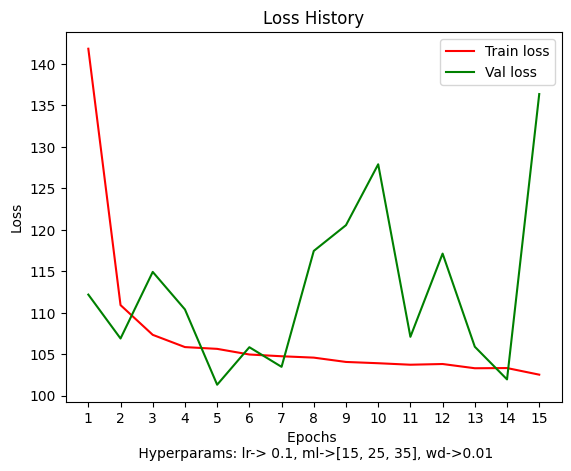

[Epoch: 16, Iteration:     1]  training loss: 106.734
[Epoch: 16, Iteration:   201]  training loss: 91.477
[Epoch: 16, Iteration:   401]  training loss: 90.679
[Epoch: 16, Iteration:   601]  training loss: 90.554
[Epoch: 16, Iteration:     1]  validation loss: 84.573
[Epoch: 17, Iteration:     1]  training loss: 91.880
[Epoch: 17, Iteration:   201]  training loss: 94.043
[Epoch: 17, Iteration:   401]  training loss: 91.009
[Epoch: 17, Iteration:   601]  training loss: 93.387
[Epoch: 17, Iteration:     1]  validation loss: 88.595
[Epoch: 18, Iteration:     1]  training loss: 95.051
[Epoch: 18, Iteration:   201]  training loss: 94.038
[Epoch: 18, Iteration:   401]  training loss: 87.614
[Epoch: 18, Iteration:   601]  training loss: 91.487
[Epoch: 18, Iteration:     1]  validation loss: 86.138
[Epoch: 19, Iteration:     1]  training loss: 89.759
[Epoch: 19, Iteration:   201]  training loss: 89.014
[Epoch: 19, Iteration:   401]  training loss: 86.690
[Epoch: 19, Iteration:   601]  training

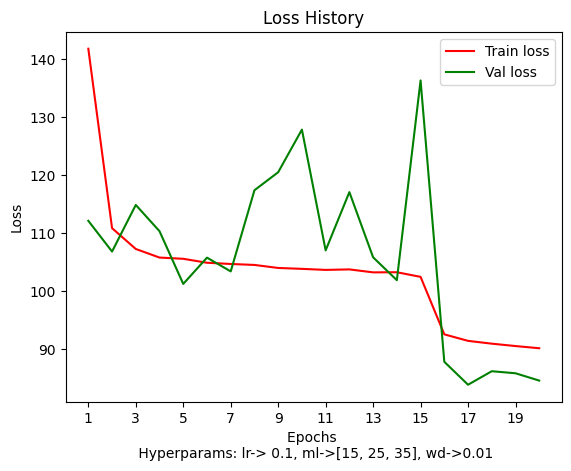

[Epoch: 21, Iteration:     1]  training loss: 88.108
[Epoch: 21, Iteration:   201]  training loss: 85.506
[Epoch: 21, Iteration:   401]  training loss: 88.356
[Epoch: 21, Iteration:   601]  training loss: 92.060
[Epoch: 21, Iteration:     1]  validation loss: 85.557
[Epoch: 22, Iteration:     1]  training loss: 90.419
[Epoch: 22, Iteration:   201]  training loss: 84.528
[Epoch: 22, Iteration:   401]  training loss: 89.229
[Epoch: 22, Iteration:   601]  training loss: 91.573
[Epoch: 22, Iteration:     1]  validation loss: 85.823
[Epoch: 23, Iteration:     1]  training loss: 90.702
[Epoch: 23, Iteration:   201]  training loss: 90.120
[Epoch: 23, Iteration:   401]  training loss: 90.837
[Epoch: 23, Iteration:   601]  training loss: 91.512
[Epoch: 23, Iteration:     1]  validation loss: 81.605
[Epoch: 24, Iteration:     1]  training loss: 86.260
[Epoch: 24, Iteration:   201]  training loss: 92.282
[Epoch: 24, Iteration:   401]  training loss: 93.838
[Epoch: 24, Iteration:   601]  training 

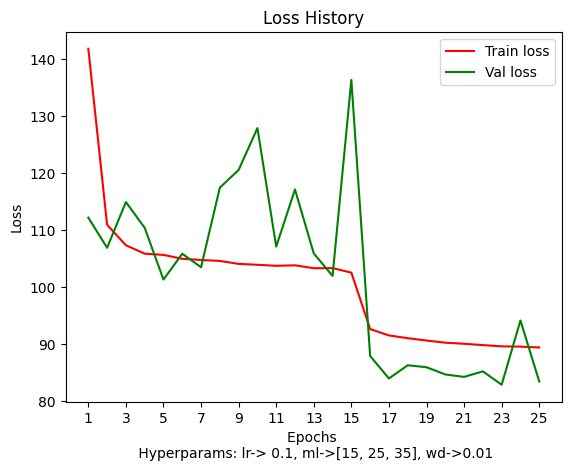

[Epoch: 26, Iteration:     1]  training loss: 90.259
[Epoch: 26, Iteration:   201]  training loss: 89.238
[Epoch: 26, Iteration:   401]  training loss: 89.795
[Epoch: 26, Iteration:   601]  training loss: 93.409
[Epoch: 26, Iteration:     1]  validation loss: 78.184
[Epoch: 27, Iteration:     1]  training loss: 89.195
[Epoch: 27, Iteration:   201]  training loss: 86.110
[Epoch: 27, Iteration:   401]  training loss: 86.625
[Epoch: 27, Iteration:   601]  training loss: 83.583
[Epoch: 27, Iteration:     1]  validation loss: 79.371
[Epoch: 28, Iteration:     1]  training loss: 90.027
[Epoch: 28, Iteration:   201]  training loss: 85.429
[Epoch: 28, Iteration:   401]  training loss: 82.254
[Epoch: 28, Iteration:   601]  training loss: 84.289
[Epoch: 28, Iteration:     1]  validation loss: 81.572
[Epoch: 29, Iteration:     1]  training loss: 88.464
[Epoch: 29, Iteration:   201]  training loss: 84.215
[Epoch: 29, Iteration:   401]  training loss: 84.013
[Epoch: 29, Iteration:   601]  training 

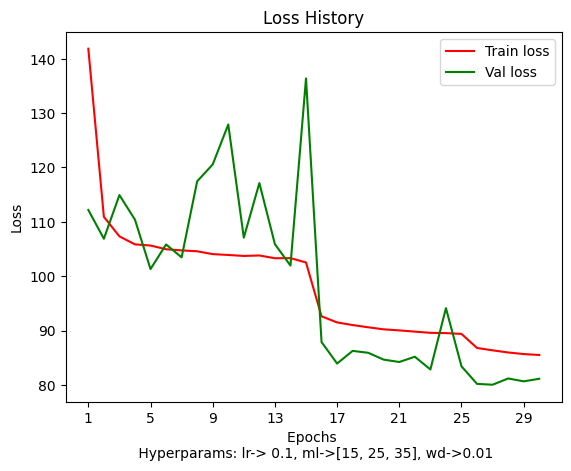

[Epoch: 31, Iteration:     1]  training loss: 86.806
[Epoch: 31, Iteration:   201]  training loss: 84.704
[Epoch: 31, Iteration:   401]  training loss: 86.492
[Epoch: 31, Iteration:   601]  training loss: 81.534
[Epoch: 31, Iteration:     1]  validation loss: 79.806
[Epoch: 32, Iteration:     1]  training loss: 83.797
[Epoch: 32, Iteration:   201]  training loss: 81.196
[Epoch: 32, Iteration:   401]  training loss: 77.352
[Epoch: 32, Iteration:   601]  training loss: 91.600
[Epoch: 32, Iteration:     1]  validation loss: 79.456
[Epoch: 33, Iteration:     1]  training loss: 84.429
[Epoch: 33, Iteration:   201]  training loss: 82.760
[Epoch: 33, Iteration:   401]  training loss: 83.465
[Epoch: 33, Iteration:   601]  training loss: 83.903
[Epoch: 33, Iteration:     1]  validation loss: 84.258
[Epoch: 34, Iteration:     1]  training loss: 79.460
[Epoch: 34, Iteration:   201]  training loss: 82.851
[Epoch: 34, Iteration:   401]  training loss: 84.139
[Epoch: 34, Iteration:   601]  training 

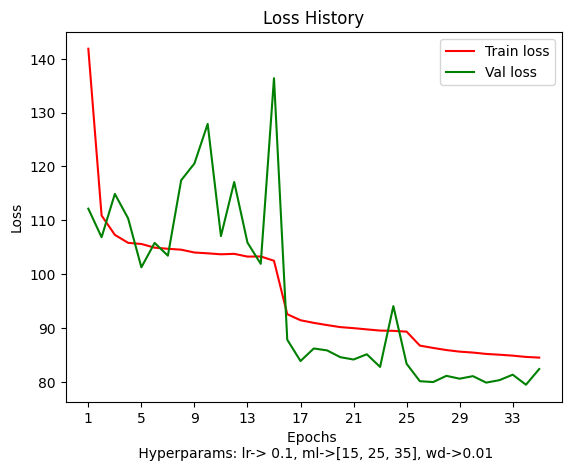

[Epoch: 36, Iteration:     1]  training loss: 78.537
[Epoch: 36, Iteration:   201]  training loss: 83.514
[Epoch: 36, Iteration:   401]  training loss: 80.481
[Epoch: 36, Iteration:   601]  training loss: 79.726
[Epoch: 36, Iteration:     1]  validation loss: 78.685
[Epoch: 37, Iteration:     1]  training loss: 81.434
[Epoch: 37, Iteration:   201]  training loss: 81.007
[Epoch: 37, Iteration:   401]  training loss: 80.472
[Epoch: 37, Iteration:   601]  training loss: 84.117
[Epoch: 37, Iteration:     1]  validation loss: 79.014
[Epoch: 38, Iteration:     1]  training loss: 85.987
[Epoch: 38, Iteration:   201]  training loss: 84.134
[Epoch: 38, Iteration:   401]  training loss: 84.229
[Epoch: 38, Iteration:   601]  training loss: 86.079
[Epoch: 38, Iteration:     1]  validation loss: 78.515
[Epoch: 39, Iteration:     1]  training loss: 77.818
[Epoch: 39, Iteration:   201]  training loss: 84.744
[Epoch: 39, Iteration:   401]  training loss: 80.583
[Epoch: 39, Iteration:   601]  training 

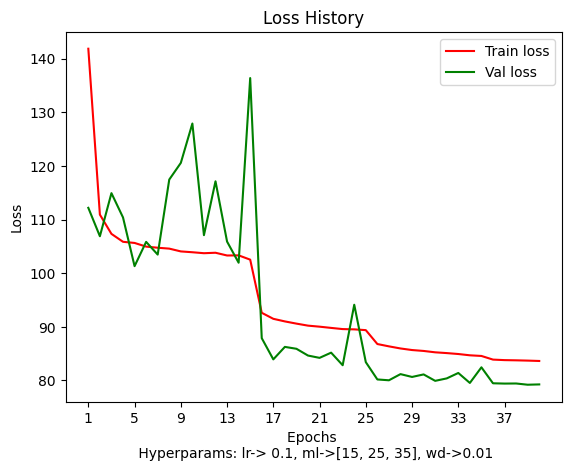

 28%|██▊       | 5/18 [1:21:48<3:33:06, 983.57s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 558.721
[Epoch: 1, Iteration:   201]  training loss: 124.224
[Epoch: 1, Iteration:   401]  training loss: 113.706
[Epoch: 1, Iteration:   601]  training loss: 105.126
[Epoch: 1, Iteration:     1]  validation loss: 100.548
[Epoch: 2, Iteration:     1]  training loss: 106.164
[Epoch: 2, Iteration:   201]  training loss: 97.911
[Epoch: 2, Iteration:   401]  training loss: 95.662
[Epoch: 2, Iteration:   601]  training loss: 92.998
[Epoch: 2, Iteration:     1]  validation loss: 92.617
[Epoch: 3, Iteration:     1]  training loss: 98.348
[Epoch: 3, Iteration:   201]  training loss: 91.968
[Epoch: 3, Iteration:   401]  training loss: 91.998
[Epoch: 3, Iteration:   601]  training loss: 93.663
[Epoch: 3, Iteration:     1]  validation loss: 84.299
[Epoch: 4, Iteration:     1]  training loss: 88.158
[Epoch: 4, Iteration:   201]  training loss: 98.008
[Epoch: 4, Iteration:   401]  training loss: 84.451


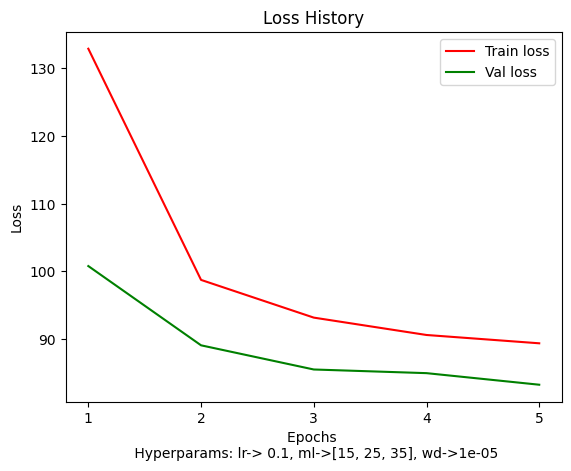

[Epoch: 6, Iteration:     1]  training loss: 94.284
[Epoch: 6, Iteration:   201]  training loss: 89.172
[Epoch: 6, Iteration:   401]  training loss: 90.832
[Epoch: 6, Iteration:   601]  training loss: 87.477
[Epoch: 6, Iteration:     1]  validation loss: 87.059
[Epoch: 7, Iteration:     1]  training loss: 85.451
[Epoch: 7, Iteration:   201]  training loss: 89.066
[Epoch: 7, Iteration:   401]  training loss: 82.401
[Epoch: 7, Iteration:   601]  training loss: 94.776
[Epoch: 7, Iteration:     1]  validation loss: 86.255
[Epoch: 8, Iteration:     1]  training loss: 90.302
[Epoch: 8, Iteration:   201]  training loss: 88.730
[Epoch: 8, Iteration:   401]  training loss: 87.904
[Epoch: 8, Iteration:   601]  training loss: 90.578
[Epoch: 8, Iteration:     1]  validation loss: 93.025
[Epoch: 9, Iteration:     1]  training loss: 91.939
[Epoch: 9, Iteration:   201]  training loss: 82.911
[Epoch: 9, Iteration:   401]  training loss: 87.071
[Epoch: 9, Iteration:   601]  training loss: 82.533
[Epoch

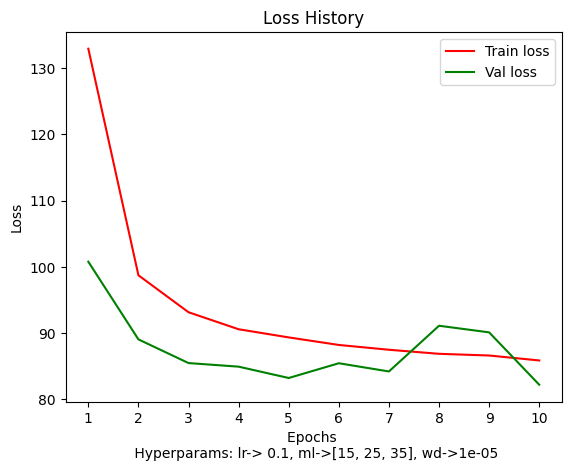

[Epoch: 11, Iteration:     1]  training loss: 87.016
[Epoch: 11, Iteration:   201]  training loss: 81.427
[Epoch: 11, Iteration:   401]  training loss: 92.980
[Epoch: 11, Iteration:   601]  training loss: 86.281
[Epoch: 11, Iteration:     1]  validation loss: 92.684
[Epoch: 12, Iteration:     1]  training loss: 89.025
[Epoch: 12, Iteration:   201]  training loss: 86.312
[Epoch: 12, Iteration:   401]  training loss: 85.786
[Epoch: 12, Iteration:   601]  training loss: 90.541
[Epoch: 12, Iteration:     1]  validation loss: 77.811
[Epoch: 13, Iteration:     1]  training loss: 87.693
[Epoch: 13, Iteration:   201]  training loss: 81.096
[Epoch: 13, Iteration:   401]  training loss: 79.985
[Epoch: 13, Iteration:   601]  training loss: 84.676
[Epoch: 13, Iteration:     1]  validation loss: 96.279
[Epoch: 14, Iteration:     1]  training loss: 93.532
[Epoch: 14, Iteration:   201]  training loss: 82.447
[Epoch: 14, Iteration:   401]  training loss: 84.626
[Epoch: 14, Iteration:   601]  training 

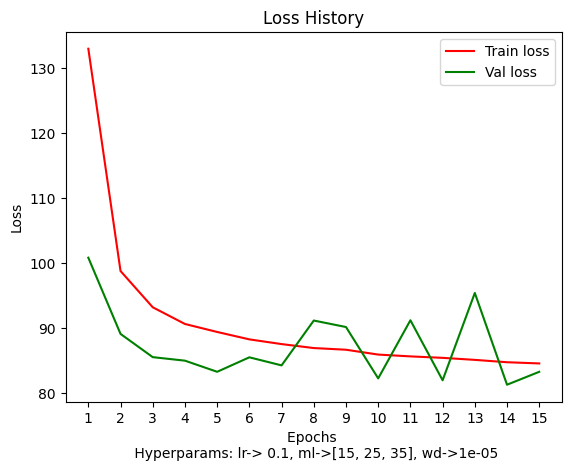

[Epoch: 16, Iteration:     1]  training loss: 80.630
[Epoch: 16, Iteration:   201]  training loss: 81.465
[Epoch: 16, Iteration:   401]  training loss: 76.122
[Epoch: 16, Iteration:   601]  training loss: 83.122
[Epoch: 16, Iteration:     1]  validation loss: 78.159
[Epoch: 17, Iteration:     1]  training loss: 76.443
[Epoch: 17, Iteration:   201]  training loss: 78.458
[Epoch: 17, Iteration:   401]  training loss: 79.389
[Epoch: 17, Iteration:   601]  training loss: 79.831
[Epoch: 17, Iteration:     1]  validation loss: 78.820
[Epoch: 18, Iteration:     1]  training loss: 80.136
[Epoch: 18, Iteration:   201]  training loss: 79.388
[Epoch: 18, Iteration:   401]  training loss: 78.480
[Epoch: 18, Iteration:   601]  training loss: 82.470
[Epoch: 18, Iteration:     1]  validation loss: 79.395
[Epoch: 19, Iteration:     1]  training loss: 76.734
[Epoch: 19, Iteration:   201]  training loss: 85.288
[Epoch: 19, Iteration:   401]  training loss: 79.926
[Epoch: 19, Iteration:   601]  training 

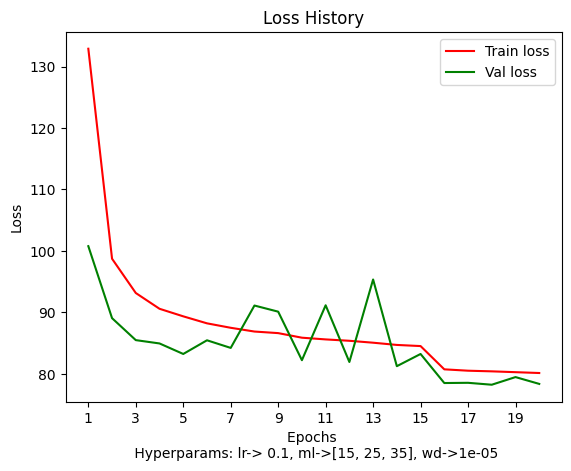

[Epoch: 21, Iteration:     1]  training loss: 81.220
[Epoch: 21, Iteration:   201]  training loss: 78.535
[Epoch: 21, Iteration:   401]  training loss: 82.985
[Epoch: 21, Iteration:   601]  training loss: 81.247
[Epoch: 21, Iteration:     1]  validation loss: 81.839
[Epoch: 22, Iteration:     1]  training loss: 81.888
[Epoch: 22, Iteration:   201]  training loss: 83.166
[Epoch: 22, Iteration:   401]  training loss: 76.450
[Epoch: 22, Iteration:   601]  training loss: 79.058
[Epoch: 22, Iteration:     1]  validation loss: 76.248
[Epoch: 23, Iteration:     1]  training loss: 77.259
[Epoch: 23, Iteration:   201]  training loss: 85.814
[Epoch: 23, Iteration:   401]  training loss: 79.147
[Epoch: 23, Iteration:   601]  training loss: 79.581
[Epoch: 23, Iteration:     1]  validation loss: 77.615
[Epoch: 24, Iteration:     1]  training loss: 81.650
[Epoch: 24, Iteration:   201]  training loss: 78.758
[Epoch: 24, Iteration:   401]  training loss: 81.735
[Epoch: 24, Iteration:   601]  training 

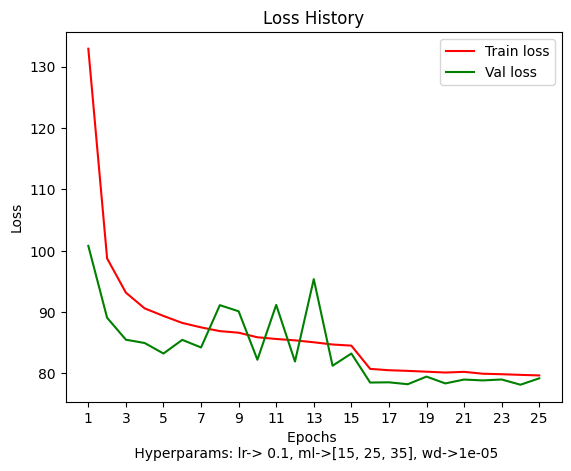

[Epoch: 26, Iteration:     1]  training loss: 79.999
[Epoch: 26, Iteration:   201]  training loss: 82.093
[Epoch: 26, Iteration:   401]  training loss: 80.374
[Epoch: 26, Iteration:   601]  training loss: 80.713
[Epoch: 26, Iteration:     1]  validation loss: 80.304
[Epoch: 27, Iteration:     1]  training loss: 75.005
[Epoch: 27, Iteration:   201]  training loss: 78.828
[Epoch: 27, Iteration:   401]  training loss: 78.472
[Epoch: 27, Iteration:   601]  training loss: 78.533
[Epoch: 27, Iteration:     1]  validation loss: 74.324
[Epoch: 28, Iteration:     1]  training loss: 81.127
[Epoch: 28, Iteration:   201]  training loss: 83.527
[Epoch: 28, Iteration:   401]  training loss: 79.795
[Epoch: 28, Iteration:   601]  training loss: 75.808
[Epoch: 28, Iteration:     1]  validation loss: 72.913
[Epoch: 29, Iteration:     1]  training loss: 80.152
[Epoch: 29, Iteration:   201]  training loss: 78.386
[Epoch: 29, Iteration:   401]  training loss: 76.098
[Epoch: 29, Iteration:   601]  training 

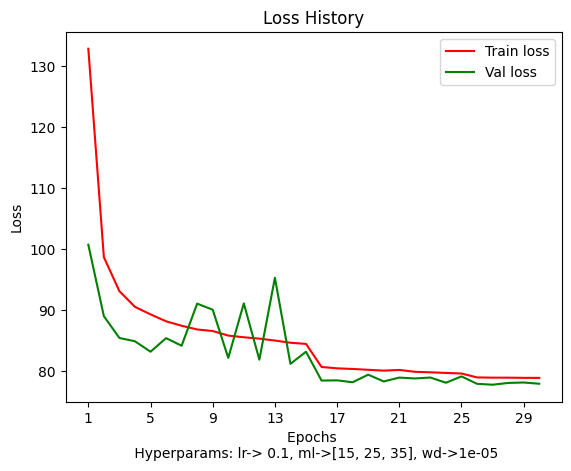

[Epoch: 31, Iteration:     1]  training loss: 75.876
[Epoch: 31, Iteration:   201]  training loss: 80.870
[Epoch: 31, Iteration:   401]  training loss: 76.597
[Epoch: 31, Iteration:   601]  training loss: 81.523
[Epoch: 31, Iteration:     1]  validation loss: 77.368
[Epoch: 32, Iteration:     1]  training loss: 77.913
[Epoch: 32, Iteration:   201]  training loss: 76.192
[Epoch: 32, Iteration:   401]  training loss: 78.293
[Epoch: 32, Iteration:   601]  training loss: 74.353
[Epoch: 32, Iteration:     1]  validation loss: 78.159
[Epoch: 33, Iteration:     1]  training loss: 86.800
[Epoch: 33, Iteration:   201]  training loss: 79.395
[Epoch: 33, Iteration:   401]  training loss: 80.053
[Epoch: 33, Iteration:   601]  training loss: 77.565
[Epoch: 33, Iteration:     1]  validation loss: 79.186
[Epoch: 34, Iteration:     1]  training loss: 80.852
[Epoch: 34, Iteration:   201]  training loss: 72.135
[Epoch: 34, Iteration:   401]  training loss: 77.180
[Epoch: 34, Iteration:   601]  training 

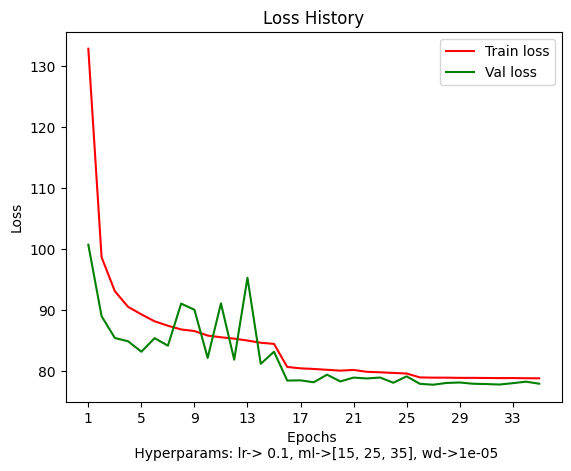

[Epoch: 36, Iteration:     1]  training loss: 81.264
[Epoch: 36, Iteration:   201]  training loss: 78.205
[Epoch: 36, Iteration:   401]  training loss: 80.738
[Epoch: 36, Iteration:   601]  training loss: 79.406
[Epoch: 36, Iteration:     1]  validation loss: 78.503
[Epoch: 37, Iteration:     1]  training loss: 77.460
[Epoch: 37, Iteration:   201]  training loss: 73.682
[Epoch: 37, Iteration:   401]  training loss: 75.501
[Epoch: 37, Iteration:   601]  training loss: 82.502
[Epoch: 37, Iteration:     1]  validation loss: 75.368
[Epoch: 38, Iteration:     1]  training loss: 76.329
[Epoch: 38, Iteration:   201]  training loss: 81.821
[Epoch: 38, Iteration:   401]  training loss: 79.602
[Epoch: 38, Iteration:   601]  training loss: 79.365
[Epoch: 38, Iteration:     1]  validation loss: 75.198
[Epoch: 39, Iteration:     1]  training loss: 74.881
[Epoch: 39, Iteration:   201]  training loss: 80.632
[Epoch: 39, Iteration:   401]  training loss: 76.819
[Epoch: 39, Iteration:   601]  training 

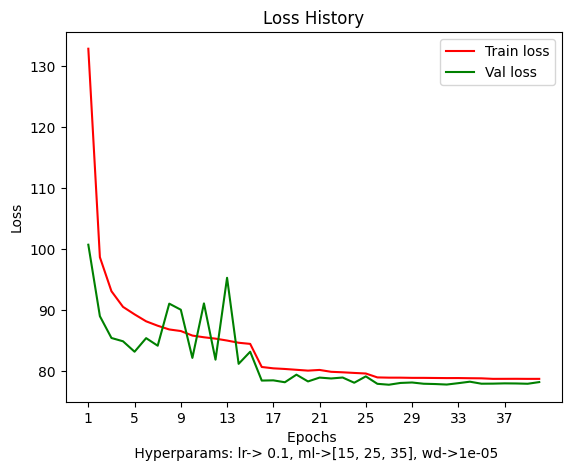

 33%|███▎      | 6/18 [1:37:57<3:15:44, 978.70s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 554.779
[Epoch: 1, Iteration:   201]  training loss: 145.769
[Epoch: 1, Iteration:   401]  training loss: 123.828
[Epoch: 1, Iteration:   601]  training loss: 107.228
[Epoch: 1, Iteration:     1]  validation loss: 110.729
[Epoch: 2, Iteration:     1]  training loss: 119.418
[Epoch: 2, Iteration:   201]  training loss: 102.964
[Epoch: 2, Iteration:   401]  training loss: 115.593
[Epoch: 2, Iteration:   601]  training loss: 106.991
[Epoch: 2, Iteration:     1]  validation loss: 95.428
[Epoch: 3, Iteration:     1]  training loss: 110.031
[Epoch: 3, Iteration:   201]  training loss: 102.157
[Epoch: 3, Iteration:   401]  training loss: 101.021
[Epoch: 3, Iteration:   601]  training loss: 102.174
[Epoch: 3, Iteration:     1]  validation loss: 95.900
[Epoch: 4, Iteration:     1]  training loss: 101.806
[Epoch: 4, Iteration:   201]  training loss: 100.323
[Epoch: 4, Iteration:   401]  training loss

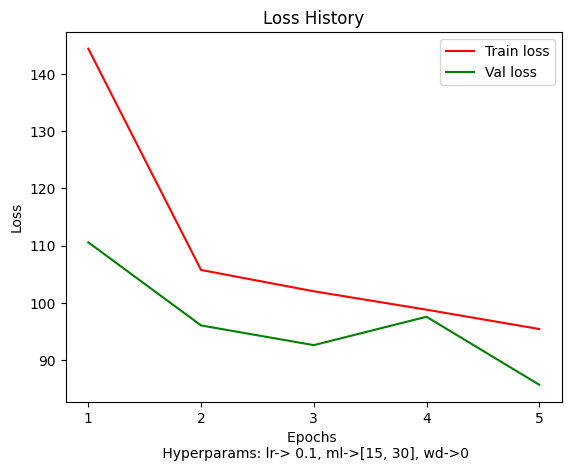

[Epoch: 6, Iteration:     1]  training loss: 94.187
[Epoch: 6, Iteration:   201]  training loss: 96.507
[Epoch: 6, Iteration:   401]  training loss: 94.323
[Epoch: 6, Iteration:   601]  training loss: 94.641
[Epoch: 6, Iteration:     1]  validation loss: 88.288
[Epoch: 7, Iteration:     1]  training loss: 88.032
[Epoch: 7, Iteration:   201]  training loss: 92.865
[Epoch: 7, Iteration:   401]  training loss: 92.705
[Epoch: 7, Iteration:   601]  training loss: 93.736
[Epoch: 7, Iteration:     1]  validation loss: 86.588
[Epoch: 8, Iteration:     1]  training loss: 92.343
[Epoch: 8, Iteration:   201]  training loss: 89.678
[Epoch: 8, Iteration:   401]  training loss: 86.828
[Epoch: 8, Iteration:   601]  training loss: 93.447
[Epoch: 8, Iteration:     1]  validation loss: 87.143
[Epoch: 9, Iteration:     1]  training loss: 97.703
[Epoch: 9, Iteration:   201]  training loss: 88.193
[Epoch: 9, Iteration:   401]  training loss: 90.357
[Epoch: 9, Iteration:   601]  training loss: 87.984
[Epoch

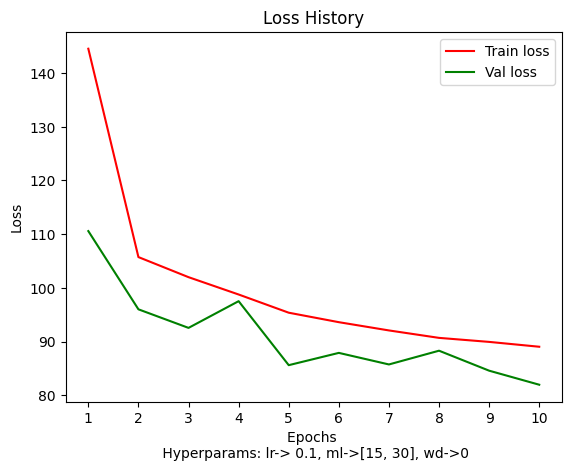

[Epoch: 11, Iteration:     1]  training loss: 86.425
[Epoch: 11, Iteration:   201]  training loss: 83.360
[Epoch: 11, Iteration:   401]  training loss: 88.292
[Epoch: 11, Iteration:   601]  training loss: 90.752
[Epoch: 11, Iteration:     1]  validation loss: 81.328
[Epoch: 12, Iteration:     1]  training loss: 85.733
[Epoch: 12, Iteration:   201]  training loss: 85.790
[Epoch: 12, Iteration:   401]  training loss: 83.989
[Epoch: 12, Iteration:   601]  training loss: 88.170
[Epoch: 12, Iteration:     1]  validation loss: 81.845
[Epoch: 13, Iteration:     1]  training loss: 93.139
[Epoch: 13, Iteration:   201]  training loss: 85.140
[Epoch: 13, Iteration:   401]  training loss: 85.470
[Epoch: 13, Iteration:   601]  training loss: 86.738
[Epoch: 13, Iteration:     1]  validation loss: 90.695
[Epoch: 14, Iteration:     1]  training loss: 89.367
[Epoch: 14, Iteration:   201]  training loss: 86.338
[Epoch: 14, Iteration:   401]  training loss: 86.631
[Epoch: 14, Iteration:   601]  training 

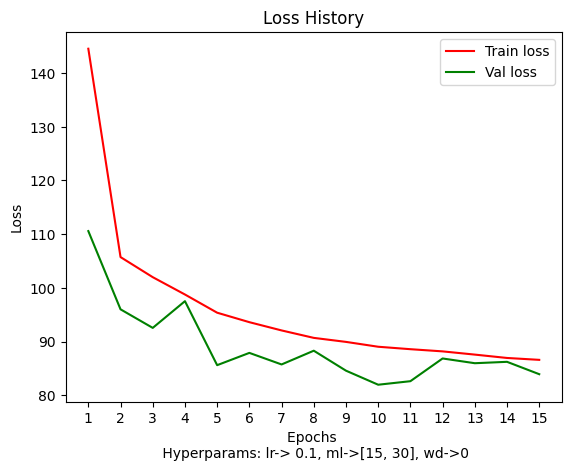

[Epoch: 16, Iteration:     1]  training loss: 82.282
[Epoch: 16, Iteration:   201]  training loss: 81.150
[Epoch: 16, Iteration:   401]  training loss: 79.465
[Epoch: 16, Iteration:   601]  training loss: 83.479
[Epoch: 16, Iteration:     1]  validation loss: 75.607
[Epoch: 17, Iteration:     1]  training loss: 83.965
[Epoch: 17, Iteration:   201]  training loss: 83.910
[Epoch: 17, Iteration:   401]  training loss: 83.717
[Epoch: 17, Iteration:   601]  training loss: 86.677
[Epoch: 17, Iteration:     1]  validation loss: 85.007
[Epoch: 18, Iteration:     1]  training loss: 83.655
[Epoch: 18, Iteration:   201]  training loss: 82.786
[Epoch: 18, Iteration:   401]  training loss: 82.396
[Epoch: 18, Iteration:   601]  training loss: 83.442
[Epoch: 18, Iteration:     1]  validation loss: 83.078
[Epoch: 19, Iteration:     1]  training loss: 86.113
[Epoch: 19, Iteration:   201]  training loss: 80.918
[Epoch: 19, Iteration:   401]  training loss: 84.394
[Epoch: 19, Iteration:   601]  training 

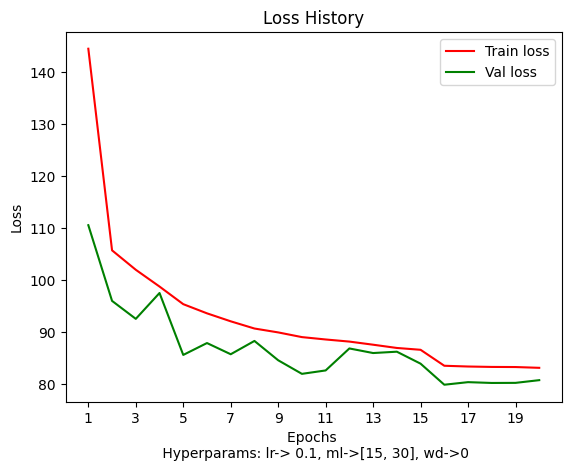

[Epoch: 21, Iteration:     1]  training loss: 79.538
[Epoch: 21, Iteration:   201]  training loss: 82.169
[Epoch: 21, Iteration:   401]  training loss: 84.486
[Epoch: 21, Iteration:   601]  training loss: 76.614
[Epoch: 21, Iteration:     1]  validation loss: 82.827
[Epoch: 22, Iteration:     1]  training loss: 79.960
[Epoch: 22, Iteration:   201]  training loss: 83.572
[Epoch: 22, Iteration:   401]  training loss: 86.217
[Epoch: 22, Iteration:   601]  training loss: 86.518
[Epoch: 22, Iteration:     1]  validation loss: 79.477
[Epoch: 23, Iteration:     1]  training loss: 79.268
[Epoch: 23, Iteration:   201]  training loss: 81.947
[Epoch: 23, Iteration:   401]  training loss: 83.952
[Epoch: 23, Iteration:   601]  training loss: 78.976
[Epoch: 23, Iteration:     1]  validation loss: 82.825
[Epoch: 24, Iteration:     1]  training loss: 78.744
[Epoch: 24, Iteration:   201]  training loss: 85.665
[Epoch: 24, Iteration:   401]  training loss: 83.112
[Epoch: 24, Iteration:   601]  training 

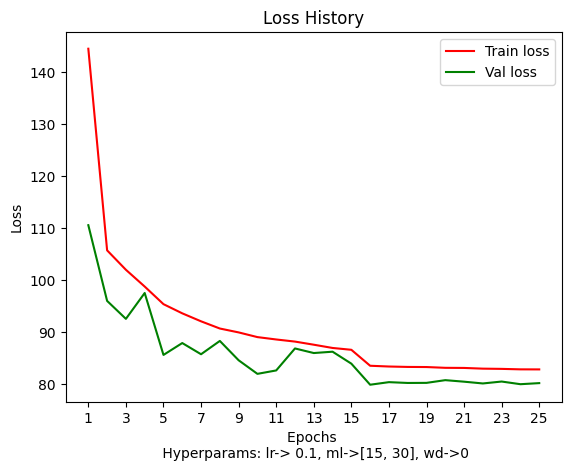

[Epoch: 26, Iteration:     1]  training loss: 84.783
[Epoch: 26, Iteration:   201]  training loss: 84.176
[Epoch: 26, Iteration:   401]  training loss: 83.396
[Epoch: 26, Iteration:   601]  training loss: 87.490
[Epoch: 26, Iteration:     1]  validation loss: 84.366
[Epoch: 27, Iteration:     1]  training loss: 80.528
[Epoch: 27, Iteration:   201]  training loss: 86.049
[Epoch: 27, Iteration:   401]  training loss: 85.732
[Epoch: 27, Iteration:   601]  training loss: 83.575
[Epoch: 27, Iteration:     1]  validation loss: 80.720
[Epoch: 28, Iteration:     1]  training loss: 85.799
[Epoch: 28, Iteration:   201]  training loss: 86.156
[Epoch: 28, Iteration:   401]  training loss: 85.236
[Epoch: 28, Iteration:   601]  training loss: 79.784
[Epoch: 28, Iteration:     1]  validation loss: 78.863
[Epoch: 29, Iteration:     1]  training loss: 81.914
[Epoch: 29, Iteration:   201]  training loss: 84.199
[Epoch: 29, Iteration:   401]  training loss: 79.622
[Epoch: 29, Iteration:   601]  training 

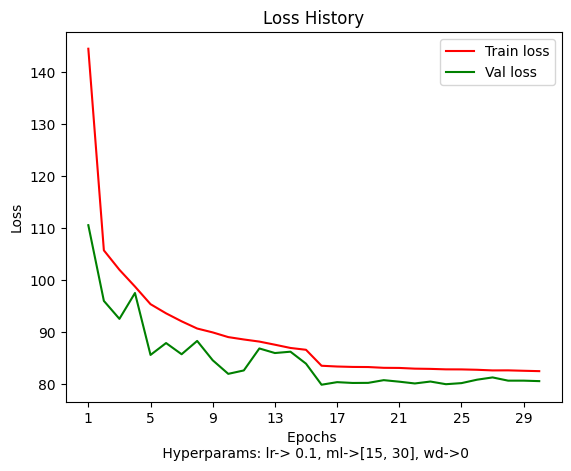

[Epoch: 31, Iteration:     1]  training loss: 80.388
[Epoch: 31, Iteration:   201]  training loss: 84.347
[Epoch: 31, Iteration:   401]  training loss: 83.341
[Epoch: 31, Iteration:   601]  training loss: 89.867
[Epoch: 31, Iteration:     1]  validation loss: 79.788
[Epoch: 32, Iteration:     1]  training loss: 81.815
[Epoch: 32, Iteration:   201]  training loss: 80.194
[Epoch: 32, Iteration:   401]  training loss: 82.744
[Epoch: 32, Iteration:   601]  training loss: 84.818
[Epoch: 32, Iteration:     1]  validation loss: 79.347
[Epoch: 33, Iteration:     1]  training loss: 80.288
[Epoch: 33, Iteration:   201]  training loss: 82.850
[Epoch: 33, Iteration:   401]  training loss: 81.148
[Epoch: 33, Iteration:   601]  training loss: 84.455
[Epoch: 33, Iteration:     1]  validation loss: 80.786
[Epoch: 34, Iteration:     1]  training loss: 79.584
[Epoch: 34, Iteration:   201]  training loss: 82.615
[Epoch: 34, Iteration:   401]  training loss: 83.646
[Epoch: 34, Iteration:   601]  training 

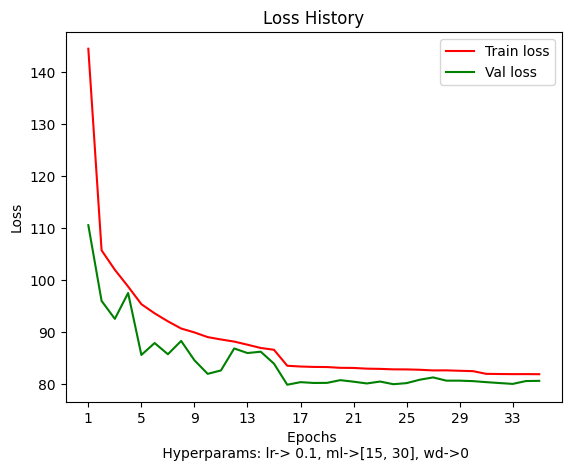

[Epoch: 36, Iteration:     1]  training loss: 83.287
[Epoch: 36, Iteration:   201]  training loss: 82.523
[Epoch: 36, Iteration:   401]  training loss: 80.845
[Epoch: 36, Iteration:   601]  training loss: 79.999
[Epoch: 36, Iteration:     1]  validation loss: 77.865
[Epoch: 37, Iteration:     1]  training loss: 87.613
[Epoch: 37, Iteration:   201]  training loss: 80.970
[Epoch: 37, Iteration:   401]  training loss: 82.145
[Epoch: 37, Iteration:   601]  training loss: 83.866
[Epoch: 37, Iteration:     1]  validation loss: 81.303
[Epoch: 38, Iteration:     1]  training loss: 79.749
[Epoch: 38, Iteration:   201]  training loss: 85.389
[Epoch: 38, Iteration:   401]  training loss: 82.096
[Epoch: 38, Iteration:   601]  training loss: 76.823
[Epoch: 38, Iteration:     1]  validation loss: 82.144
[Epoch: 39, Iteration:     1]  training loss: 82.171
[Epoch: 39, Iteration:   201]  training loss: 79.615
[Epoch: 39, Iteration:   401]  training loss: 79.475
[Epoch: 39, Iteration:   601]  training 

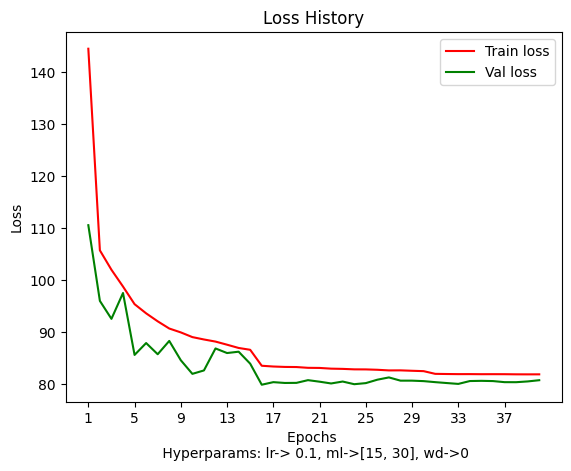

 39%|███▉      | 7/18 [1:54:56<3:01:50, 991.90s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 556.584
[Epoch: 1, Iteration:   201]  training loss: 135.135
[Epoch: 1, Iteration:   401]  training loss: 117.383
[Epoch: 1, Iteration:   601]  training loss: 111.301
[Epoch: 1, Iteration:     1]  validation loss: 119.592
[Epoch: 2, Iteration:     1]  training loss: 113.698
[Epoch: 2, Iteration:   201]  training loss: 116.275
[Epoch: 2, Iteration:   401]  training loss: 111.600
[Epoch: 2, Iteration:   601]  training loss: 112.333
[Epoch: 2, Iteration:     1]  validation loss: 106.919
[Epoch: 3, Iteration:     1]  training loss: 111.999
[Epoch: 3, Iteration:   201]  training loss: 103.757
[Epoch: 3, Iteration:   401]  training loss: 108.999
[Epoch: 3, Iteration:   601]  training loss: 110.429
[Epoch: 3, Iteration:     1]  validation loss: 106.474
[Epoch: 4, Iteration:     1]  training loss: 108.850
[Epoch: 4, Iteration:   201]  training loss: 100.690
[Epoch: 4, Iteration:   401]  training lo

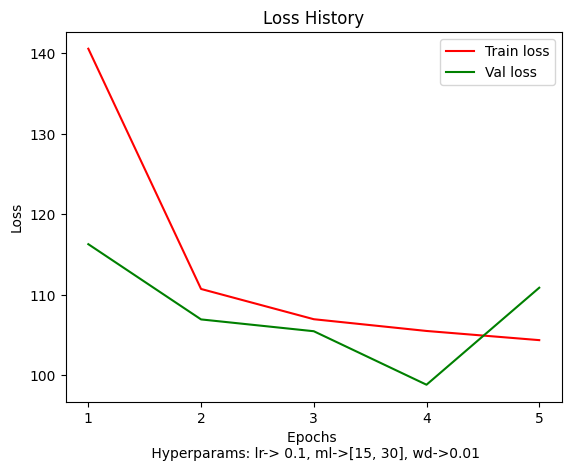

[Epoch: 6, Iteration:     1]  training loss: 101.281
[Epoch: 6, Iteration:   201]  training loss: 109.286
[Epoch: 6, Iteration:   401]  training loss: 109.436
[Epoch: 6, Iteration:   601]  training loss: 101.118
[Epoch: 6, Iteration:     1]  validation loss: 106.925
[Epoch: 7, Iteration:     1]  training loss: 109.114
[Epoch: 7, Iteration:   201]  training loss: 114.073
[Epoch: 7, Iteration:   401]  training loss: 104.514
[Epoch: 7, Iteration:   601]  training loss: 105.833
[Epoch: 7, Iteration:     1]  validation loss: 100.555
[Epoch: 8, Iteration:     1]  training loss: 109.721
[Epoch: 8, Iteration:   201]  training loss: 99.244
[Epoch: 8, Iteration:   401]  training loss: 107.499
[Epoch: 8, Iteration:   601]  training loss: 100.835
[Epoch: 8, Iteration:     1]  validation loss: 103.410
[Epoch: 9, Iteration:     1]  training loss: 109.317
[Epoch: 9, Iteration:   201]  training loss: 104.295
[Epoch: 9, Iteration:   401]  training loss: 100.503
[Epoch: 9, Iteration:   601]  training lo

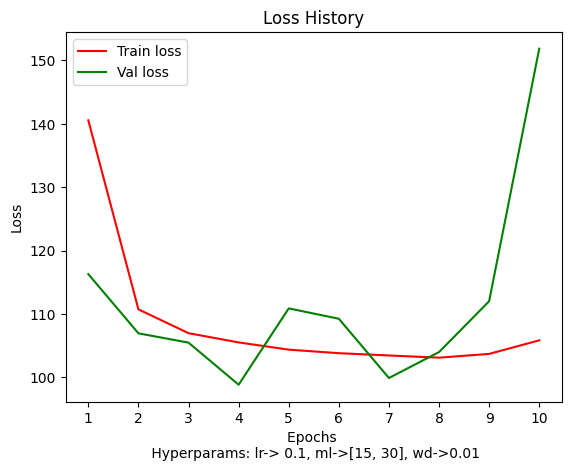

[Epoch: 11, Iteration:     1]  training loss: 105.972
[Epoch: 11, Iteration:   201]  training loss: 99.849
[Epoch: 11, Iteration:   401]  training loss: 103.768
[Epoch: 11, Iteration:   601]  training loss: 100.655
[Epoch: 11, Iteration:     1]  validation loss: 100.429
[Epoch: 12, Iteration:     1]  training loss: 96.214
[Epoch: 12, Iteration:   201]  training loss: 93.942
[Epoch: 12, Iteration:   401]  training loss: 96.276
[Epoch: 12, Iteration:   601]  training loss: 101.595
[Epoch: 12, Iteration:     1]  validation loss: 170.733
[Epoch: 13, Iteration:     1]  training loss: 113.149
[Epoch: 13, Iteration:   201]  training loss: 107.101
[Epoch: 13, Iteration:   401]  training loss: 102.935
[Epoch: 13, Iteration:   601]  training loss: 98.389
[Epoch: 13, Iteration:     1]  validation loss: 98.382
[Epoch: 14, Iteration:     1]  training loss: 105.476
[Epoch: 14, Iteration:   201]  training loss: 98.928
[Epoch: 14, Iteration:   401]  training loss: 97.798
[Epoch: 14, Iteration:   601] 

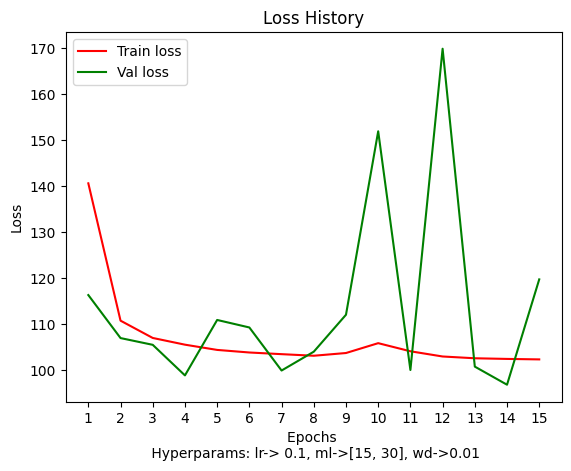

[Epoch: 16, Iteration:     1]  training loss: 108.111
[Epoch: 16, Iteration:   201]  training loss: 98.137
[Epoch: 16, Iteration:   401]  training loss: 93.394
[Epoch: 16, Iteration:   601]  training loss: 92.304
[Epoch: 16, Iteration:     1]  validation loss: 96.576
[Epoch: 17, Iteration:     1]  training loss: 95.909
[Epoch: 17, Iteration:   201]  training loss: 90.440
[Epoch: 17, Iteration:   401]  training loss: 89.814
[Epoch: 17, Iteration:   601]  training loss: 86.573
[Epoch: 17, Iteration:     1]  validation loss: 88.490
[Epoch: 18, Iteration:     1]  training loss: 93.217
[Epoch: 18, Iteration:   201]  training loss: 91.028
[Epoch: 18, Iteration:   401]  training loss: 89.807
[Epoch: 18, Iteration:   601]  training loss: 90.025
[Epoch: 18, Iteration:     1]  validation loss: 84.406
[Epoch: 19, Iteration:     1]  training loss: 92.576
[Epoch: 19, Iteration:   201]  training loss: 91.489
[Epoch: 19, Iteration:   401]  training loss: 91.746
[Epoch: 19, Iteration:   601]  training

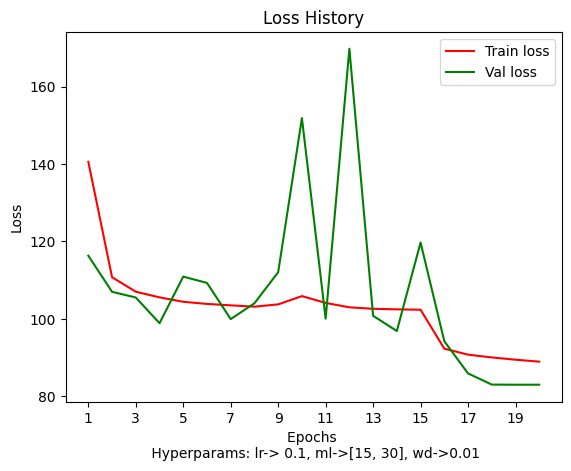

[Epoch: 21, Iteration:     1]  training loss: 94.362
[Epoch: 21, Iteration:   201]  training loss: 86.798
[Epoch: 21, Iteration:   401]  training loss: 84.883
[Epoch: 21, Iteration:   601]  training loss: 87.033
[Epoch: 21, Iteration:     1]  validation loss: 82.557
[Epoch: 22, Iteration:     1]  training loss: 93.463
[Epoch: 22, Iteration:   201]  training loss: 90.739
[Epoch: 22, Iteration:   401]  training loss: 92.589
[Epoch: 22, Iteration:   601]  training loss: 87.449
[Epoch: 22, Iteration:     1]  validation loss: 82.789
[Epoch: 23, Iteration:     1]  training loss: 91.270
[Epoch: 23, Iteration:   201]  training loss: 84.454
[Epoch: 23, Iteration:   401]  training loss: 84.434
[Epoch: 23, Iteration:   601]  training loss: 88.422
[Epoch: 23, Iteration:     1]  validation loss: 80.690
[Epoch: 24, Iteration:     1]  training loss: 90.853
[Epoch: 24, Iteration:   201]  training loss: 88.395
[Epoch: 24, Iteration:   401]  training loss: 85.694
[Epoch: 24, Iteration:   601]  training 

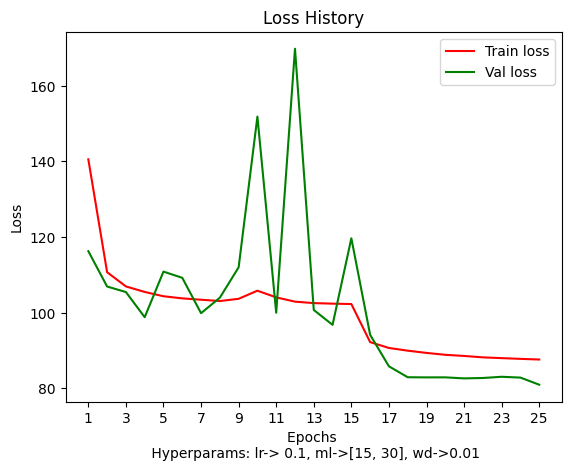

[Epoch: 26, Iteration:     1]  training loss: 87.453
[Epoch: 26, Iteration:   201]  training loss: 84.791
[Epoch: 26, Iteration:   401]  training loss: 86.017
[Epoch: 26, Iteration:   601]  training loss: 88.300
[Epoch: 26, Iteration:     1]  validation loss: 80.315
[Epoch: 27, Iteration:     1]  training loss: 91.109
[Epoch: 27, Iteration:   201]  training loss: 90.671
[Epoch: 27, Iteration:   401]  training loss: 88.691
[Epoch: 27, Iteration:   601]  training loss: 87.305
[Epoch: 27, Iteration:     1]  validation loss: 79.856
[Epoch: 28, Iteration:     1]  training loss: 84.250
[Epoch: 28, Iteration:   201]  training loss: 85.778
[Epoch: 28, Iteration:   401]  training loss: 85.158
[Epoch: 28, Iteration:   601]  training loss: 87.997
[Epoch: 28, Iteration:     1]  validation loss: 84.271
[Epoch: 29, Iteration:     1]  training loss: 88.132
[Epoch: 29, Iteration:   201]  training loss: 92.270
[Epoch: 29, Iteration:   401]  training loss: 86.318
[Epoch: 29, Iteration:   601]  training 

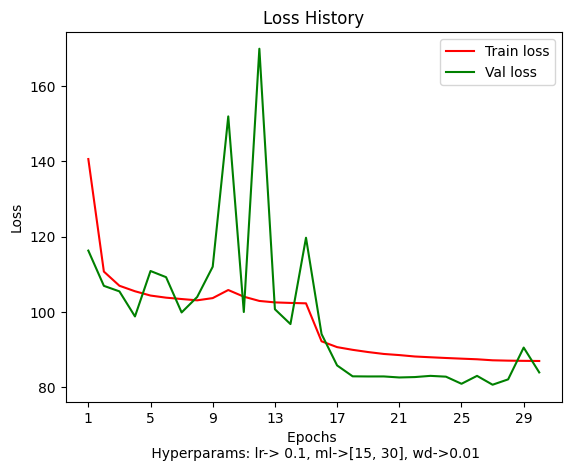

[Epoch: 31, Iteration:     1]  training loss: 87.973
[Epoch: 31, Iteration:   201]  training loss: 84.421
[Epoch: 31, Iteration:   401]  training loss: 81.161
[Epoch: 31, Iteration:   601]  training loss: 87.720
[Epoch: 31, Iteration:     1]  validation loss: 81.013
[Epoch: 32, Iteration:     1]  training loss: 85.411
[Epoch: 32, Iteration:   201]  training loss: 82.740
[Epoch: 32, Iteration:   401]  training loss: 83.124
[Epoch: 32, Iteration:   601]  training loss: 87.360
[Epoch: 32, Iteration:     1]  validation loss: 81.427
[Epoch: 33, Iteration:     1]  training loss: 82.506
[Epoch: 33, Iteration:   201]  training loss: 78.463
[Epoch: 33, Iteration:   401]  training loss: 83.351
[Epoch: 33, Iteration:   601]  training loss: 80.644
[Epoch: 33, Iteration:     1]  validation loss: 79.385
[Epoch: 34, Iteration:     1]  training loss: 84.685
[Epoch: 34, Iteration:   201]  training loss: 83.439
[Epoch: 34, Iteration:   401]  training loss: 81.036
[Epoch: 34, Iteration:   601]  training 

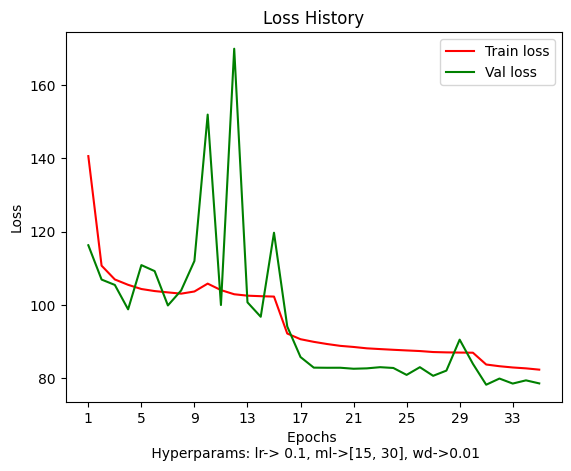

[Epoch: 36, Iteration:     1]  training loss: 83.622
[Epoch: 36, Iteration:   201]  training loss: 84.741
[Epoch: 36, Iteration:   401]  training loss: 84.492
[Epoch: 36, Iteration:   601]  training loss: 78.318
[Epoch: 36, Iteration:     1]  validation loss: 77.933
[Epoch: 37, Iteration:     1]  training loss: 80.469
[Epoch: 37, Iteration:   201]  training loss: 87.237
[Epoch: 37, Iteration:   401]  training loss: 81.709
[Epoch: 37, Iteration:   601]  training loss: 80.626
[Epoch: 37, Iteration:     1]  validation loss: 80.362
[Epoch: 38, Iteration:     1]  training loss: 85.573
[Epoch: 38, Iteration:   201]  training loss: 82.847
[Epoch: 38, Iteration:   401]  training loss: 80.158
[Epoch: 38, Iteration:   601]  training loss: 84.070
[Epoch: 38, Iteration:     1]  validation loss: 77.374
[Epoch: 39, Iteration:     1]  training loss: 88.695
[Epoch: 39, Iteration:   201]  training loss: 82.720
[Epoch: 39, Iteration:   401]  training loss: 82.145
[Epoch: 39, Iteration:   601]  training 

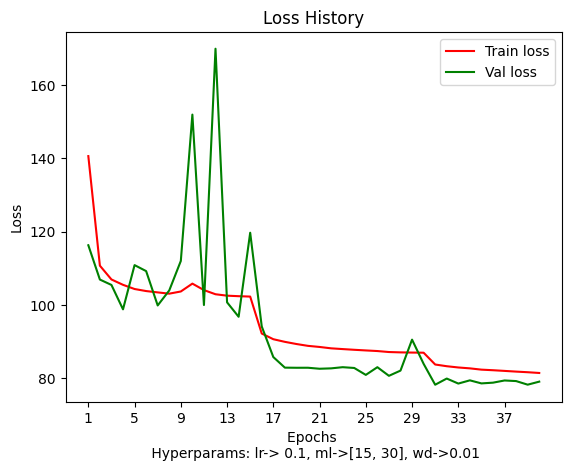

 44%|████▍     | 8/18 [2:12:07<2:47:22, 1004.28s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 560.165
[Epoch: 1, Iteration:   201]  training loss: 142.253
[Epoch: 1, Iteration:   401]  training loss: 116.854
[Epoch: 1, Iteration:   601]  training loss: 114.597
[Epoch: 1, Iteration:     1]  validation loss: 107.869
[Epoch: 2, Iteration:     1]  training loss: 117.395
[Epoch: 2, Iteration:   201]  training loss: 100.365
[Epoch: 2, Iteration:   401]  training loss: 106.120
[Epoch: 2, Iteration:   601]  training loss: 105.076
[Epoch: 2, Iteration:     1]  validation loss: 94.031
[Epoch: 3, Iteration:     1]  training loss: 95.825
[Epoch: 3, Iteration:   201]  training loss: 96.145
[Epoch: 3, Iteration:   401]  training loss: 102.704
[Epoch: 3, Iteration:   601]  training loss: 94.765
[Epoch: 3, Iteration:     1]  validation loss: 98.437
[Epoch: 4, Iteration:     1]  training loss: 98.914
[Epoch: 4, Iteration:   201]  training loss: 94.208
[Epoch: 4, Iteration:   401]  training loss: 99.

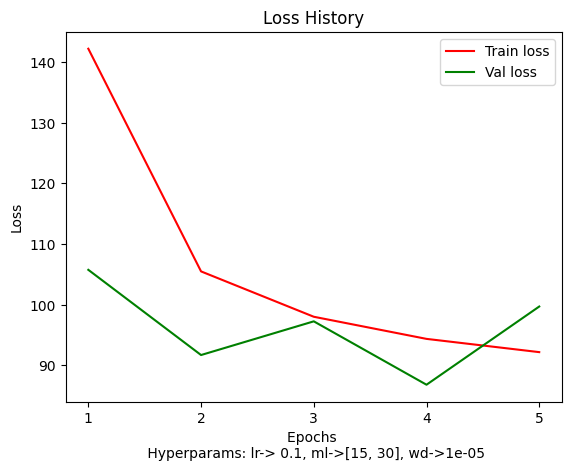

[Epoch: 6, Iteration:     1]  training loss: 97.731
[Epoch: 6, Iteration:   201]  training loss: 90.445
[Epoch: 6, Iteration:   401]  training loss: 88.826
[Epoch: 6, Iteration:   601]  training loss: 92.875
[Epoch: 6, Iteration:     1]  validation loss: 88.697
[Epoch: 7, Iteration:     1]  training loss: 99.615
[Epoch: 7, Iteration:   201]  training loss: 84.638
[Epoch: 7, Iteration:   401]  training loss: 89.712
[Epoch: 7, Iteration:   601]  training loss: 87.510
[Epoch: 7, Iteration:     1]  validation loss: 83.061
[Epoch: 8, Iteration:     1]  training loss: 90.218
[Epoch: 8, Iteration:   201]  training loss: 89.638
[Epoch: 8, Iteration:   401]  training loss: 91.882
[Epoch: 8, Iteration:   601]  training loss: 93.904
[Epoch: 8, Iteration:     1]  validation loss: 84.520
[Epoch: 9, Iteration:     1]  training loss: 94.365
[Epoch: 9, Iteration:   201]  training loss: 87.444
[Epoch: 9, Iteration:   401]  training loss: 87.094
[Epoch: 9, Iteration:   601]  training loss: 87.558
[Epoch

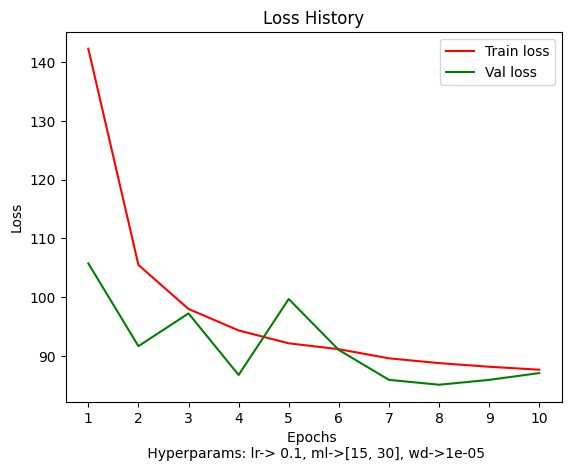

[Epoch: 11, Iteration:     1]  training loss: 87.957
[Epoch: 11, Iteration:   201]  training loss: 84.047
[Epoch: 11, Iteration:   401]  training loss: 85.791
[Epoch: 11, Iteration:   601]  training loss: 80.593
[Epoch: 11, Iteration:     1]  validation loss: 79.612
[Epoch: 12, Iteration:     1]  training loss: 86.404
[Epoch: 12, Iteration:   201]  training loss: 88.547
[Epoch: 12, Iteration:   401]  training loss: 88.180
[Epoch: 12, Iteration:   601]  training loss: 83.870
[Epoch: 12, Iteration:     1]  validation loss: 84.855
[Epoch: 13, Iteration:     1]  training loss: 84.186
[Epoch: 13, Iteration:   201]  training loss: 86.135
[Epoch: 13, Iteration:   401]  training loss: 83.988
[Epoch: 13, Iteration:   601]  training loss: 86.614
[Epoch: 13, Iteration:     1]  validation loss: 83.763
[Epoch: 14, Iteration:     1]  training loss: 88.138
[Epoch: 14, Iteration:   201]  training loss: 88.096
[Epoch: 14, Iteration:   401]  training loss: 87.909
[Epoch: 14, Iteration:   601]  training 

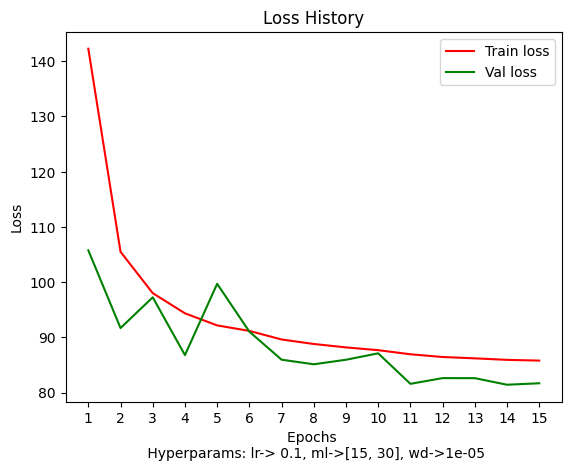

[Epoch: 16, Iteration:     1]  training loss: 86.497
[Epoch: 16, Iteration:   201]  training loss: 79.857
[Epoch: 16, Iteration:   401]  training loss: 79.531
[Epoch: 16, Iteration:   601]  training loss: 89.061
[Epoch: 16, Iteration:     1]  validation loss: 77.937
[Epoch: 17, Iteration:     1]  training loss: 77.753
[Epoch: 17, Iteration:   201]  training loss: 81.047
[Epoch: 17, Iteration:   401]  training loss: 79.430
[Epoch: 17, Iteration:   601]  training loss: 81.469
[Epoch: 17, Iteration:     1]  validation loss: 75.214
[Epoch: 18, Iteration:     1]  training loss: 79.532
[Epoch: 18, Iteration:   201]  training loss: 82.214
[Epoch: 18, Iteration:   401]  training loss: 77.129
[Epoch: 18, Iteration:   601]  training loss: 83.288
[Epoch: 18, Iteration:     1]  validation loss: 83.743
[Epoch: 19, Iteration:     1]  training loss: 83.483
[Epoch: 19, Iteration:   201]  training loss: 81.080
[Epoch: 19, Iteration:   401]  training loss: 80.963
[Epoch: 19, Iteration:   601]  training 

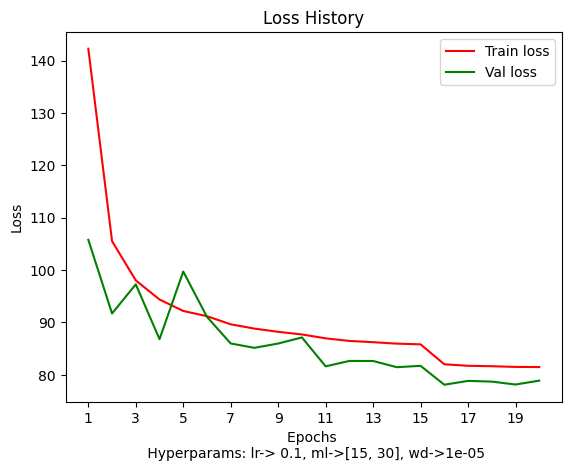

[Epoch: 21, Iteration:     1]  training loss: 83.214
[Epoch: 21, Iteration:   201]  training loss: 86.578
[Epoch: 21, Iteration:   401]  training loss: 81.255
[Epoch: 21, Iteration:   601]  training loss: 82.301
[Epoch: 21, Iteration:     1]  validation loss: 75.447
[Epoch: 22, Iteration:     1]  training loss: 79.615
[Epoch: 22, Iteration:   201]  training loss: 79.455
[Epoch: 22, Iteration:   401]  training loss: 81.301
[Epoch: 22, Iteration:   601]  training loss: 84.845
[Epoch: 22, Iteration:     1]  validation loss: 73.157
[Epoch: 23, Iteration:     1]  training loss: 79.926
[Epoch: 23, Iteration:   201]  training loss: 75.324
[Epoch: 23, Iteration:   401]  training loss: 79.060
[Epoch: 23, Iteration:   601]  training loss: 81.598
[Epoch: 23, Iteration:     1]  validation loss: 75.844
[Epoch: 24, Iteration:     1]  training loss: 79.900
[Epoch: 24, Iteration:   201]  training loss: 80.169
[Epoch: 24, Iteration:   401]  training loss: 80.885
[Epoch: 24, Iteration:   601]  training 

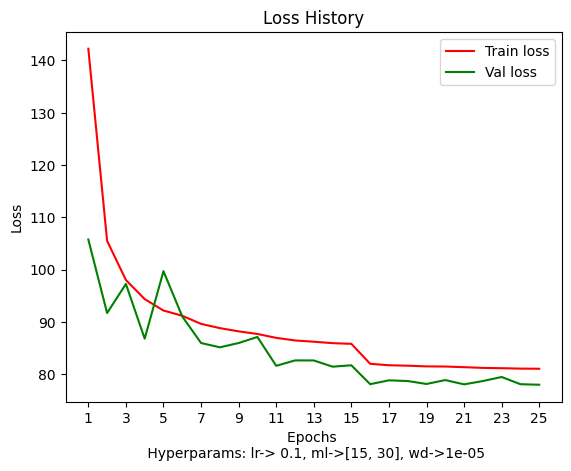

[Epoch: 26, Iteration:     1]  training loss: 84.809
[Epoch: 26, Iteration:   201]  training loss: 76.472
[Epoch: 26, Iteration:   401]  training loss: 80.807
[Epoch: 26, Iteration:   601]  training loss: 80.806
[Epoch: 26, Iteration:     1]  validation loss: 80.290
[Epoch: 27, Iteration:     1]  training loss: 81.747
[Epoch: 27, Iteration:   201]  training loss: 77.162
[Epoch: 27, Iteration:   401]  training loss: 82.113
[Epoch: 27, Iteration:   601]  training loss: 75.345
[Epoch: 27, Iteration:     1]  validation loss: 77.894
[Epoch: 28, Iteration:     1]  training loss: 77.307
[Epoch: 28, Iteration:   201]  training loss: 81.680
[Epoch: 28, Iteration:   401]  training loss: 81.081
[Epoch: 28, Iteration:   601]  training loss: 78.295
[Epoch: 28, Iteration:     1]  validation loss: 79.963
[Epoch: 29, Iteration:     1]  training loss: 83.327
[Epoch: 29, Iteration:   201]  training loss: 81.136
[Epoch: 29, Iteration:   401]  training loss: 81.738
[Epoch: 29, Iteration:   601]  training 

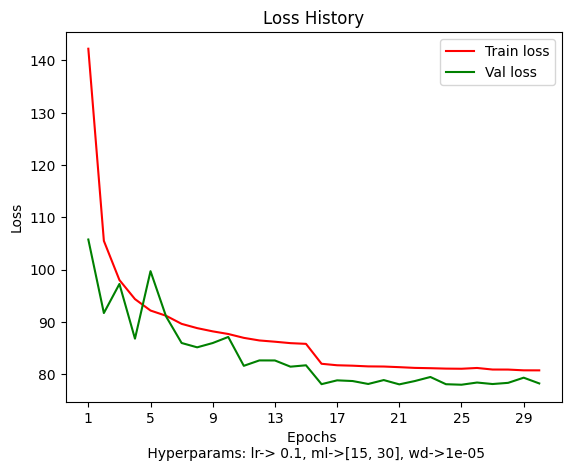

[Epoch: 31, Iteration:     1]  training loss: 82.276
[Epoch: 31, Iteration:   201]  training loss: 79.471
[Epoch: 31, Iteration:   401]  training loss: 80.128
[Epoch: 31, Iteration:   601]  training loss: 77.800
[Epoch: 31, Iteration:     1]  validation loss: 75.826
[Epoch: 32, Iteration:     1]  training loss: 77.630
[Epoch: 32, Iteration:   201]  training loss: 81.439
[Epoch: 32, Iteration:   401]  training loss: 82.668
[Epoch: 32, Iteration:   601]  training loss: 79.614
[Epoch: 32, Iteration:     1]  validation loss: 81.671
[Epoch: 33, Iteration:     1]  training loss: 82.567
[Epoch: 33, Iteration:   201]  training loss: 78.381
[Epoch: 33, Iteration:   401]  training loss: 77.703
[Epoch: 33, Iteration:   601]  training loss: 80.845
[Epoch: 33, Iteration:     1]  validation loss: 75.181
[Epoch: 34, Iteration:     1]  training loss: 83.766
[Epoch: 34, Iteration:   201]  training loss: 82.131
[Epoch: 34, Iteration:   401]  training loss: 81.856
[Epoch: 34, Iteration:   601]  training 

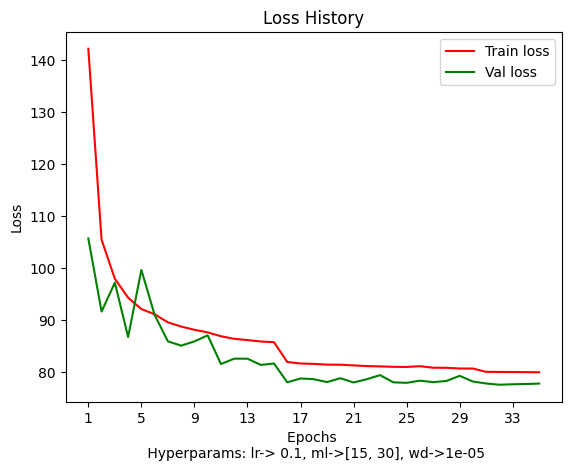

[Epoch: 36, Iteration:     1]  training loss: 76.970
[Epoch: 36, Iteration:   201]  training loss: 82.163
[Epoch: 36, Iteration:   401]  training loss: 82.561
[Epoch: 36, Iteration:   601]  training loss: 77.284
[Epoch: 36, Iteration:     1]  validation loss: 79.312
[Epoch: 37, Iteration:     1]  training loss: 80.946
[Epoch: 37, Iteration:   201]  training loss: 81.394
[Epoch: 37, Iteration:   401]  training loss: 80.618
[Epoch: 37, Iteration:   601]  training loss: 83.098
[Epoch: 37, Iteration:     1]  validation loss: 78.596
[Epoch: 38, Iteration:     1]  training loss: 83.585
[Epoch: 38, Iteration:   201]  training loss: 81.600
[Epoch: 38, Iteration:   401]  training loss: 81.759
[Epoch: 38, Iteration:   601]  training loss: 81.213
[Epoch: 38, Iteration:     1]  validation loss: 78.867
[Epoch: 39, Iteration:     1]  training loss: 75.703
[Epoch: 39, Iteration:   201]  training loss: 83.649
[Epoch: 39, Iteration:   401]  training loss: 75.885
[Epoch: 39, Iteration:   601]  training 

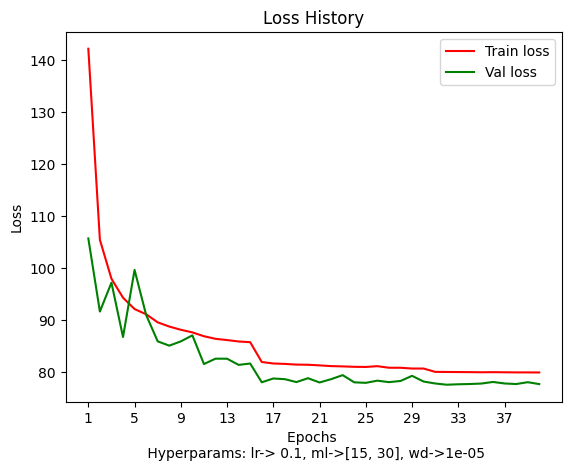

 50%|█████     | 9/18 [2:29:17<2:31:51, 1012.33s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 562.235
[Epoch: 1, Iteration:   201]  training loss: 151.818
[Epoch: 1, Iteration:   401]  training loss: 120.418
[Epoch: 1, Iteration:   601]  training loss: 114.074
[Epoch: 1, Iteration:     1]  validation loss: 109.159
[Epoch: 2, Iteration:     1]  training loss: 111.126
[Epoch: 2, Iteration:   201]  training loss: 107.924
[Epoch: 2, Iteration:   401]  training loss: 103.271
[Epoch: 2, Iteration:   601]  training loss: 96.353
[Epoch: 2, Iteration:     1]  validation loss: 97.380
[Epoch: 3, Iteration:     1]  training loss: 100.553
[Epoch: 3, Iteration:   201]  training loss: 99.085
[Epoch: 3, Iteration:   401]  training loss: 98.083
[Epoch: 3, Iteration:   601]  training loss: 95.789
[Epoch: 3, Iteration:     1]  validation loss: 97.944
[Epoch: 4, Iteration:     1]  training loss: 97.594
[Epoch: 4, Iteration:   201]  training loss: 95.314
[Epoch: 4, Iteration:   401]  training loss: 93.5

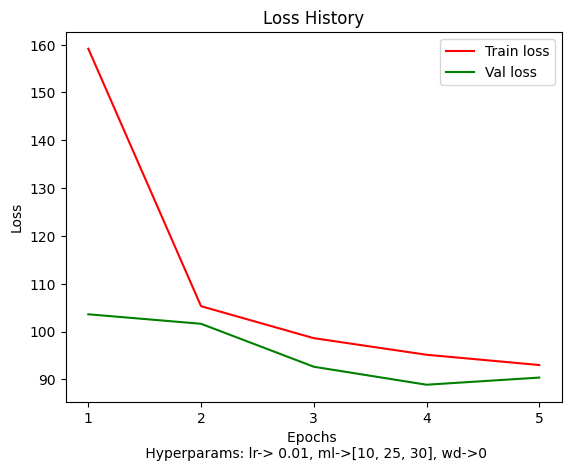

[Epoch: 6, Iteration:     1]  training loss: 93.727
[Epoch: 6, Iteration:   201]  training loss: 90.431
[Epoch: 6, Iteration:   401]  training loss: 94.240
[Epoch: 6, Iteration:   601]  training loss: 93.970
[Epoch: 6, Iteration:     1]  validation loss: 89.105
[Epoch: 7, Iteration:     1]  training loss: 93.559
[Epoch: 7, Iteration:   201]  training loss: 88.847
[Epoch: 7, Iteration:   401]  training loss: 89.071
[Epoch: 7, Iteration:   601]  training loss: 93.337
[Epoch: 7, Iteration:     1]  validation loss: 90.787
[Epoch: 8, Iteration:     1]  training loss: 89.824
[Epoch: 8, Iteration:   201]  training loss: 89.118
[Epoch: 8, Iteration:   401]  training loss: 88.385
[Epoch: 8, Iteration:   601]  training loss: 92.222
[Epoch: 8, Iteration:     1]  validation loss: 87.604
[Epoch: 9, Iteration:     1]  training loss: 85.547
[Epoch: 9, Iteration:   201]  training loss: 87.647
[Epoch: 9, Iteration:   401]  training loss: 88.803
[Epoch: 9, Iteration:   601]  training loss: 85.256
[Epoch

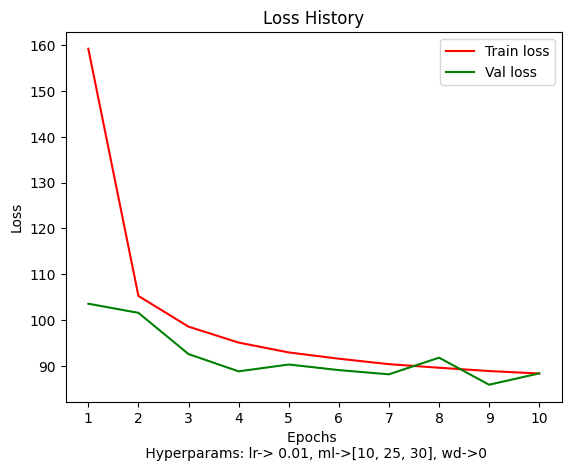

[Epoch: 11, Iteration:     1]  training loss: 90.479
[Epoch: 11, Iteration:   201]  training loss: 86.192
[Epoch: 11, Iteration:   401]  training loss: 84.728
[Epoch: 11, Iteration:   601]  training loss: 78.472
[Epoch: 11, Iteration:     1]  validation loss: 89.837
[Epoch: 12, Iteration:     1]  training loss: 87.018
[Epoch: 12, Iteration:   201]  training loss: 85.112
[Epoch: 12, Iteration:   401]  training loss: 86.110
[Epoch: 12, Iteration:   601]  training loss: 83.628
[Epoch: 12, Iteration:     1]  validation loss: 82.794
[Epoch: 13, Iteration:     1]  training loss: 88.115
[Epoch: 13, Iteration:   201]  training loss: 84.107
[Epoch: 13, Iteration:   401]  training loss: 86.450
[Epoch: 13, Iteration:   601]  training loss: 88.777
[Epoch: 13, Iteration:     1]  validation loss: 83.579
[Epoch: 14, Iteration:     1]  training loss: 87.199
[Epoch: 14, Iteration:   201]  training loss: 83.317
[Epoch: 14, Iteration:   401]  training loss: 84.082
[Epoch: 14, Iteration:   601]  training 

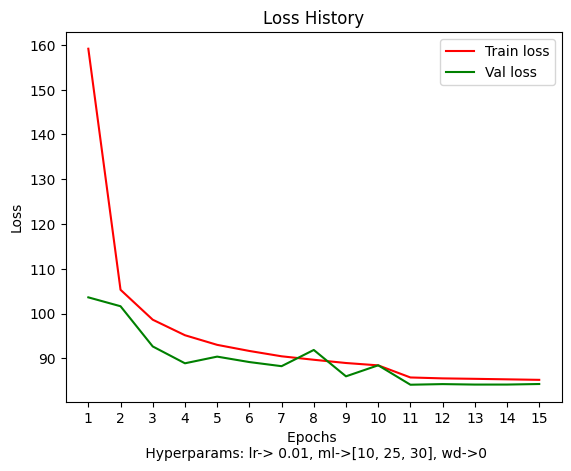

[Epoch: 16, Iteration:     1]  training loss: 84.882
[Epoch: 16, Iteration:   201]  training loss: 80.486
[Epoch: 16, Iteration:   401]  training loss: 83.695
[Epoch: 16, Iteration:   601]  training loss: 82.541
[Epoch: 16, Iteration:     1]  validation loss: 83.565
[Epoch: 17, Iteration:     1]  training loss: 82.936
[Epoch: 17, Iteration:   201]  training loss: 86.400
[Epoch: 17, Iteration:   401]  training loss: 83.541
[Epoch: 17, Iteration:   601]  training loss: 89.230
[Epoch: 17, Iteration:     1]  validation loss: 84.152
[Epoch: 18, Iteration:     1]  training loss: 89.328
[Epoch: 18, Iteration:   201]  training loss: 86.802
[Epoch: 18, Iteration:   401]  training loss: 87.103
[Epoch: 18, Iteration:   601]  training loss: 90.364
[Epoch: 18, Iteration:     1]  validation loss: 84.115
[Epoch: 19, Iteration:     1]  training loss: 85.902
[Epoch: 19, Iteration:   201]  training loss: 85.234
[Epoch: 19, Iteration:   401]  training loss: 86.276
[Epoch: 19, Iteration:   601]  training 

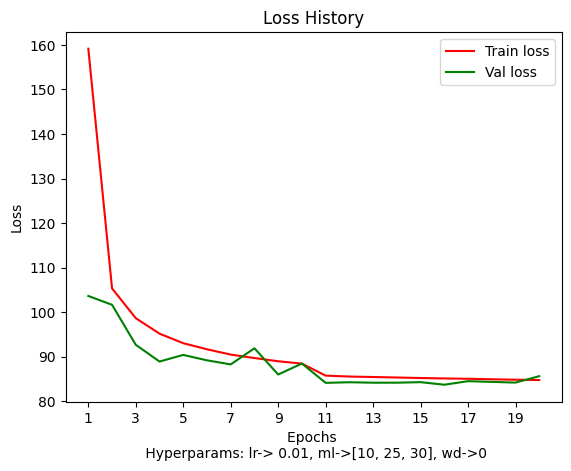

[Epoch: 21, Iteration:     1]  training loss: 86.373
[Epoch: 21, Iteration:   201]  training loss: 82.935
[Epoch: 21, Iteration:   401]  training loss: 84.309
[Epoch: 21, Iteration:   601]  training loss: 84.762
[Epoch: 21, Iteration:     1]  validation loss: 82.177
[Epoch: 22, Iteration:     1]  training loss: 83.604
[Epoch: 22, Iteration:   201]  training loss: 79.457
[Epoch: 22, Iteration:   401]  training loss: 83.034
[Epoch: 22, Iteration:   601]  training loss: 80.676
[Epoch: 22, Iteration:     1]  validation loss: 85.816
[Epoch: 23, Iteration:     1]  training loss: 87.503
[Epoch: 23, Iteration:   201]  training loss: 82.265
[Epoch: 23, Iteration:   401]  training loss: 86.376
[Epoch: 23, Iteration:   601]  training loss: 81.167
[Epoch: 23, Iteration:     1]  validation loss: 82.200
[Epoch: 24, Iteration:     1]  training loss: 84.736
[Epoch: 24, Iteration:   201]  training loss: 80.745
[Epoch: 24, Iteration:   401]  training loss: 81.273
[Epoch: 24, Iteration:   601]  training 

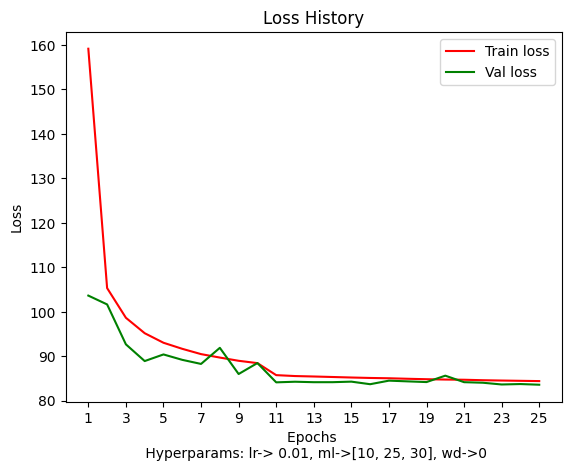

[Epoch: 26, Iteration:     1]  training loss: 83.875
[Epoch: 26, Iteration:   201]  training loss: 83.628
[Epoch: 26, Iteration:   401]  training loss: 87.145
[Epoch: 26, Iteration:   601]  training loss: 81.911
[Epoch: 26, Iteration:     1]  validation loss: 85.041
[Epoch: 27, Iteration:     1]  training loss: 86.887
[Epoch: 27, Iteration:   201]  training loss: 85.517
[Epoch: 27, Iteration:   401]  training loss: 86.640
[Epoch: 27, Iteration:   601]  training loss: 79.975
[Epoch: 27, Iteration:     1]  validation loss: 83.655
[Epoch: 28, Iteration:     1]  training loss: 82.456
[Epoch: 28, Iteration:   201]  training loss: 85.115
[Epoch: 28, Iteration:   401]  training loss: 81.934
[Epoch: 28, Iteration:   601]  training loss: 88.566
[Epoch: 28, Iteration:     1]  validation loss: 84.783
[Epoch: 29, Iteration:     1]  training loss: 86.402
[Epoch: 29, Iteration:   201]  training loss: 82.951
[Epoch: 29, Iteration:   401]  training loss: 82.385
[Epoch: 29, Iteration:   601]  training 

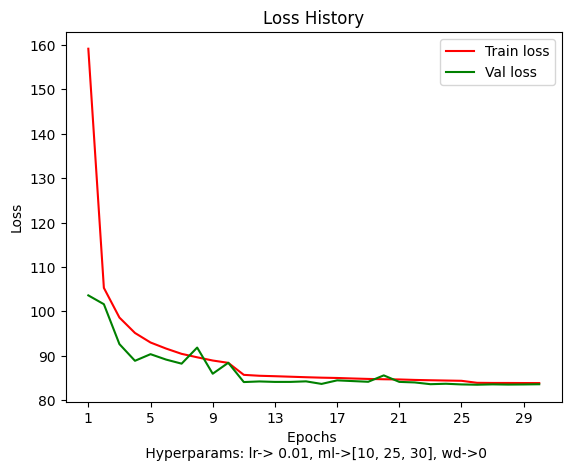

[Epoch: 31, Iteration:     1]  training loss: 83.095
[Epoch: 31, Iteration:   201]  training loss: 84.774
[Epoch: 31, Iteration:   401]  training loss: 82.470
[Epoch: 31, Iteration:   601]  training loss: 86.591
[Epoch: 31, Iteration:     1]  validation loss: 82.704
[Epoch: 32, Iteration:     1]  training loss: 82.241
[Epoch: 32, Iteration:   201]  training loss: 83.572
[Epoch: 32, Iteration:   401]  training loss: 86.236
[Epoch: 32, Iteration:   601]  training loss: 81.942
[Epoch: 32, Iteration:     1]  validation loss: 84.231
[Epoch: 33, Iteration:     1]  training loss: 80.405
[Epoch: 33, Iteration:   201]  training loss: 81.467
[Epoch: 33, Iteration:   401]  training loss: 87.076
[Epoch: 33, Iteration:   601]  training loss: 82.502
[Epoch: 33, Iteration:     1]  validation loss: 86.250
[Epoch: 34, Iteration:     1]  training loss: 77.574
[Epoch: 34, Iteration:   201]  training loss: 86.637
[Epoch: 34, Iteration:   401]  training loss: 84.085
[Epoch: 34, Iteration:   601]  training 

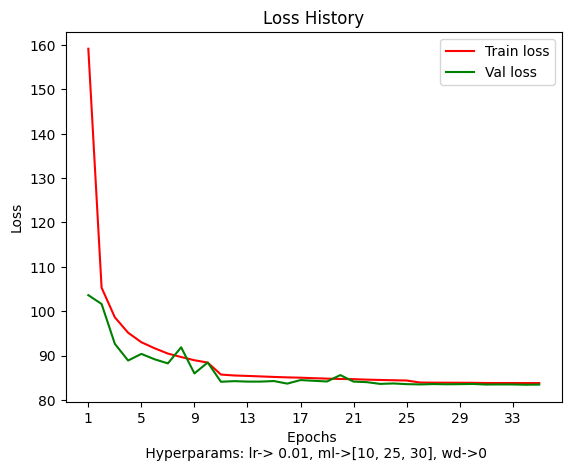

[Epoch: 36, Iteration:     1]  training loss: 81.392
[Epoch: 36, Iteration:   201]  training loss: 86.540
[Epoch: 36, Iteration:   401]  training loss: 85.576
[Epoch: 36, Iteration:   601]  training loss: 80.954
[Epoch: 36, Iteration:     1]  validation loss: 83.044
[Epoch: 37, Iteration:     1]  training loss: 78.685
[Epoch: 37, Iteration:   201]  training loss: 83.848
[Epoch: 37, Iteration:   401]  training loss: 82.168
[Epoch: 37, Iteration:   601]  training loss: 86.491
[Epoch: 37, Iteration:     1]  validation loss: 85.477
[Epoch: 38, Iteration:     1]  training loss: 79.739
[Epoch: 38, Iteration:   201]  training loss: 81.723
[Epoch: 38, Iteration:   401]  training loss: 78.710
[Epoch: 38, Iteration:   601]  training loss: 84.387
[Epoch: 38, Iteration:     1]  validation loss: 83.037
[Epoch: 39, Iteration:     1]  training loss: 84.482
[Epoch: 39, Iteration:   201]  training loss: 88.808
[Epoch: 39, Iteration:   401]  training loss: 85.257
[Epoch: 39, Iteration:   601]  training 

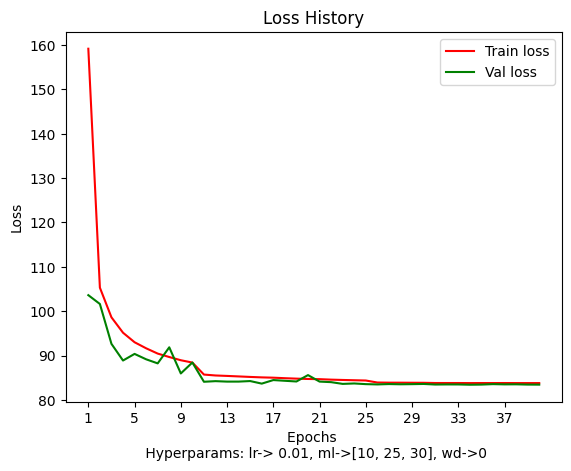

 56%|█████▌    | 10/18 [2:47:07<2:17:20, 1030.08s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 554.859
[Epoch: 1, Iteration:   201]  training loss: 158.248
[Epoch: 1, Iteration:   401]  training loss: 131.821
[Epoch: 1, Iteration:   601]  training loss: 119.784
[Epoch: 1, Iteration:     1]  validation loss: 109.545
[Epoch: 2, Iteration:     1]  training loss: 117.076
[Epoch: 2, Iteration:   201]  training loss: 110.420
[Epoch: 2, Iteration:   401]  training loss: 105.712
[Epoch: 2, Iteration:   601]  training loss: 101.201
[Epoch: 2, Iteration:     1]  validation loss: 99.873
[Epoch: 3, Iteration:     1]  training loss: 101.537
[Epoch: 3, Iteration:   201]  training loss: 101.540
[Epoch: 3, Iteration:   401]  training loss: 99.378
[Epoch: 3, Iteration:   601]  training loss: 100.948
[Epoch: 3, Iteration:     1]  validation loss: 98.398
[Epoch: 4, Iteration:     1]  training loss: 97.524
[Epoch: 4, Iteration:   201]  training loss: 98.986
[Epoch: 4, Iteration:   401]  training loss: 9

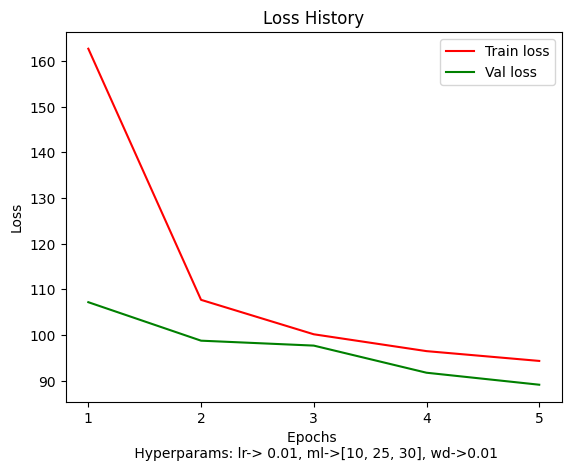

[Epoch: 6, Iteration:     1]  training loss: 91.432
[Epoch: 6, Iteration:   201]  training loss: 102.026
[Epoch: 6, Iteration:   401]  training loss: 96.885
[Epoch: 6, Iteration:   601]  training loss: 90.634
[Epoch: 6, Iteration:     1]  validation loss: 89.375
[Epoch: 7, Iteration:     1]  training loss: 95.388
[Epoch: 7, Iteration:   201]  training loss: 90.222
[Epoch: 7, Iteration:   401]  training loss: 89.000
[Epoch: 7, Iteration:   601]  training loss: 96.833
[Epoch: 7, Iteration:     1]  validation loss: 89.218
[Epoch: 8, Iteration:     1]  training loss: 89.334
[Epoch: 8, Iteration:   201]  training loss: 92.960
[Epoch: 8, Iteration:   401]  training loss: 89.155
[Epoch: 8, Iteration:   601]  training loss: 92.880
[Epoch: 8, Iteration:     1]  validation loss: 90.521
[Epoch: 9, Iteration:     1]  training loss: 92.435
[Epoch: 9, Iteration:   201]  training loss: 84.134
[Epoch: 9, Iteration:   401]  training loss: 88.138
[Epoch: 9, Iteration:   601]  training loss: 88.915
[Epoc

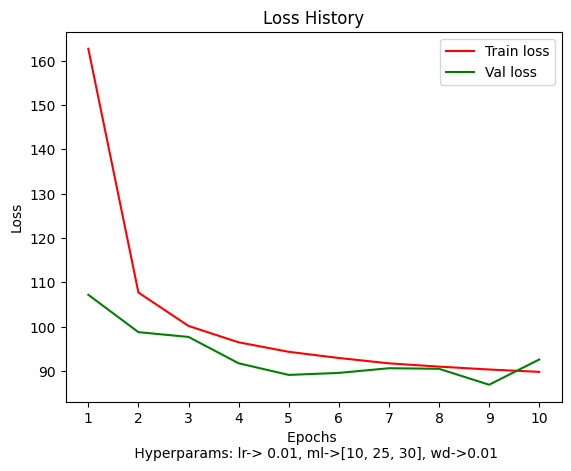

[Epoch: 11, Iteration:     1]  training loss: 90.686
[Epoch: 11, Iteration:   201]  training loss: 86.464
[Epoch: 11, Iteration:   401]  training loss: 84.538
[Epoch: 11, Iteration:   601]  training loss: 88.398
[Epoch: 11, Iteration:     1]  validation loss: 86.046
[Epoch: 12, Iteration:     1]  training loss: 85.218
[Epoch: 12, Iteration:   201]  training loss: 85.038
[Epoch: 12, Iteration:   401]  training loss: 86.929
[Epoch: 12, Iteration:   601]  training loss: 83.776
[Epoch: 12, Iteration:     1]  validation loss: 81.217
[Epoch: 13, Iteration:     1]  training loss: 84.839
[Epoch: 13, Iteration:   201]  training loss: 79.013
[Epoch: 13, Iteration:   401]  training loss: 84.241
[Epoch: 13, Iteration:   601]  training loss: 84.478
[Epoch: 13, Iteration:     1]  validation loss: 82.386
[Epoch: 14, Iteration:     1]  training loss: 83.019
[Epoch: 14, Iteration:   201]  training loss: 80.008
[Epoch: 14, Iteration:   401]  training loss: 88.129
[Epoch: 14, Iteration:   601]  training 

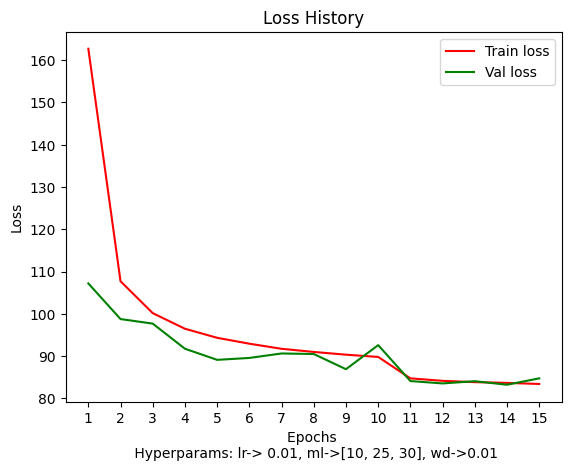

[Epoch: 16, Iteration:     1]  training loss: 78.986
[Epoch: 16, Iteration:   201]  training loss: 79.487
[Epoch: 16, Iteration:   401]  training loss: 83.947
[Epoch: 16, Iteration:   601]  training loss: 85.673
[Epoch: 16, Iteration:     1]  validation loss: 86.043
[Epoch: 17, Iteration:     1]  training loss: 82.183
[Epoch: 17, Iteration:   201]  training loss: 79.473
[Epoch: 17, Iteration:   401]  training loss: 87.548
[Epoch: 17, Iteration:   601]  training loss: 83.186
[Epoch: 17, Iteration:     1]  validation loss: 80.625
[Epoch: 18, Iteration:     1]  training loss: 83.482
[Epoch: 18, Iteration:   201]  training loss: 82.655
[Epoch: 18, Iteration:   401]  training loss: 82.845
[Epoch: 18, Iteration:   601]  training loss: 81.964
[Epoch: 18, Iteration:     1]  validation loss: 85.308
[Epoch: 19, Iteration:     1]  training loss: 79.874
[Epoch: 19, Iteration:   201]  training loss: 79.594
[Epoch: 19, Iteration:   401]  training loss: 84.012
[Epoch: 19, Iteration:   601]  training 

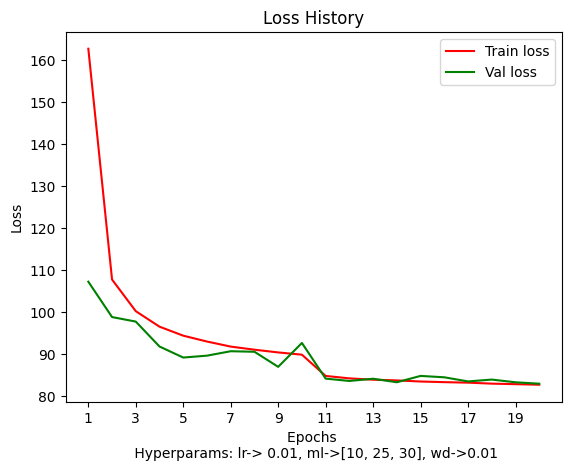

[Epoch: 21, Iteration:     1]  training loss: 78.838
[Epoch: 21, Iteration:   201]  training loss: 81.855
[Epoch: 21, Iteration:   401]  training loss: 82.808
[Epoch: 21, Iteration:   601]  training loss: 85.020
[Epoch: 21, Iteration:     1]  validation loss: 80.678
[Epoch: 22, Iteration:     1]  training loss: 83.521
[Epoch: 22, Iteration:   201]  training loss: 81.665
[Epoch: 22, Iteration:   401]  training loss: 84.477
[Epoch: 22, Iteration:   601]  training loss: 82.537
[Epoch: 22, Iteration:     1]  validation loss: 83.915
[Epoch: 23, Iteration:     1]  training loss: 88.004
[Epoch: 23, Iteration:   201]  training loss: 84.809
[Epoch: 23, Iteration:   401]  training loss: 83.836
[Epoch: 23, Iteration:   601]  training loss: 85.112
[Epoch: 23, Iteration:     1]  validation loss: 79.008
[Epoch: 24, Iteration:     1]  training loss: 84.513
[Epoch: 24, Iteration:   201]  training loss: 85.539
[Epoch: 24, Iteration:   401]  training loss: 83.056
[Epoch: 24, Iteration:   601]  training 

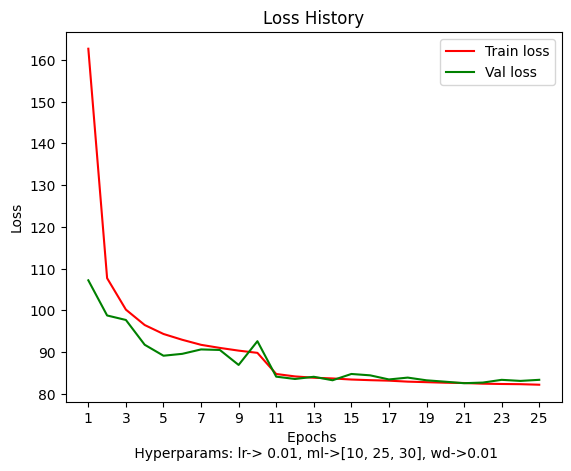

[Epoch: 26, Iteration:     1]  training loss: 80.768
[Epoch: 26, Iteration:   201]  training loss: 78.644
[Epoch: 26, Iteration:   401]  training loss: 79.664
[Epoch: 26, Iteration:   601]  training loss: 84.616
[Epoch: 26, Iteration:     1]  validation loss: 84.764
[Epoch: 27, Iteration:     1]  training loss: 81.098
[Epoch: 27, Iteration:   201]  training loss: 82.662
[Epoch: 27, Iteration:   401]  training loss: 86.859
[Epoch: 27, Iteration:   601]  training loss: 83.039
[Epoch: 27, Iteration:     1]  validation loss: 81.138
[Epoch: 28, Iteration:     1]  training loss: 84.857
[Epoch: 28, Iteration:   201]  training loss: 80.267
[Epoch: 28, Iteration:   401]  training loss: 79.814
[Epoch: 28, Iteration:   601]  training loss: 78.708
[Epoch: 28, Iteration:     1]  validation loss: 77.293
[Epoch: 29, Iteration:     1]  training loss: 83.492
[Epoch: 29, Iteration:   201]  training loss: 86.703
[Epoch: 29, Iteration:   401]  training loss: 81.970
[Epoch: 29, Iteration:   601]  training 

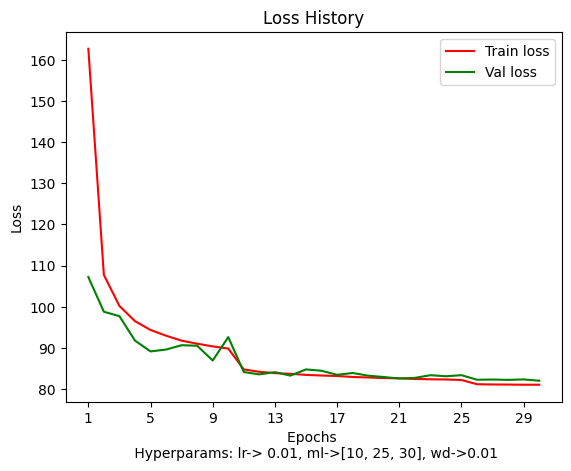

[Epoch: 31, Iteration:     1]  training loss: 83.568
[Epoch: 31, Iteration:   201]  training loss: 81.184
[Epoch: 31, Iteration:   401]  training loss: 74.061
[Epoch: 31, Iteration:   601]  training loss: 90.947
[Epoch: 31, Iteration:     1]  validation loss: 86.113
[Epoch: 32, Iteration:     1]  training loss: 79.227
[Epoch: 32, Iteration:   201]  training loss: 88.457
[Epoch: 32, Iteration:   401]  training loss: 77.508
[Epoch: 32, Iteration:   601]  training loss: 80.549
[Epoch: 32, Iteration:     1]  validation loss: 83.050
[Epoch: 33, Iteration:     1]  training loss: 79.197
[Epoch: 33, Iteration:   201]  training loss: 82.082
[Epoch: 33, Iteration:   401]  training loss: 80.220
[Epoch: 33, Iteration:   601]  training loss: 80.701
[Epoch: 33, Iteration:     1]  validation loss: 84.925
[Epoch: 34, Iteration:     1]  training loss: 81.496
[Epoch: 34, Iteration:   201]  training loss: 87.385
[Epoch: 34, Iteration:   401]  training loss: 80.967
[Epoch: 34, Iteration:   601]  training 

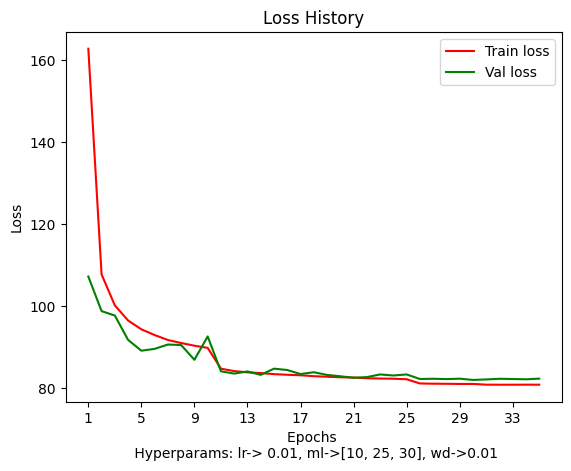

[Epoch: 36, Iteration:     1]  training loss: 81.492
[Epoch: 36, Iteration:   201]  training loss: 76.375
[Epoch: 36, Iteration:   401]  training loss: 78.114
[Epoch: 36, Iteration:   601]  training loss: 72.713
[Epoch: 36, Iteration:     1]  validation loss: 81.926
[Epoch: 37, Iteration:     1]  training loss: 75.576
[Epoch: 37, Iteration:   201]  training loss: 79.626
[Epoch: 37, Iteration:   401]  training loss: 79.859
[Epoch: 37, Iteration:   601]  training loss: 79.071
[Epoch: 37, Iteration:     1]  validation loss: 79.170
[Epoch: 38, Iteration:     1]  training loss: 81.670
[Epoch: 38, Iteration:   201]  training loss: 81.660
[Epoch: 38, Iteration:   401]  training loss: 81.964
[Epoch: 38, Iteration:   601]  training loss: 83.443
[Epoch: 38, Iteration:     1]  validation loss: 85.766
[Epoch: 39, Iteration:     1]  training loss: 79.695
[Epoch: 39, Iteration:   201]  training loss: 79.488
[Epoch: 39, Iteration:   401]  training loss: 83.571
[Epoch: 39, Iteration:   601]  training 

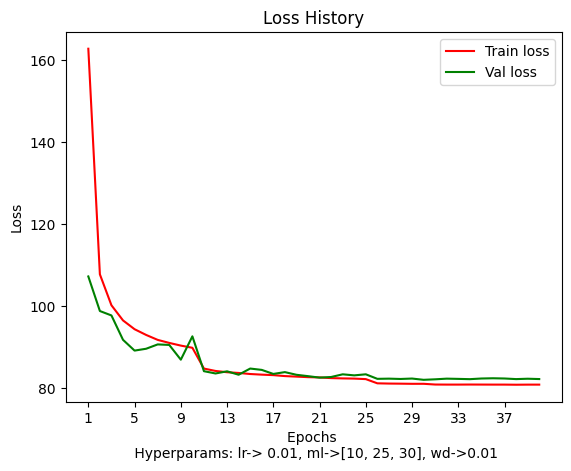

 61%|██████    | 11/18 [3:04:16<2:00:08, 1029.81s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 557.016
[Epoch: 1, Iteration:   201]  training loss: 149.065
[Epoch: 1, Iteration:   401]  training loss: 133.080
[Epoch: 1, Iteration:   601]  training loss: 116.664
[Epoch: 1, Iteration:     1]  validation loss: 115.354
[Epoch: 2, Iteration:     1]  training loss: 118.790
[Epoch: 2, Iteration:   201]  training loss: 113.813
[Epoch: 2, Iteration:   401]  training loss: 117.869
[Epoch: 2, Iteration:   601]  training loss: 108.179
[Epoch: 2, Iteration:     1]  validation loss: 104.715
[Epoch: 3, Iteration:     1]  training loss: 114.017
[Epoch: 3, Iteration:   201]  training loss: 108.131
[Epoch: 3, Iteration:   401]  training loss: 108.892
[Epoch: 3, Iteration:   601]  training loss: 105.980
[Epoch: 3, Iteration:     1]  validation loss: 108.855
[Epoch: 4, Iteration:     1]  training loss: 109.100
[Epoch: 4, Iteration:   201]  training loss: 103.030
[Epoch: 4, Iteration:   401]  training lo

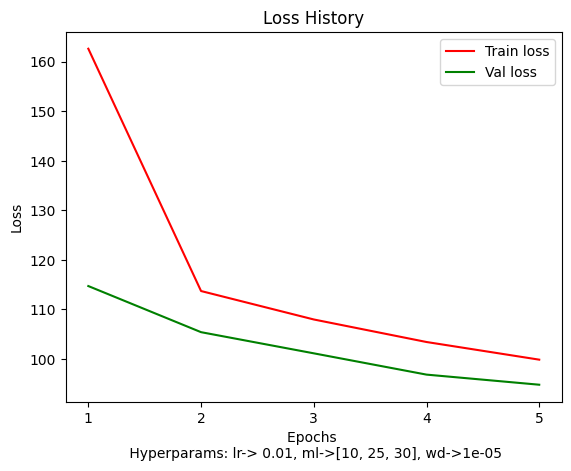

[Epoch: 6, Iteration:     1]  training loss: 93.206
[Epoch: 6, Iteration:   201]  training loss: 101.541
[Epoch: 6, Iteration:   401]  training loss: 98.332
[Epoch: 6, Iteration:   601]  training loss: 99.786
[Epoch: 6, Iteration:     1]  validation loss: 96.928
[Epoch: 7, Iteration:     1]  training loss: 98.285
[Epoch: 7, Iteration:   201]  training loss: 103.941
[Epoch: 7, Iteration:   401]  training loss: 95.598
[Epoch: 7, Iteration:   601]  training loss: 94.146
[Epoch: 7, Iteration:     1]  validation loss: 89.289
[Epoch: 8, Iteration:     1]  training loss: 92.381
[Epoch: 8, Iteration:   201]  training loss: 96.888
[Epoch: 8, Iteration:   401]  training loss: 93.194
[Epoch: 8, Iteration:   601]  training loss: 100.052
[Epoch: 8, Iteration:     1]  validation loss: 92.950
[Epoch: 9, Iteration:     1]  training loss: 93.933
[Epoch: 9, Iteration:   201]  training loss: 92.311
[Epoch: 9, Iteration:   401]  training loss: 94.490
[Epoch: 9, Iteration:   601]  training loss: 95.437
[Ep

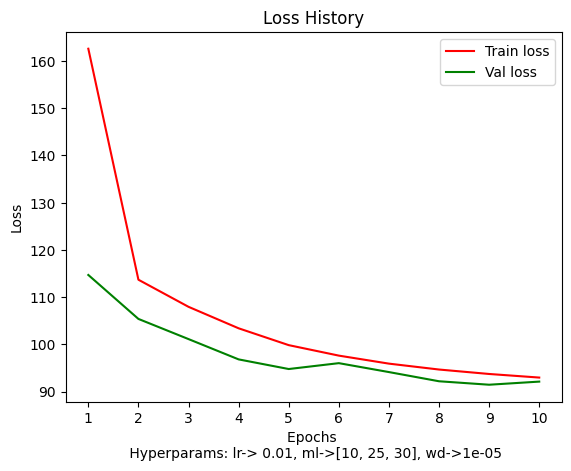

[Epoch: 11, Iteration:     1]  training loss: 91.281
[Epoch: 11, Iteration:   201]  training loss: 85.876
[Epoch: 11, Iteration:   401]  training loss: 92.335
[Epoch: 11, Iteration:   601]  training loss: 85.657
[Epoch: 11, Iteration:     1]  validation loss: 87.599
[Epoch: 12, Iteration:     1]  training loss: 91.298
[Epoch: 12, Iteration:   201]  training loss: 93.336
[Epoch: 12, Iteration:   401]  training loss: 86.276
[Epoch: 12, Iteration:   601]  training loss: 89.513
[Epoch: 12, Iteration:     1]  validation loss: 86.376
[Epoch: 13, Iteration:     1]  training loss: 90.735
[Epoch: 13, Iteration:   201]  training loss: 86.777
[Epoch: 13, Iteration:   401]  training loss: 86.523
[Epoch: 13, Iteration:   601]  training loss: 91.372
[Epoch: 13, Iteration:     1]  validation loss: 91.965
[Epoch: 14, Iteration:     1]  training loss: 88.115
[Epoch: 14, Iteration:   201]  training loss: 84.872
[Epoch: 14, Iteration:   401]  training loss: 87.813
[Epoch: 14, Iteration:   601]  training 

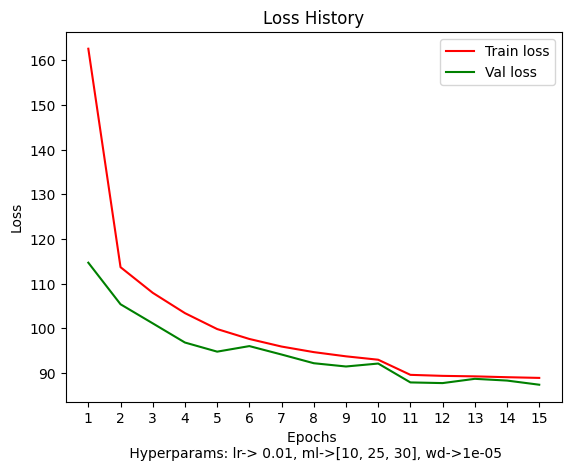

[Epoch: 16, Iteration:     1]  training loss: 88.045
[Epoch: 16, Iteration:   201]  training loss: 89.746
[Epoch: 16, Iteration:   401]  training loss: 86.259
[Epoch: 16, Iteration:   601]  training loss: 90.004
[Epoch: 16, Iteration:     1]  validation loss: 91.231
[Epoch: 17, Iteration:     1]  training loss: 91.271
[Epoch: 17, Iteration:   201]  training loss: 89.109
[Epoch: 17, Iteration:   401]  training loss: 88.904
[Epoch: 17, Iteration:   601]  training loss: 82.879
[Epoch: 17, Iteration:     1]  validation loss: 83.680
[Epoch: 18, Iteration:     1]  training loss: 86.714
[Epoch: 18, Iteration:   201]  training loss: 86.867
[Epoch: 18, Iteration:   401]  training loss: 85.682
[Epoch: 18, Iteration:   601]  training loss: 90.901
[Epoch: 18, Iteration:     1]  validation loss: 88.934
[Epoch: 19, Iteration:     1]  training loss: 92.908
[Epoch: 19, Iteration:   201]  training loss: 86.366
[Epoch: 19, Iteration:   401]  training loss: 88.771
[Epoch: 19, Iteration:   601]  training 

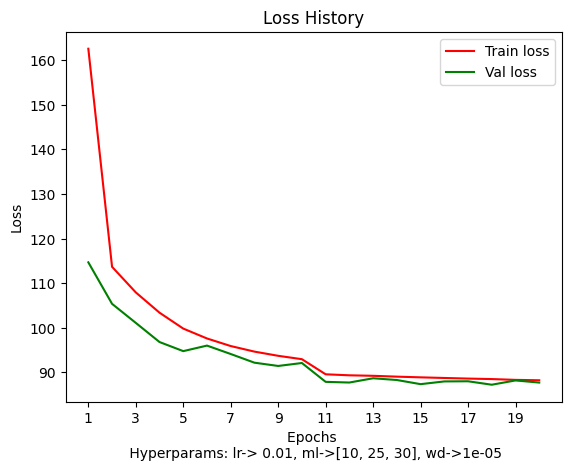

[Epoch: 21, Iteration:     1]  training loss: 91.505
[Epoch: 21, Iteration:   201]  training loss: 91.020
[Epoch: 21, Iteration:   401]  training loss: 90.656
[Epoch: 21, Iteration:   601]  training loss: 85.256
[Epoch: 21, Iteration:     1]  validation loss: 83.622
[Epoch: 22, Iteration:     1]  training loss: 91.236
[Epoch: 22, Iteration:   201]  training loss: 85.679
[Epoch: 22, Iteration:   401]  training loss: 86.659
[Epoch: 22, Iteration:   601]  training loss: 90.533
[Epoch: 22, Iteration:     1]  validation loss: 86.998
[Epoch: 23, Iteration:     1]  training loss: 85.844
[Epoch: 23, Iteration:   201]  training loss: 87.891
[Epoch: 23, Iteration:   401]  training loss: 84.733
[Epoch: 23, Iteration:   601]  training loss: 87.767
[Epoch: 23, Iteration:     1]  validation loss: 87.169
[Epoch: 24, Iteration:     1]  training loss: 86.878
[Epoch: 24, Iteration:   201]  training loss: 88.964
[Epoch: 24, Iteration:   401]  training loss: 84.659
[Epoch: 24, Iteration:   601]  training 

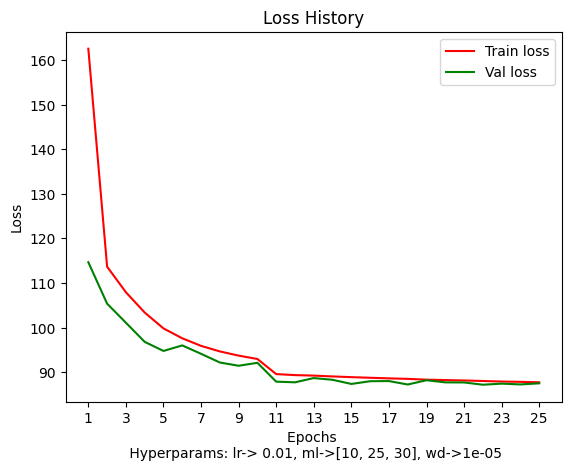

[Epoch: 26, Iteration:     1]  training loss: 85.438
[Epoch: 26, Iteration:   201]  training loss: 85.432
[Epoch: 26, Iteration:   401]  training loss: 84.146
[Epoch: 26, Iteration:   601]  training loss: 84.502
[Epoch: 26, Iteration:     1]  validation loss: 89.094
[Epoch: 27, Iteration:     1]  training loss: 87.455
[Epoch: 27, Iteration:   201]  training loss: 82.339
[Epoch: 27, Iteration:   401]  training loss: 86.292
[Epoch: 27, Iteration:   601]  training loss: 88.056
[Epoch: 27, Iteration:     1]  validation loss: 88.224
[Epoch: 28, Iteration:     1]  training loss: 85.350
[Epoch: 28, Iteration:   201]  training loss: 82.146
[Epoch: 28, Iteration:   401]  training loss: 84.103
[Epoch: 28, Iteration:   601]  training loss: 87.311
[Epoch: 28, Iteration:     1]  validation loss: 88.402
[Epoch: 29, Iteration:     1]  training loss: 86.234
[Epoch: 29, Iteration:   201]  training loss: 84.585
[Epoch: 29, Iteration:   401]  training loss: 83.851
[Epoch: 29, Iteration:   601]  training 

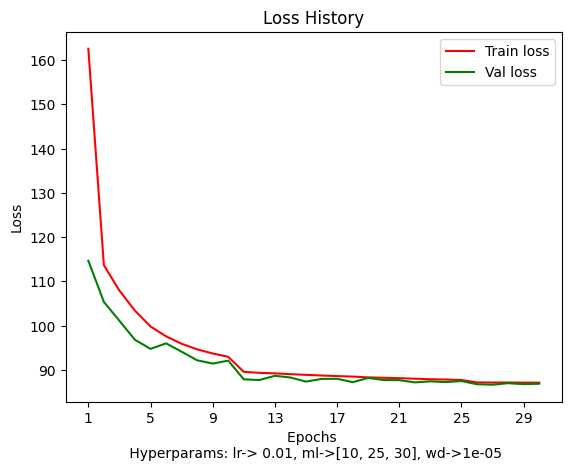

[Epoch: 31, Iteration:     1]  training loss: 89.547
[Epoch: 31, Iteration:   201]  training loss: 88.007
[Epoch: 31, Iteration:   401]  training loss: 87.659
[Epoch: 31, Iteration:   601]  training loss: 88.381
[Epoch: 31, Iteration:     1]  validation loss: 85.929
[Epoch: 32, Iteration:     1]  training loss: 89.419
[Epoch: 32, Iteration:   201]  training loss: 86.967
[Epoch: 32, Iteration:   401]  training loss: 87.249
[Epoch: 32, Iteration:   601]  training loss: 86.045
[Epoch: 32, Iteration:     1]  validation loss: 86.950
[Epoch: 33, Iteration:     1]  training loss: 84.641
[Epoch: 33, Iteration:   201]  training loss: 84.748
[Epoch: 33, Iteration:   401]  training loss: 87.563
[Epoch: 33, Iteration:   601]  training loss: 87.070
[Epoch: 33, Iteration:     1]  validation loss: 86.320
[Epoch: 34, Iteration:     1]  training loss: 91.801
[Epoch: 34, Iteration:   201]  training loss: 85.745
[Epoch: 34, Iteration:   401]  training loss: 82.930
[Epoch: 34, Iteration:   601]  training 

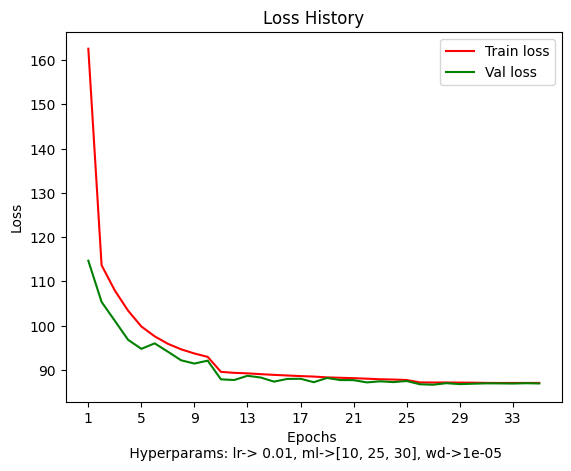

[Epoch: 36, Iteration:     1]  training loss: 86.980
[Epoch: 36, Iteration:   201]  training loss: 88.445
[Epoch: 36, Iteration:   401]  training loss: 86.687
[Epoch: 36, Iteration:   601]  training loss: 85.051
[Epoch: 36, Iteration:     1]  validation loss: 87.822
[Epoch: 37, Iteration:     1]  training loss: 84.595
[Epoch: 37, Iteration:   201]  training loss: 85.960
[Epoch: 37, Iteration:   401]  training loss: 83.535
[Epoch: 37, Iteration:   601]  training loss: 90.516
[Epoch: 37, Iteration:     1]  validation loss: 86.407
[Epoch: 38, Iteration:     1]  training loss: 83.881
[Epoch: 38, Iteration:   201]  training loss: 82.355
[Epoch: 38, Iteration:   401]  training loss: 86.997
[Epoch: 38, Iteration:   601]  training loss: 87.144
[Epoch: 38, Iteration:     1]  validation loss: 90.717
[Epoch: 39, Iteration:     1]  training loss: 88.331
[Epoch: 39, Iteration:   201]  training loss: 88.916
[Epoch: 39, Iteration:   401]  training loss: 84.209
[Epoch: 39, Iteration:   601]  training 

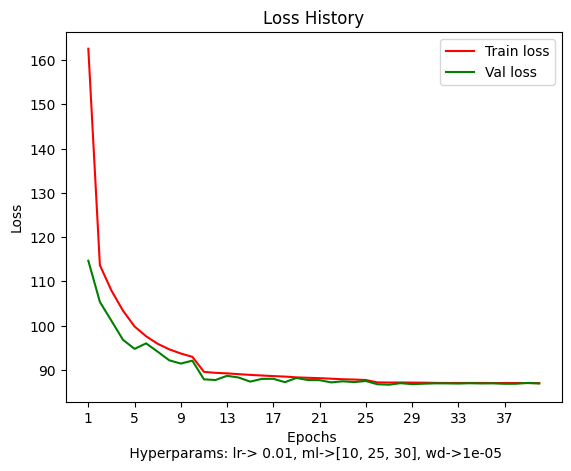

 67%|██████▋   | 12/18 [3:21:32<1:43:10, 1031.76s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 558.188
[Epoch: 1, Iteration:   201]  training loss: 149.508
[Epoch: 1, Iteration:   401]  training loss: 124.025
[Epoch: 1, Iteration:   601]  training loss: 119.408
[Epoch: 1, Iteration:     1]  validation loss: 103.635
[Epoch: 2, Iteration:     1]  training loss: 112.206
[Epoch: 2, Iteration:   201]  training loss: 109.511
[Epoch: 2, Iteration:   401]  training loss: 110.300
[Epoch: 2, Iteration:   601]  training loss: 106.124
[Epoch: 2, Iteration:     1]  validation loss: 96.452
[Epoch: 3, Iteration:     1]  training loss: 106.504
[Epoch: 3, Iteration:   201]  training loss: 104.476
[Epoch: 3, Iteration:   401]  training loss: 101.232
[Epoch: 3, Iteration:   601]  training loss: 105.415
[Epoch: 3, Iteration:     1]  validation loss: 93.948
[Epoch: 4, Iteration:     1]  training loss: 99.792
[Epoch: 4, Iteration:   201]  training loss: 97.967
[Epoch: 4, Iteration:   401]  training loss: 

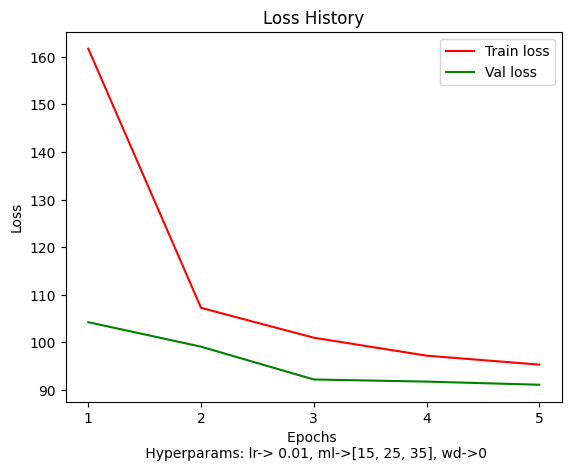

[Epoch: 6, Iteration:     1]  training loss: 93.587
[Epoch: 6, Iteration:   201]  training loss: 103.081
[Epoch: 6, Iteration:   401]  training loss: 92.116
[Epoch: 6, Iteration:   601]  training loss: 89.836
[Epoch: 6, Iteration:     1]  validation loss: 94.110
[Epoch: 7, Iteration:     1]  training loss: 91.705
[Epoch: 7, Iteration:   201]  training loss: 91.935
[Epoch: 7, Iteration:   401]  training loss: 97.551
[Epoch: 7, Iteration:   601]  training loss: 95.967
[Epoch: 7, Iteration:     1]  validation loss: 90.647
[Epoch: 8, Iteration:     1]  training loss: 89.770
[Epoch: 8, Iteration:   201]  training loss: 83.403
[Epoch: 8, Iteration:   401]  training loss: 93.427
[Epoch: 8, Iteration:   601]  training loss: 95.606
[Epoch: 8, Iteration:     1]  validation loss: 91.020
[Epoch: 9, Iteration:     1]  training loss: 91.924
[Epoch: 9, Iteration:   201]  training loss: 90.272
[Epoch: 9, Iteration:   401]  training loss: 89.159
[Epoch: 9, Iteration:   601]  training loss: 96.505
[Epoc

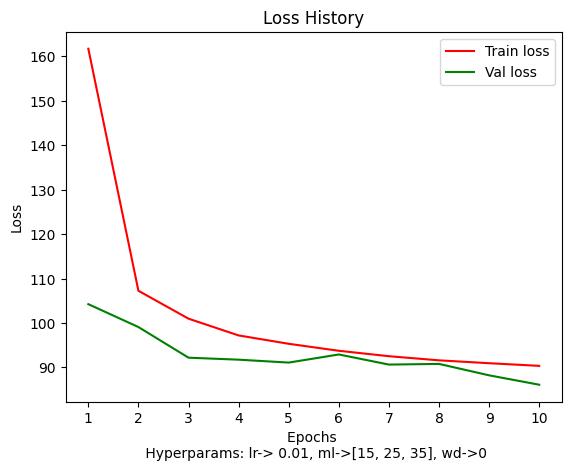

[Epoch: 11, Iteration:     1]  training loss: 88.730
[Epoch: 11, Iteration:   201]  training loss: 91.433
[Epoch: 11, Iteration:   401]  training loss: 87.214
[Epoch: 11, Iteration:   601]  training loss: 86.527
[Epoch: 11, Iteration:     1]  validation loss: 85.816
[Epoch: 12, Iteration:     1]  training loss: 84.303
[Epoch: 12, Iteration:   201]  training loss: 90.493
[Epoch: 12, Iteration:   401]  training loss: 89.176
[Epoch: 12, Iteration:   601]  training loss: 91.023
[Epoch: 12, Iteration:     1]  validation loss: 89.959
[Epoch: 13, Iteration:     1]  training loss: 93.855
[Epoch: 13, Iteration:   201]  training loss: 87.137
[Epoch: 13, Iteration:   401]  training loss: 90.882
[Epoch: 13, Iteration:   601]  training loss: 85.141
[Epoch: 13, Iteration:     1]  validation loss: 89.149
[Epoch: 14, Iteration:     1]  training loss: 89.241
[Epoch: 14, Iteration:   201]  training loss: 85.707
[Epoch: 14, Iteration:   401]  training loss: 91.192
[Epoch: 14, Iteration:   601]  training 

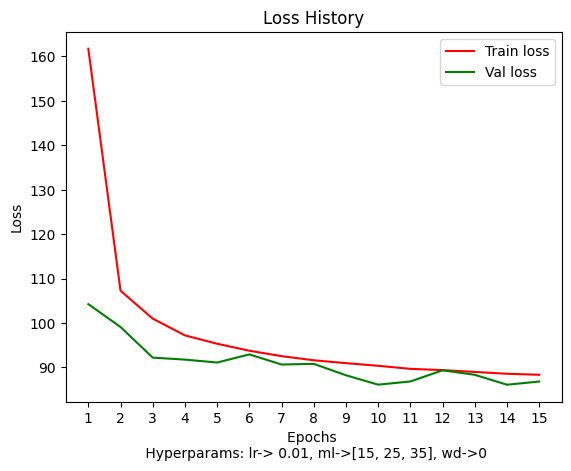

[Epoch: 16, Iteration:     1]  training loss: 87.730
[Epoch: 16, Iteration:   201]  training loss: 91.564
[Epoch: 16, Iteration:   401]  training loss: 81.691
[Epoch: 16, Iteration:   601]  training loss: 83.574
[Epoch: 16, Iteration:     1]  validation loss: 82.674
[Epoch: 17, Iteration:     1]  training loss: 86.917
[Epoch: 17, Iteration:   201]  training loss: 86.756
[Epoch: 17, Iteration:   401]  training loss: 82.128
[Epoch: 17, Iteration:   601]  training loss: 81.337
[Epoch: 17, Iteration:     1]  validation loss: 80.991
[Epoch: 18, Iteration:     1]  training loss: 85.319
[Epoch: 18, Iteration:   201]  training loss: 89.892
[Epoch: 18, Iteration:   401]  training loss: 88.008
[Epoch: 18, Iteration:   601]  training loss: 86.215
[Epoch: 18, Iteration:     1]  validation loss: 84.003
[Epoch: 19, Iteration:     1]  training loss: 82.270
[Epoch: 19, Iteration:   201]  training loss: 87.660
[Epoch: 19, Iteration:   401]  training loss: 84.698
[Epoch: 19, Iteration:   601]  training 

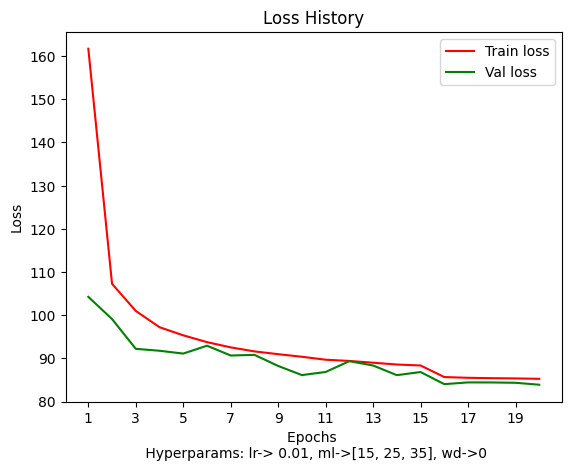

[Epoch: 21, Iteration:     1]  training loss: 85.183
[Epoch: 21, Iteration:   201]  training loss: 86.406
[Epoch: 21, Iteration:   401]  training loss: 83.297
[Epoch: 21, Iteration:   601]  training loss: 88.810
[Epoch: 21, Iteration:     1]  validation loss: 85.285
[Epoch: 22, Iteration:     1]  training loss: 83.353
[Epoch: 22, Iteration:   201]  training loss: 85.892
[Epoch: 22, Iteration:   401]  training loss: 86.575
[Epoch: 22, Iteration:   601]  training loss: 81.917
[Epoch: 22, Iteration:     1]  validation loss: 84.684
[Epoch: 23, Iteration:     1]  training loss: 86.858
[Epoch: 23, Iteration:   201]  training loss: 85.225
[Epoch: 23, Iteration:   401]  training loss: 85.543
[Epoch: 23, Iteration:   601]  training loss: 82.493
[Epoch: 23, Iteration:     1]  validation loss: 85.675
[Epoch: 24, Iteration:     1]  training loss: 83.374
[Epoch: 24, Iteration:   201]  training loss: 80.229
[Epoch: 24, Iteration:   401]  training loss: 88.220
[Epoch: 24, Iteration:   601]  training 

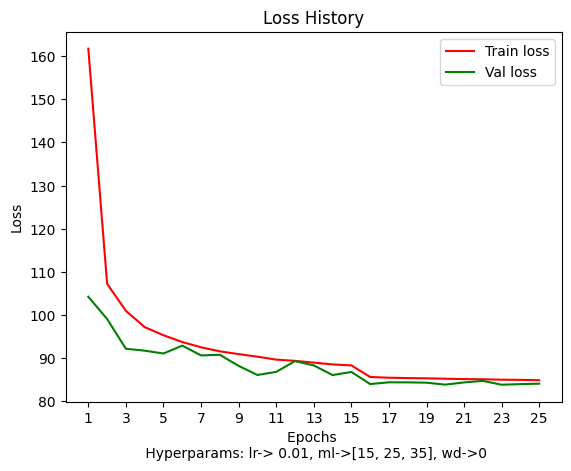

[Epoch: 26, Iteration:     1]  training loss: 94.018
[Epoch: 26, Iteration:   201]  training loss: 84.563
[Epoch: 26, Iteration:   401]  training loss: 84.293
[Epoch: 26, Iteration:   601]  training loss: 89.945
[Epoch: 26, Iteration:     1]  validation loss: 84.769
[Epoch: 27, Iteration:     1]  training loss: 90.140
[Epoch: 27, Iteration:   201]  training loss: 88.416
[Epoch: 27, Iteration:   401]  training loss: 89.497
[Epoch: 27, Iteration:   601]  training loss: 88.825
[Epoch: 27, Iteration:     1]  validation loss: 82.958
[Epoch: 28, Iteration:     1]  training loss: 81.787
[Epoch: 28, Iteration:   201]  training loss: 81.779
[Epoch: 28, Iteration:   401]  training loss: 82.028
[Epoch: 28, Iteration:   601]  training loss: 85.307
[Epoch: 28, Iteration:     1]  validation loss: 80.448
[Epoch: 29, Iteration:     1]  training loss: 84.131
[Epoch: 29, Iteration:   201]  training loss: 81.938
[Epoch: 29, Iteration:   401]  training loss: 84.558
[Epoch: 29, Iteration:   601]  training 

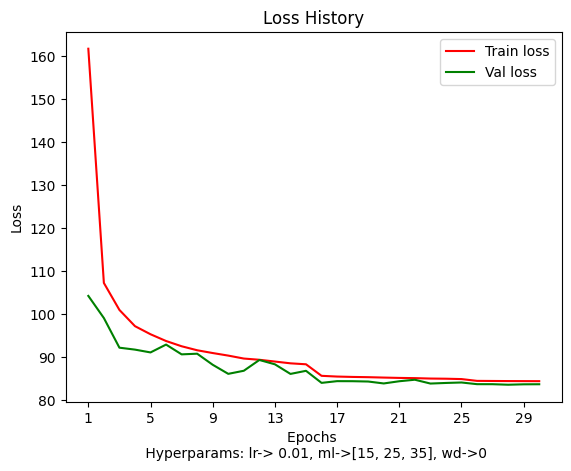

[Epoch: 31, Iteration:     1]  training loss: 84.657
[Epoch: 31, Iteration:   201]  training loss: 82.916
[Epoch: 31, Iteration:   401]  training loss: 81.372
[Epoch: 31, Iteration:   601]  training loss: 87.756
[Epoch: 31, Iteration:     1]  validation loss: 84.024
[Epoch: 32, Iteration:     1]  training loss: 78.994
[Epoch: 32, Iteration:   201]  training loss: 84.144
[Epoch: 32, Iteration:   401]  training loss: 87.059
[Epoch: 32, Iteration:   601]  training loss: 87.642
[Epoch: 32, Iteration:     1]  validation loss: 89.507
[Epoch: 33, Iteration:     1]  training loss: 81.278
[Epoch: 33, Iteration:   201]  training loss: 84.215
[Epoch: 33, Iteration:   401]  training loss: 82.258
[Epoch: 33, Iteration:   601]  training loss: 86.064
[Epoch: 33, Iteration:     1]  validation loss: 79.776
[Epoch: 34, Iteration:     1]  training loss: 85.128
[Epoch: 34, Iteration:   201]  training loss: 85.079
[Epoch: 34, Iteration:   401]  training loss: 88.561
[Epoch: 34, Iteration:   601]  training 

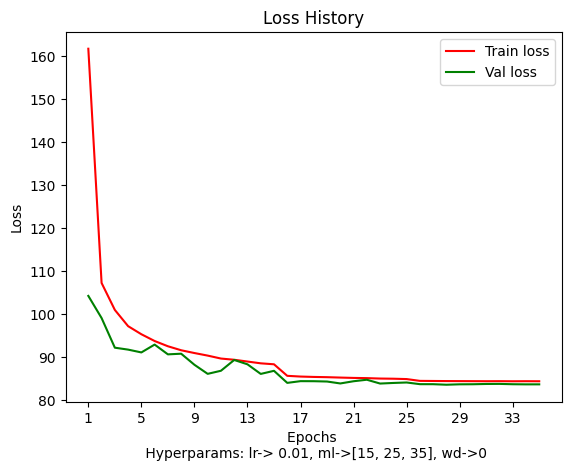

[Epoch: 36, Iteration:     1]  training loss: 82.793
[Epoch: 36, Iteration:   201]  training loss: 85.211
[Epoch: 36, Iteration:   401]  training loss: 79.940
[Epoch: 36, Iteration:   601]  training loss: 81.625
[Epoch: 36, Iteration:     1]  validation loss: 84.599
[Epoch: 37, Iteration:     1]  training loss: 83.058
[Epoch: 37, Iteration:   201]  training loss: 85.310
[Epoch: 37, Iteration:   401]  training loss: 85.100
[Epoch: 37, Iteration:   601]  training loss: 86.563
[Epoch: 37, Iteration:     1]  validation loss: 88.281
[Epoch: 38, Iteration:     1]  training loss: 86.918
[Epoch: 38, Iteration:   201]  training loss: 84.519
[Epoch: 38, Iteration:   401]  training loss: 85.086
[Epoch: 38, Iteration:   601]  training loss: 83.240
[Epoch: 38, Iteration:     1]  validation loss: 83.265
[Epoch: 39, Iteration:     1]  training loss: 88.271
[Epoch: 39, Iteration:   201]  training loss: 85.362
[Epoch: 39, Iteration:   401]  training loss: 84.509
[Epoch: 39, Iteration:   601]  training 

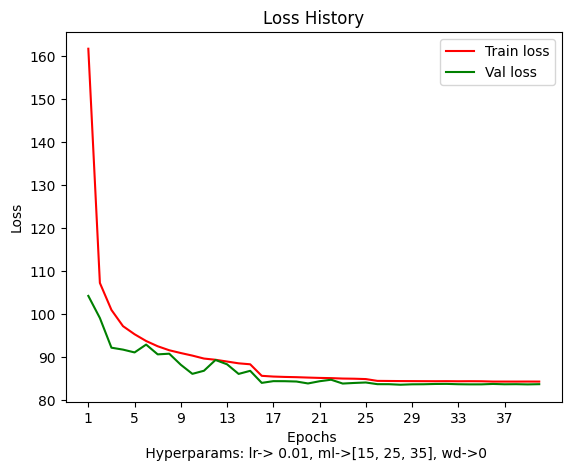

 72%|███████▏  | 13/18 [3:39:25<1:27:01, 1044.29s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 552.844
[Epoch: 1, Iteration:   201]  training loss: 173.464
[Epoch: 1, Iteration:   401]  training loss: 125.895
[Epoch: 1, Iteration:   601]  training loss: 109.517
[Epoch: 1, Iteration:     1]  validation loss: 99.122
[Epoch: 2, Iteration:     1]  training loss: 105.553
[Epoch: 2, Iteration:   201]  training loss: 107.560
[Epoch: 2, Iteration:   401]  training loss: 102.701
[Epoch: 2, Iteration:   601]  training loss: 101.032
[Epoch: 2, Iteration:     1]  validation loss: 97.088
[Epoch: 3, Iteration:     1]  training loss: 100.488
[Epoch: 3, Iteration:   201]  training loss: 94.476
[Epoch: 3, Iteration:   401]  training loss: 98.657
[Epoch: 3, Iteration:   601]  training loss: 97.938
[Epoch: 3, Iteration:     1]  validation loss: 94.740
[Epoch: 4, Iteration:     1]  training loss: 99.576
[Epoch: 4, Iteration:   201]  training loss: 95.929
[Epoch: 4, Iteration:   401]  training loss: 92.1

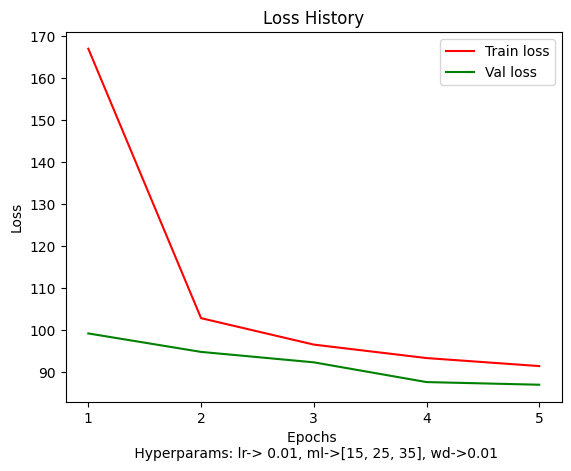

[Epoch: 6, Iteration:     1]  training loss: 91.389
[Epoch: 6, Iteration:   201]  training loss: 85.503
[Epoch: 6, Iteration:   401]  training loss: 89.548
[Epoch: 6, Iteration:   601]  training loss: 84.547
[Epoch: 6, Iteration:     1]  validation loss: 85.051
[Epoch: 7, Iteration:     1]  training loss: 89.874
[Epoch: 7, Iteration:   201]  training loss: 93.615
[Epoch: 7, Iteration:   401]  training loss: 92.009
[Epoch: 7, Iteration:   601]  training loss: 87.320
[Epoch: 7, Iteration:     1]  validation loss: 83.753
[Epoch: 8, Iteration:     1]  training loss: 92.324
[Epoch: 8, Iteration:   201]  training loss: 96.989
[Epoch: 8, Iteration:   401]  training loss: 84.126
[Epoch: 8, Iteration:   601]  training loss: 90.074
[Epoch: 8, Iteration:     1]  validation loss: 85.798
[Epoch: 9, Iteration:     1]  training loss: 91.971
[Epoch: 9, Iteration:   201]  training loss: 94.322
[Epoch: 9, Iteration:   401]  training loss: 93.749
[Epoch: 9, Iteration:   601]  training loss: 91.719
[Epoch

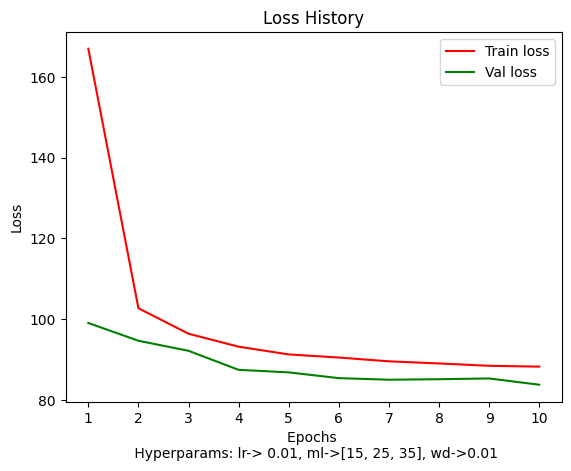

[Epoch: 11, Iteration:     1]  training loss: 86.840
[Epoch: 11, Iteration:   201]  training loss: 92.355
[Epoch: 11, Iteration:   401]  training loss: 88.577
[Epoch: 11, Iteration:   601]  training loss: 91.673
[Epoch: 11, Iteration:     1]  validation loss: 81.027
[Epoch: 12, Iteration:     1]  training loss: 90.976
[Epoch: 12, Iteration:   201]  training loss: 90.486
[Epoch: 12, Iteration:   401]  training loss: 90.408
[Epoch: 12, Iteration:   601]  training loss: 85.003
[Epoch: 12, Iteration:     1]  validation loss: 84.661
[Epoch: 13, Iteration:     1]  training loss: 86.696
[Epoch: 13, Iteration:   201]  training loss: 86.534
[Epoch: 13, Iteration:   401]  training loss: 87.614
[Epoch: 13, Iteration:   601]  training loss: 90.902
[Epoch: 13, Iteration:     1]  validation loss: 79.343
[Epoch: 14, Iteration:     1]  training loss: 84.629
[Epoch: 14, Iteration:   201]  training loss: 83.027
[Epoch: 14, Iteration:   401]  training loss: 85.777
[Epoch: 14, Iteration:   601]  training 

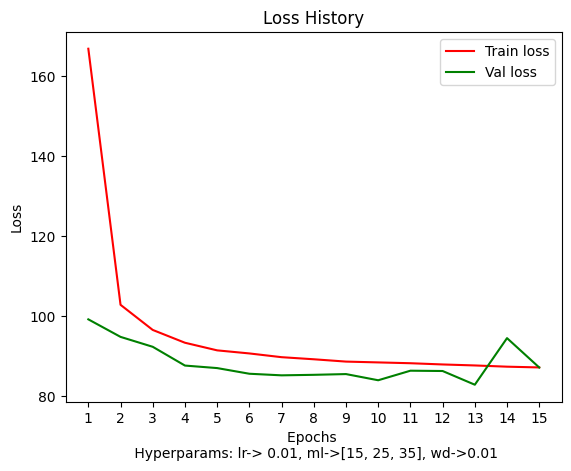

[Epoch: 16, Iteration:     1]  training loss: 89.599
[Epoch: 16, Iteration:   201]  training loss: 81.454
[Epoch: 16, Iteration:   401]  training loss: 80.026
[Epoch: 16, Iteration:   601]  training loss: 82.957
[Epoch: 16, Iteration:     1]  validation loss: 80.463
[Epoch: 17, Iteration:     1]  training loss: 81.728
[Epoch: 17, Iteration:   201]  training loss: 81.228
[Epoch: 17, Iteration:   401]  training loss: 83.442
[Epoch: 17, Iteration:   601]  training loss: 79.126
[Epoch: 17, Iteration:     1]  validation loss: 80.483
[Epoch: 18, Iteration:     1]  training loss: 82.224
[Epoch: 18, Iteration:   201]  training loss: 81.195
[Epoch: 18, Iteration:   401]  training loss: 84.599
[Epoch: 18, Iteration:   601]  training loss: 80.214
[Epoch: 18, Iteration:     1]  validation loss: 80.995
[Epoch: 19, Iteration:     1]  training loss: 81.090
[Epoch: 19, Iteration:   201]  training loss: 86.449
[Epoch: 19, Iteration:   401]  training loss: 79.583
[Epoch: 19, Iteration:   601]  training 

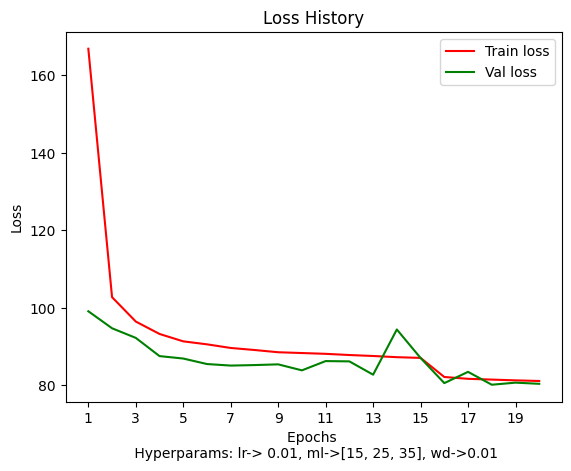

[Epoch: 21, Iteration:     1]  training loss: 83.334
[Epoch: 21, Iteration:   201]  training loss: 79.671
[Epoch: 21, Iteration:   401]  training loss: 79.711
[Epoch: 21, Iteration:   601]  training loss: 80.770
[Epoch: 21, Iteration:     1]  validation loss: 81.756
[Epoch: 22, Iteration:     1]  training loss: 79.055
[Epoch: 22, Iteration:   201]  training loss: 83.091
[Epoch: 22, Iteration:   401]  training loss: 77.525
[Epoch: 22, Iteration:   601]  training loss: 84.310
[Epoch: 22, Iteration:     1]  validation loss: 82.715
[Epoch: 23, Iteration:     1]  training loss: 81.942
[Epoch: 23, Iteration:   201]  training loss: 76.177
[Epoch: 23, Iteration:   401]  training loss: 81.394
[Epoch: 23, Iteration:   601]  training loss: 81.863
[Epoch: 23, Iteration:     1]  validation loss: 81.470
[Epoch: 24, Iteration:     1]  training loss: 76.697
[Epoch: 24, Iteration:   201]  training loss: 78.478
[Epoch: 24, Iteration:   401]  training loss: 81.838
[Epoch: 24, Iteration:   601]  training 

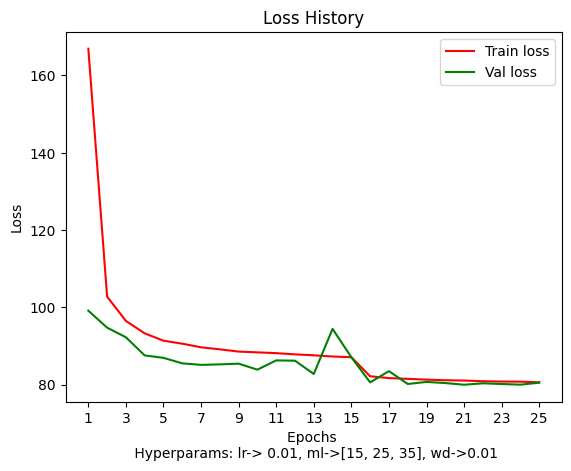

[Epoch: 26, Iteration:     1]  training loss: 80.435
[Epoch: 26, Iteration:   201]  training loss: 80.417
[Epoch: 26, Iteration:   401]  training loss: 80.536
[Epoch: 26, Iteration:   601]  training loss: 80.409
[Epoch: 26, Iteration:     1]  validation loss: 79.849
[Epoch: 27, Iteration:     1]  training loss: 83.108
[Epoch: 27, Iteration:   201]  training loss: 78.474
[Epoch: 27, Iteration:   401]  training loss: 78.985
[Epoch: 27, Iteration:   601]  training loss: 80.311
[Epoch: 27, Iteration:     1]  validation loss: 77.380
[Epoch: 28, Iteration:     1]  training loss: 82.075
[Epoch: 28, Iteration:   201]  training loss: 84.511
[Epoch: 28, Iteration:   401]  training loss: 81.747
[Epoch: 28, Iteration:   601]  training loss: 79.519
[Epoch: 28, Iteration:     1]  validation loss: 81.485
[Epoch: 29, Iteration:     1]  training loss: 83.186
[Epoch: 29, Iteration:   201]  training loss: 73.043
[Epoch: 29, Iteration:   401]  training loss: 82.670
[Epoch: 29, Iteration:   601]  training 

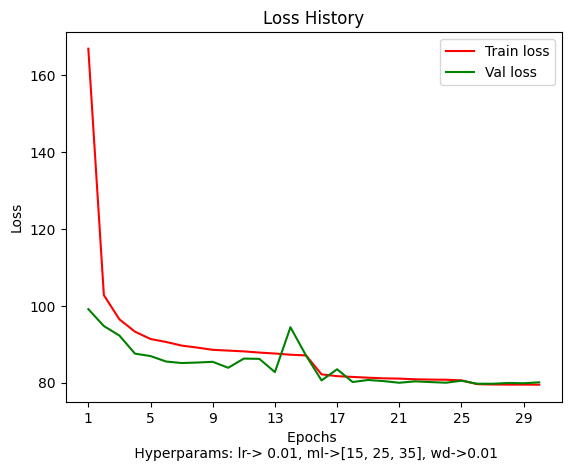

[Epoch: 31, Iteration:     1]  training loss: 80.735
[Epoch: 31, Iteration:   201]  training loss: 76.272
[Epoch: 31, Iteration:   401]  training loss: 78.536
[Epoch: 31, Iteration:   601]  training loss: 78.962
[Epoch: 31, Iteration:     1]  validation loss: 73.400
[Epoch: 32, Iteration:     1]  training loss: 76.615
[Epoch: 32, Iteration:   201]  training loss: 83.659
[Epoch: 32, Iteration:   401]  training loss: 76.609
[Epoch: 32, Iteration:   601]  training loss: 81.516
[Epoch: 32, Iteration:     1]  validation loss: 79.197
[Epoch: 33, Iteration:     1]  training loss: 74.546
[Epoch: 33, Iteration:   201]  training loss: 80.124
[Epoch: 33, Iteration:   401]  training loss: 86.232
[Epoch: 33, Iteration:   601]  training loss: 76.438
[Epoch: 33, Iteration:     1]  validation loss: 77.755
[Epoch: 34, Iteration:     1]  training loss: 77.605
[Epoch: 34, Iteration:   201]  training loss: 78.872
[Epoch: 34, Iteration:   401]  training loss: 79.873
[Epoch: 34, Iteration:   601]  training 

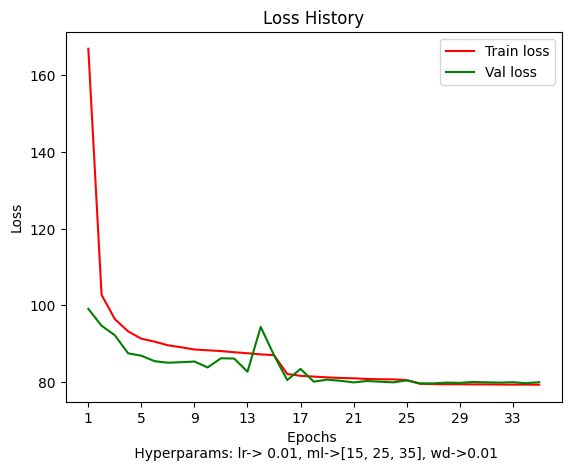

[Epoch: 36, Iteration:     1]  training loss: 79.831
[Epoch: 36, Iteration:   201]  training loss: 78.970
[Epoch: 36, Iteration:   401]  training loss: 76.871
[Epoch: 36, Iteration:   601]  training loss: 79.436
[Epoch: 36, Iteration:     1]  validation loss: 78.385
[Epoch: 37, Iteration:     1]  training loss: 77.796
[Epoch: 37, Iteration:   201]  training loss: 78.712
[Epoch: 37, Iteration:   401]  training loss: 79.203
[Epoch: 37, Iteration:   601]  training loss: 81.581
[Epoch: 37, Iteration:     1]  validation loss: 77.745
[Epoch: 38, Iteration:     1]  training loss: 79.872
[Epoch: 38, Iteration:   201]  training loss: 81.164
[Epoch: 38, Iteration:   401]  training loss: 80.715
[Epoch: 38, Iteration:   601]  training loss: 79.908
[Epoch: 38, Iteration:     1]  validation loss: 79.835
[Epoch: 39, Iteration:     1]  training loss: 78.004
[Epoch: 39, Iteration:   201]  training loss: 82.455
[Epoch: 39, Iteration:   401]  training loss: 77.391
[Epoch: 39, Iteration:   601]  training 

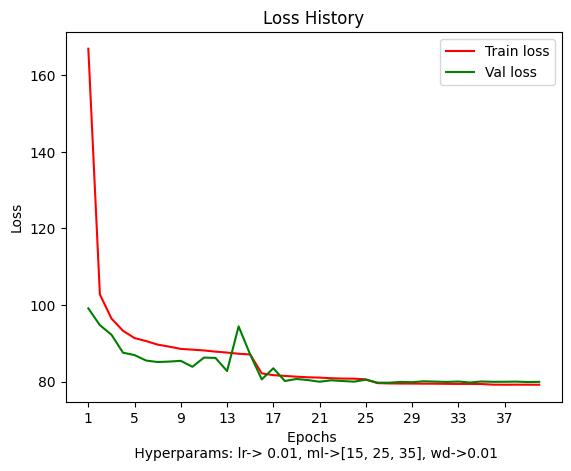

 78%|███████▊  | 14/18 [3:56:38<1:09:22, 1040.72s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 562.799
[Epoch: 1, Iteration:   201]  training loss: 150.963
[Epoch: 1, Iteration:   401]  training loss: 116.277
[Epoch: 1, Iteration:   601]  training loss: 106.547
[Epoch: 1, Iteration:     1]  validation loss: 102.520
[Epoch: 2, Iteration:     1]  training loss: 110.948
[Epoch: 2, Iteration:   201]  training loss: 103.960
[Epoch: 2, Iteration:   401]  training loss: 105.676
[Epoch: 2, Iteration:   601]  training loss: 99.582
[Epoch: 2, Iteration:     1]  validation loss: 93.348
[Epoch: 3, Iteration:     1]  training loss: 101.981
[Epoch: 3, Iteration:   201]  training loss: 97.044
[Epoch: 3, Iteration:   401]  training loss: 100.501
[Epoch: 3, Iteration:   601]  training loss: 95.362
[Epoch: 3, Iteration:     1]  validation loss: 89.954
[Epoch: 4, Iteration:     1]  training loss: 103.484
[Epoch: 4, Iteration:   201]  training loss: 93.075
[Epoch: 4, Iteration:   401]  training loss: 96

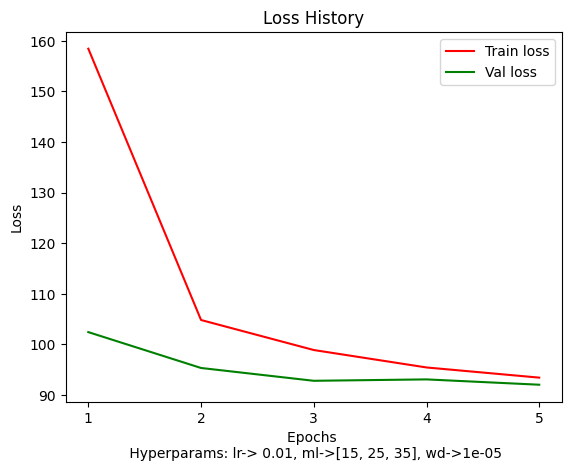

[Epoch: 6, Iteration:     1]  training loss: 94.747
[Epoch: 6, Iteration:   201]  training loss: 86.672
[Epoch: 6, Iteration:   401]  training loss: 91.091
[Epoch: 6, Iteration:   601]  training loss: 89.299
[Epoch: 6, Iteration:     1]  validation loss: 87.970
[Epoch: 7, Iteration:     1]  training loss: 92.088
[Epoch: 7, Iteration:   201]  training loss: 93.880
[Epoch: 7, Iteration:   401]  training loss: 88.689
[Epoch: 7, Iteration:   601]  training loss: 91.354
[Epoch: 7, Iteration:     1]  validation loss: 85.024
[Epoch: 8, Iteration:     1]  training loss: 86.619
[Epoch: 8, Iteration:   201]  training loss: 92.730
[Epoch: 8, Iteration:   401]  training loss: 86.581
[Epoch: 8, Iteration:   601]  training loss: 91.916
[Epoch: 8, Iteration:     1]  validation loss: 88.029
[Epoch: 9, Iteration:     1]  training loss: 94.943
[Epoch: 9, Iteration:   201]  training loss: 84.224
[Epoch: 9, Iteration:   401]  training loss: 86.038
[Epoch: 9, Iteration:   601]  training loss: 92.311
[Epoch

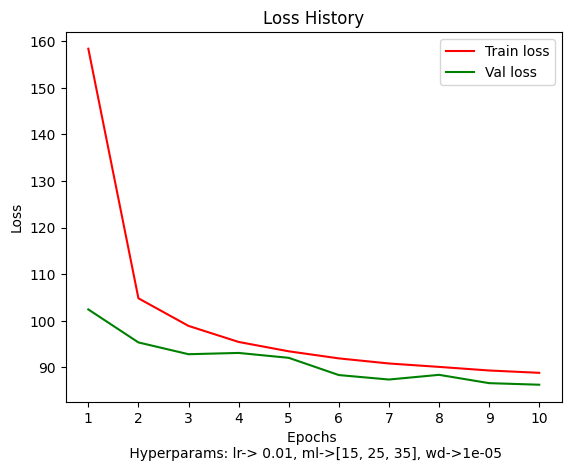

[Epoch: 11, Iteration:     1]  training loss: 84.907
[Epoch: 11, Iteration:   201]  training loss: 89.719
[Epoch: 11, Iteration:   401]  training loss: 93.579
[Epoch: 11, Iteration:   601]  training loss: 92.884
[Epoch: 11, Iteration:     1]  validation loss: 86.996
[Epoch: 12, Iteration:     1]  training loss: 91.640
[Epoch: 12, Iteration:   201]  training loss: 86.038
[Epoch: 12, Iteration:   401]  training loss: 85.841
[Epoch: 12, Iteration:   601]  training loss: 94.866
[Epoch: 12, Iteration:     1]  validation loss: 87.048
[Epoch: 13, Iteration:     1]  training loss: 88.955
[Epoch: 13, Iteration:   201]  training loss: 88.362
[Epoch: 13, Iteration:   401]  training loss: 85.832
[Epoch: 13, Iteration:   601]  training loss: 84.153
[Epoch: 13, Iteration:     1]  validation loss: 83.293
[Epoch: 14, Iteration:     1]  training loss: 90.735
[Epoch: 14, Iteration:   201]  training loss: 84.788
[Epoch: 14, Iteration:   401]  training loss: 85.932
[Epoch: 14, Iteration:   601]  training 

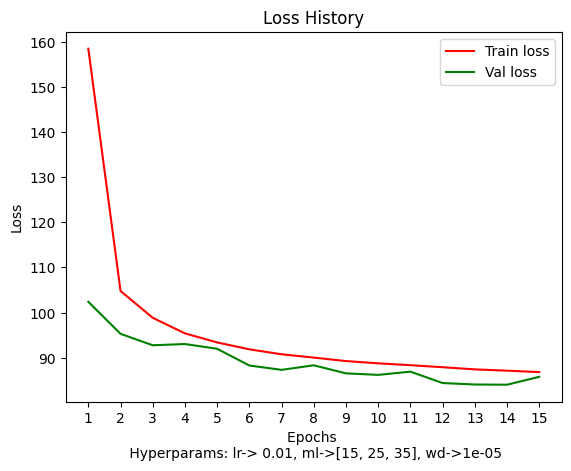

[Epoch: 16, Iteration:     1]  training loss: 84.788
[Epoch: 16, Iteration:   201]  training loss: 80.119
[Epoch: 16, Iteration:   401]  training loss: 81.747
[Epoch: 16, Iteration:   601]  training loss: 83.352
[Epoch: 16, Iteration:     1]  validation loss: 80.811
[Epoch: 17, Iteration:     1]  training loss: 79.874
[Epoch: 17, Iteration:   201]  training loss: 80.129
[Epoch: 17, Iteration:   401]  training loss: 83.717
[Epoch: 17, Iteration:   601]  training loss: 82.579
[Epoch: 17, Iteration:     1]  validation loss: 79.891
[Epoch: 18, Iteration:     1]  training loss: 85.952
[Epoch: 18, Iteration:   201]  training loss: 79.227
[Epoch: 18, Iteration:   401]  training loss: 82.493
[Epoch: 18, Iteration:   601]  training loss: 86.188
[Epoch: 18, Iteration:     1]  validation loss: 84.638
[Epoch: 19, Iteration:     1]  training loss: 84.266
[Epoch: 19, Iteration:   201]  training loss: 82.677
[Epoch: 19, Iteration:   401]  training loss: 86.565
[Epoch: 19, Iteration:   601]  training 

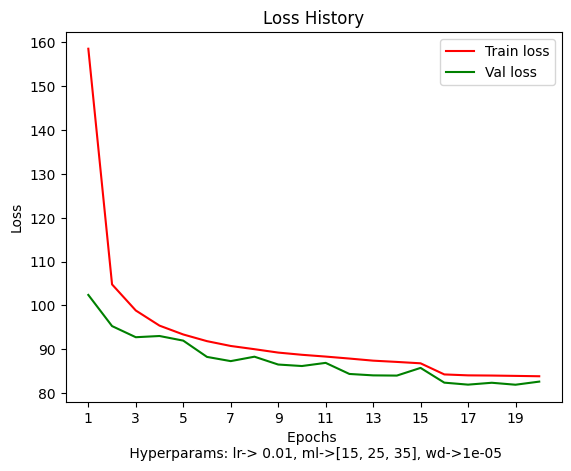

[Epoch: 21, Iteration:     1]  training loss: 82.031
[Epoch: 21, Iteration:   201]  training loss: 83.069
[Epoch: 21, Iteration:   401]  training loss: 85.588
[Epoch: 21, Iteration:   601]  training loss: 86.042
[Epoch: 21, Iteration:     1]  validation loss: 79.974
[Epoch: 22, Iteration:     1]  training loss: 87.741
[Epoch: 22, Iteration:   201]  training loss: 80.999
[Epoch: 22, Iteration:   401]  training loss: 85.346
[Epoch: 22, Iteration:   601]  training loss: 86.352
[Epoch: 22, Iteration:     1]  validation loss: 80.491
[Epoch: 23, Iteration:     1]  training loss: 83.078
[Epoch: 23, Iteration:   201]  training loss: 82.676
[Epoch: 23, Iteration:   401]  training loss: 82.015
[Epoch: 23, Iteration:   601]  training loss: 87.198
[Epoch: 23, Iteration:     1]  validation loss: 77.838
[Epoch: 24, Iteration:     1]  training loss: 80.121
[Epoch: 24, Iteration:   201]  training loss: 81.261
[Epoch: 24, Iteration:   401]  training loss: 84.379
[Epoch: 24, Iteration:   601]  training 

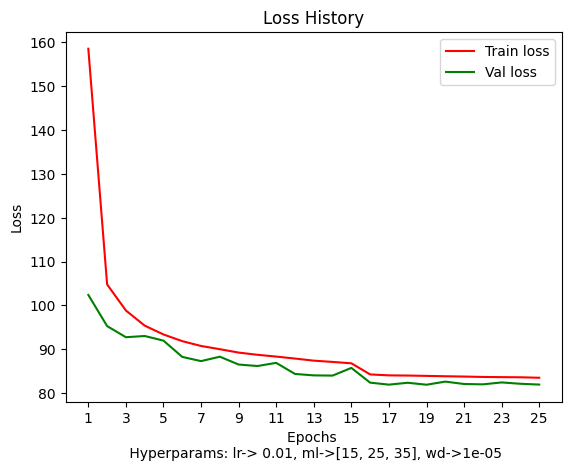

[Epoch: 26, Iteration:     1]  training loss: 81.646
[Epoch: 26, Iteration:   201]  training loss: 84.969
[Epoch: 26, Iteration:   401]  training loss: 85.538
[Epoch: 26, Iteration:   601]  training loss: 79.936
[Epoch: 26, Iteration:     1]  validation loss: 79.518
[Epoch: 27, Iteration:     1]  training loss: 84.620
[Epoch: 27, Iteration:   201]  training loss: 82.133
[Epoch: 27, Iteration:   401]  training loss: 81.347
[Epoch: 27, Iteration:   601]  training loss: 84.962
[Epoch: 27, Iteration:     1]  validation loss: 79.473
[Epoch: 28, Iteration:     1]  training loss: 84.443
[Epoch: 28, Iteration:   201]  training loss: 85.131
[Epoch: 28, Iteration:   401]  training loss: 83.583
[Epoch: 28, Iteration:   601]  training loss: 84.178
[Epoch: 28, Iteration:     1]  validation loss: 82.288
[Epoch: 29, Iteration:     1]  training loss: 83.980
[Epoch: 29, Iteration:   201]  training loss: 84.020
[Epoch: 29, Iteration:   401]  training loss: 82.362
[Epoch: 29, Iteration:   601]  training 

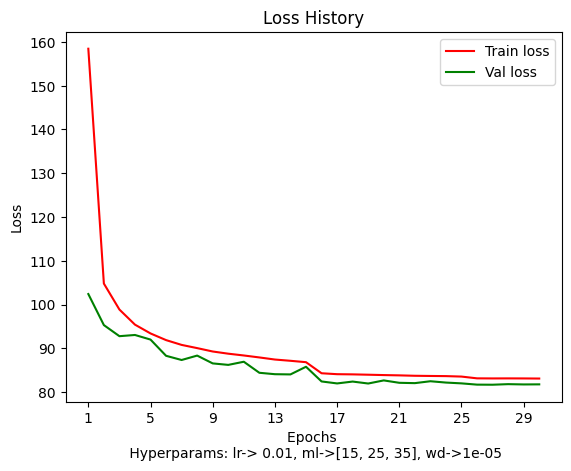

[Epoch: 31, Iteration:     1]  training loss: 81.102
[Epoch: 31, Iteration:   201]  training loss: 82.524
[Epoch: 31, Iteration:   401]  training loss: 87.719
[Epoch: 31, Iteration:   601]  training loss: 83.613
[Epoch: 31, Iteration:     1]  validation loss: 84.607
[Epoch: 32, Iteration:     1]  training loss: 81.456
[Epoch: 32, Iteration:   201]  training loss: 77.955
[Epoch: 32, Iteration:   401]  training loss: 80.432
[Epoch: 32, Iteration:   601]  training loss: 79.091
[Epoch: 32, Iteration:     1]  validation loss: 85.400
[Epoch: 33, Iteration:     1]  training loss: 79.003
[Epoch: 33, Iteration:   201]  training loss: 84.697
[Epoch: 33, Iteration:   401]  training loss: 81.056
[Epoch: 33, Iteration:   601]  training loss: 83.533
[Epoch: 33, Iteration:     1]  validation loss: 83.245
[Epoch: 34, Iteration:     1]  training loss: 86.072
[Epoch: 34, Iteration:   201]  training loss: 81.285
[Epoch: 34, Iteration:   401]  training loss: 88.166
[Epoch: 34, Iteration:   601]  training 

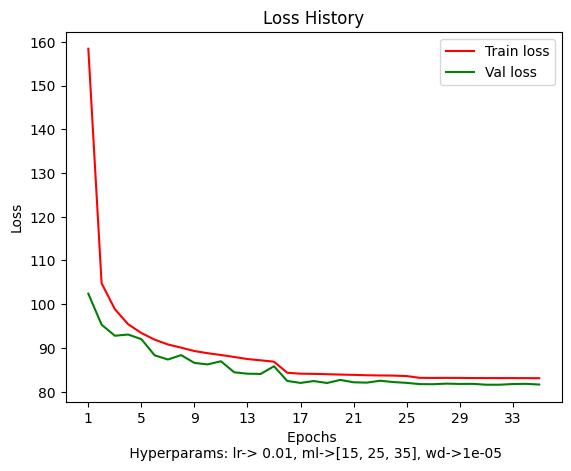

[Epoch: 36, Iteration:     1]  training loss: 87.068
[Epoch: 36, Iteration:   201]  training loss: 85.494
[Epoch: 36, Iteration:   401]  training loss: 82.400
[Epoch: 36, Iteration:   601]  training loss: 83.165
[Epoch: 36, Iteration:     1]  validation loss: 80.574
[Epoch: 37, Iteration:     1]  training loss: 78.868
[Epoch: 37, Iteration:   201]  training loss: 83.937
[Epoch: 37, Iteration:   401]  training loss: 83.821
[Epoch: 37, Iteration:   601]  training loss: 79.049
[Epoch: 37, Iteration:     1]  validation loss: 80.268
[Epoch: 38, Iteration:     1]  training loss: 88.671
[Epoch: 38, Iteration:   201]  training loss: 83.527
[Epoch: 38, Iteration:   401]  training loss: 88.148
[Epoch: 38, Iteration:   601]  training loss: 90.072
[Epoch: 38, Iteration:     1]  validation loss: 79.566
[Epoch: 39, Iteration:     1]  training loss: 78.005
[Epoch: 39, Iteration:   201]  training loss: 85.600
[Epoch: 39, Iteration:   401]  training loss: 84.374
[Epoch: 39, Iteration:   601]  training 

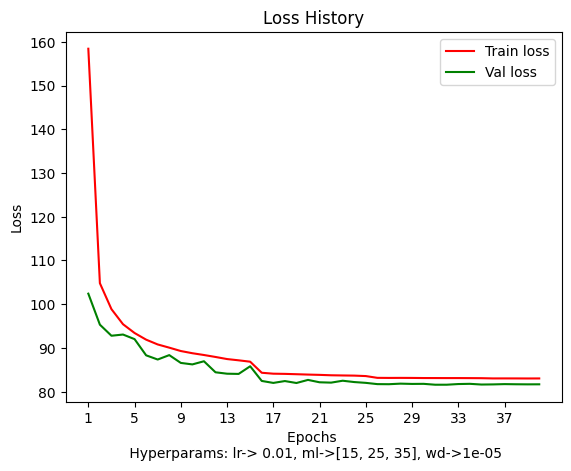

 83%|████████▎ | 15/18 [4:13:46<51:50, 1036.88s/it]  

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 557.555
[Epoch: 1, Iteration:   201]  training loss: 146.157
[Epoch: 1, Iteration:   401]  training loss: 118.612
[Epoch: 1, Iteration:   601]  training loss: 106.936
[Epoch: 1, Iteration:     1]  validation loss: 104.829
[Epoch: 2, Iteration:     1]  training loss: 108.554
[Epoch: 2, Iteration:   201]  training loss: 107.015
[Epoch: 2, Iteration:   401]  training loss: 100.427
[Epoch: 2, Iteration:   601]  training loss: 103.390
[Epoch: 2, Iteration:     1]  validation loss: 102.987
[Epoch: 3, Iteration:     1]  training loss: 99.633
[Epoch: 3, Iteration:   201]  training loss: 94.064
[Epoch: 3, Iteration:   401]  training loss: 96.665
[Epoch: 3, Iteration:   601]  training loss: 93.726
[Epoch: 3, Iteration:     1]  validation loss: 90.296
[Epoch: 4, Iteration:     1]  training loss: 96.051
[Epoch: 4, Iteration:   201]  training loss: 99.378
[Epoch: 4, Iteration:   401]  training loss: 96.

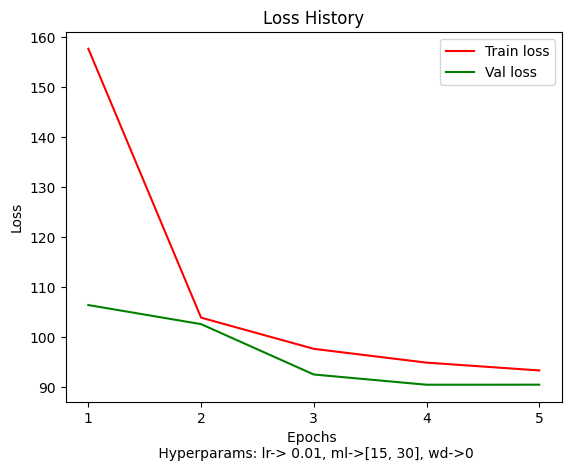

[Epoch: 6, Iteration:     1]  training loss: 96.131
[Epoch: 6, Iteration:   201]  training loss: 88.745
[Epoch: 6, Iteration:   401]  training loss: 94.468
[Epoch: 6, Iteration:   601]  training loss: 95.080
[Epoch: 6, Iteration:     1]  validation loss: 91.717
[Epoch: 7, Iteration:     1]  training loss: 97.049
[Epoch: 7, Iteration:   201]  training loss: 94.499
[Epoch: 7, Iteration:   401]  training loss: 90.304
[Epoch: 7, Iteration:   601]  training loss: 93.931
[Epoch: 7, Iteration:     1]  validation loss: 86.878
[Epoch: 8, Iteration:     1]  training loss: 95.101
[Epoch: 8, Iteration:   201]  training loss: 83.477
[Epoch: 8, Iteration:   401]  training loss: 93.252
[Epoch: 8, Iteration:   601]  training loss: 93.821
[Epoch: 8, Iteration:     1]  validation loss: 87.411
[Epoch: 9, Iteration:     1]  training loss: 91.284
[Epoch: 9, Iteration:   201]  training loss: 91.694
[Epoch: 9, Iteration:   401]  training loss: 88.392
[Epoch: 9, Iteration:   601]  training loss: 87.896
[Epoch

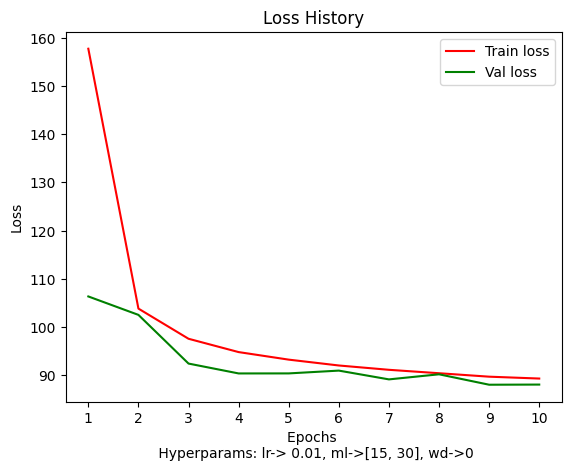

[Epoch: 11, Iteration:     1]  training loss: 89.145
[Epoch: 11, Iteration:   201]  training loss: 91.205
[Epoch: 11, Iteration:   401]  training loss: 88.568
[Epoch: 11, Iteration:   601]  training loss: 86.714
[Epoch: 11, Iteration:     1]  validation loss: 92.470
[Epoch: 12, Iteration:     1]  training loss: 93.638
[Epoch: 12, Iteration:   201]  training loss: 90.992
[Epoch: 12, Iteration:   401]  training loss: 92.055
[Epoch: 12, Iteration:   601]  training loss: 88.043
[Epoch: 12, Iteration:     1]  validation loss: 84.665
[Epoch: 13, Iteration:     1]  training loss: 87.952
[Epoch: 13, Iteration:   201]  training loss: 91.309
[Epoch: 13, Iteration:   401]  training loss: 85.925
[Epoch: 13, Iteration:   601]  training loss: 87.946
[Epoch: 13, Iteration:     1]  validation loss: 84.650
[Epoch: 14, Iteration:     1]  training loss: 85.846
[Epoch: 14, Iteration:   201]  training loss: 85.359
[Epoch: 14, Iteration:   401]  training loss: 90.167
[Epoch: 14, Iteration:   601]  training 

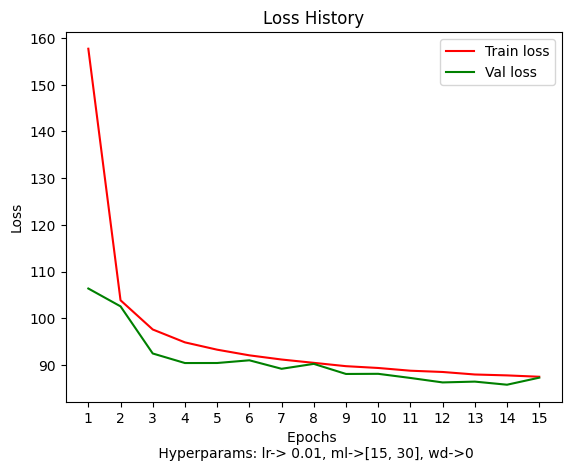

[Epoch: 16, Iteration:     1]  training loss: 91.173
[Epoch: 16, Iteration:   201]  training loss: 81.349
[Epoch: 16, Iteration:   401]  training loss: 83.855
[Epoch: 16, Iteration:   601]  training loss: 85.631
[Epoch: 16, Iteration:     1]  validation loss: 85.775
[Epoch: 17, Iteration:     1]  training loss: 86.319
[Epoch: 17, Iteration:   201]  training loss: 85.530
[Epoch: 17, Iteration:   401]  training loss: 81.790
[Epoch: 17, Iteration:   601]  training loss: 81.160
[Epoch: 17, Iteration:     1]  validation loss: 86.463
[Epoch: 18, Iteration:     1]  training loss: 80.480
[Epoch: 18, Iteration:   201]  training loss: 90.766
[Epoch: 18, Iteration:   401]  training loss: 88.165
[Epoch: 18, Iteration:   601]  training loss: 86.098
[Epoch: 18, Iteration:     1]  validation loss: 81.774
[Epoch: 19, Iteration:     1]  training loss: 79.995
[Epoch: 19, Iteration:   201]  training loss: 85.897
[Epoch: 19, Iteration:   401]  training loss: 79.821
[Epoch: 19, Iteration:   601]  training 

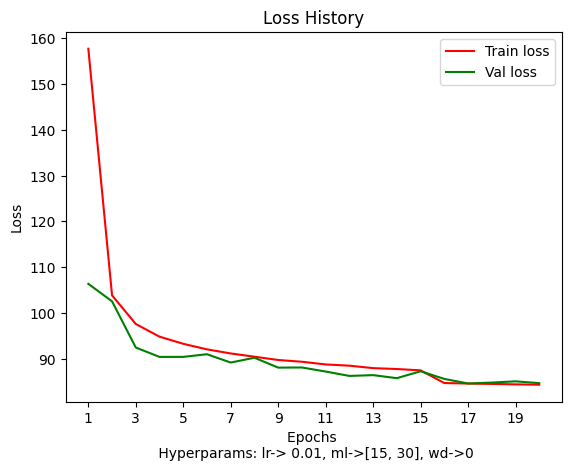

[Epoch: 21, Iteration:     1]  training loss: 83.227
[Epoch: 21, Iteration:   201]  training loss: 82.342
[Epoch: 21, Iteration:   401]  training loss: 83.984
[Epoch: 21, Iteration:   601]  training loss: 78.619
[Epoch: 21, Iteration:     1]  validation loss: 85.818
[Epoch: 22, Iteration:     1]  training loss: 84.931
[Epoch: 22, Iteration:   201]  training loss: 82.485
[Epoch: 22, Iteration:   401]  training loss: 78.183
[Epoch: 22, Iteration:   601]  training loss: 81.986
[Epoch: 22, Iteration:     1]  validation loss: 82.852
[Epoch: 23, Iteration:     1]  training loss: 86.578
[Epoch: 23, Iteration:   201]  training loss: 83.540
[Epoch: 23, Iteration:   401]  training loss: 85.439
[Epoch: 23, Iteration:   601]  training loss: 84.167
[Epoch: 23, Iteration:     1]  validation loss: 85.318
[Epoch: 24, Iteration:     1]  training loss: 87.088
[Epoch: 24, Iteration:   201]  training loss: 85.499
[Epoch: 24, Iteration:   401]  training loss: 84.925
[Epoch: 24, Iteration:   601]  training 

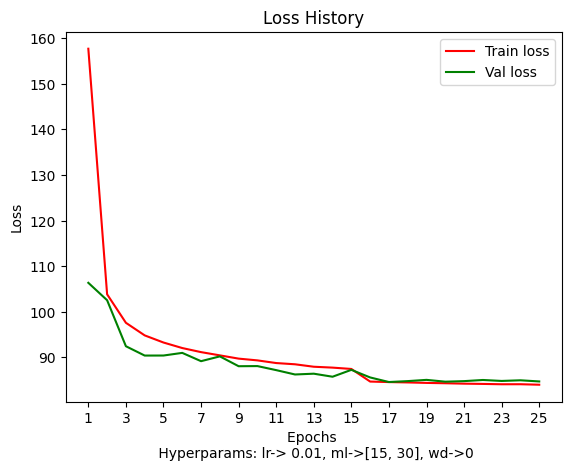

[Epoch: 26, Iteration:     1]  training loss: 79.799
[Epoch: 26, Iteration:   201]  training loss: 83.606
[Epoch: 26, Iteration:   401]  training loss: 86.256
[Epoch: 26, Iteration:   601]  training loss: 83.401
[Epoch: 26, Iteration:     1]  validation loss: 82.831
[Epoch: 27, Iteration:     1]  training loss: 85.192
[Epoch: 27, Iteration:   201]  training loss: 83.967
[Epoch: 27, Iteration:   401]  training loss: 85.795
[Epoch: 27, Iteration:   601]  training loss: 79.555
[Epoch: 27, Iteration:     1]  validation loss: 81.373
[Epoch: 28, Iteration:     1]  training loss: 88.259
[Epoch: 28, Iteration:   201]  training loss: 87.913
[Epoch: 28, Iteration:   401]  training loss: 86.100
[Epoch: 28, Iteration:   601]  training loss: 85.998
[Epoch: 28, Iteration:     1]  validation loss: 87.344
[Epoch: 29, Iteration:     1]  training loss: 81.480
[Epoch: 29, Iteration:   201]  training loss: 80.254
[Epoch: 29, Iteration:   401]  training loss: 83.131
[Epoch: 29, Iteration:   601]  training 

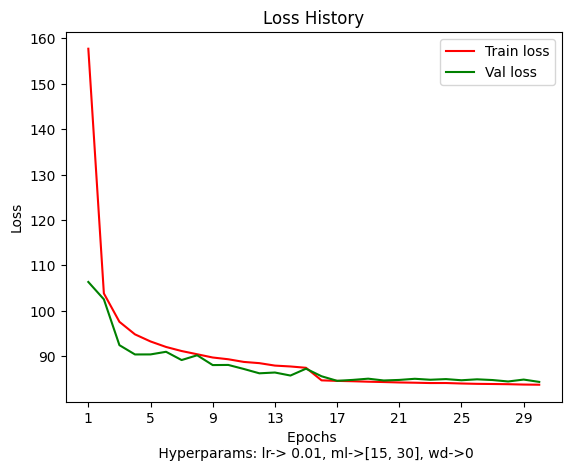

[Epoch: 31, Iteration:     1]  training loss: 79.322
[Epoch: 31, Iteration:   201]  training loss: 79.197
[Epoch: 31, Iteration:   401]  training loss: 83.752
[Epoch: 31, Iteration:   601]  training loss: 82.997
[Epoch: 31, Iteration:     1]  validation loss: 86.749
[Epoch: 32, Iteration:     1]  training loss: 79.478
[Epoch: 32, Iteration:   201]  training loss: 85.284
[Epoch: 32, Iteration:   401]  training loss: 82.490
[Epoch: 32, Iteration:   601]  training loss: 87.466
[Epoch: 32, Iteration:     1]  validation loss: 90.003
[Epoch: 33, Iteration:     1]  training loss: 84.498
[Epoch: 33, Iteration:   201]  training loss: 82.165
[Epoch: 33, Iteration:   401]  training loss: 84.606
[Epoch: 33, Iteration:   601]  training loss: 80.998
[Epoch: 33, Iteration:     1]  validation loss: 85.848
[Epoch: 34, Iteration:     1]  training loss: 83.751
[Epoch: 34, Iteration:   201]  training loss: 81.817
[Epoch: 34, Iteration:   401]  training loss: 79.089
[Epoch: 34, Iteration:   601]  training 

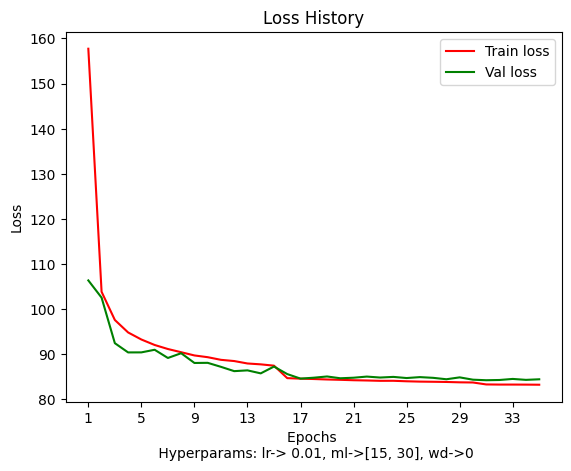

[Epoch: 36, Iteration:     1]  training loss: 84.485
[Epoch: 36, Iteration:   201]  training loss: 83.249
[Epoch: 36, Iteration:   401]  training loss: 86.116
[Epoch: 36, Iteration:   601]  training loss: 86.192
[Epoch: 36, Iteration:     1]  validation loss: 81.726
[Epoch: 37, Iteration:     1]  training loss: 84.355
[Epoch: 37, Iteration:   201]  training loss: 84.383
[Epoch: 37, Iteration:   401]  training loss: 82.770
[Epoch: 37, Iteration:   601]  training loss: 84.541
[Epoch: 37, Iteration:     1]  validation loss: 82.866
[Epoch: 38, Iteration:     1]  training loss: 82.901
[Epoch: 38, Iteration:   201]  training loss: 87.035
[Epoch: 38, Iteration:   401]  training loss: 84.463
[Epoch: 38, Iteration:   601]  training loss: 84.049
[Epoch: 38, Iteration:     1]  validation loss: 83.295
[Epoch: 39, Iteration:     1]  training loss: 79.904
[Epoch: 39, Iteration:   201]  training loss: 84.130
[Epoch: 39, Iteration:   401]  training loss: 81.550
[Epoch: 39, Iteration:   601]  training 

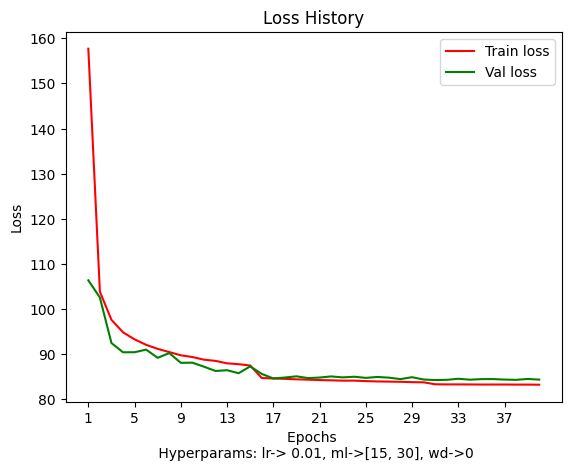

 89%|████████▉ | 16/18 [4:31:39<34:55, 1047.76s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 555.376
[Epoch: 1, Iteration:   201]  training loss: 146.210
[Epoch: 1, Iteration:   401]  training loss: 112.857
[Epoch: 1, Iteration:   601]  training loss: 102.241
[Epoch: 1, Iteration:     1]  validation loss: 102.276
[Epoch: 2, Iteration:     1]  training loss: 112.128
[Epoch: 2, Iteration:   201]  training loss: 99.668
[Epoch: 2, Iteration:   401]  training loss: 105.533
[Epoch: 2, Iteration:   601]  training loss: 99.484
[Epoch: 2, Iteration:     1]  validation loss: 93.087
[Epoch: 3, Iteration:     1]  training loss: 104.328
[Epoch: 3, Iteration:   201]  training loss: 98.586
[Epoch: 3, Iteration:   401]  training loss: 95.078
[Epoch: 3, Iteration:   601]  training loss: 94.235
[Epoch: 3, Iteration:     1]  validation loss: 87.418
[Epoch: 4, Iteration:     1]  training loss: 97.360
[Epoch: 4, Iteration:   201]  training loss: 90.037
[Epoch: 4, Iteration:   401]  training loss: 90.23

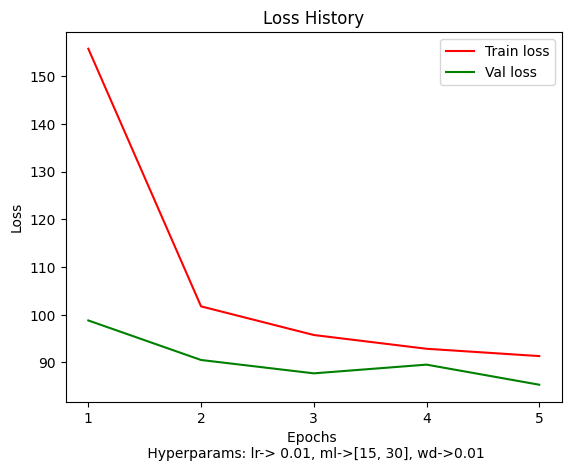

[Epoch: 6, Iteration:     1]  training loss: 89.534
[Epoch: 6, Iteration:   201]  training loss: 94.076
[Epoch: 6, Iteration:   401]  training loss: 87.527
[Epoch: 6, Iteration:   601]  training loss: 87.859
[Epoch: 6, Iteration:     1]  validation loss: 88.356
[Epoch: 7, Iteration:     1]  training loss: 89.280
[Epoch: 7, Iteration:   201]  training loss: 96.442
[Epoch: 7, Iteration:   401]  training loss: 91.124
[Epoch: 7, Iteration:   601]  training loss: 88.995
[Epoch: 7, Iteration:     1]  validation loss: 81.554
[Epoch: 8, Iteration:     1]  training loss: 90.425
[Epoch: 8, Iteration:   201]  training loss: 87.982
[Epoch: 8, Iteration:   401]  training loss: 89.782
[Epoch: 8, Iteration:   601]  training loss: 89.551
[Epoch: 8, Iteration:     1]  validation loss: 82.664
[Epoch: 9, Iteration:     1]  training loss: 91.315
[Epoch: 9, Iteration:   201]  training loss: 87.941
[Epoch: 9, Iteration:   401]  training loss: 83.814
[Epoch: 9, Iteration:   601]  training loss: 86.566
[Epoch

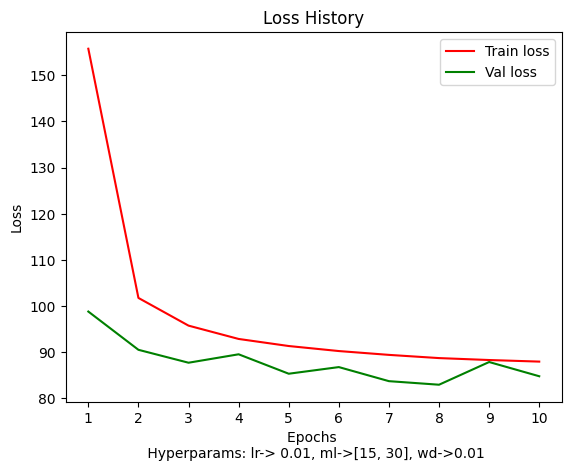

[Epoch: 11, Iteration:     1]  training loss: 88.854
[Epoch: 11, Iteration:   201]  training loss: 82.801
[Epoch: 11, Iteration:   401]  training loss: 91.726
[Epoch: 11, Iteration:   601]  training loss: 87.864
[Epoch: 11, Iteration:     1]  validation loss: 88.062
[Epoch: 12, Iteration:     1]  training loss: 89.603
[Epoch: 12, Iteration:   201]  training loss: 88.648
[Epoch: 12, Iteration:   401]  training loss: 88.085
[Epoch: 12, Iteration:   601]  training loss: 90.390
[Epoch: 12, Iteration:     1]  validation loss: 86.762
[Epoch: 13, Iteration:     1]  training loss: 90.526
[Epoch: 13, Iteration:   201]  training loss: 89.595
[Epoch: 13, Iteration:   401]  training loss: 89.152
[Epoch: 13, Iteration:   601]  training loss: 88.369
[Epoch: 13, Iteration:     1]  validation loss: 90.706
[Epoch: 14, Iteration:     1]  training loss: 89.095
[Epoch: 14, Iteration:   201]  training loss: 84.525
[Epoch: 14, Iteration:   401]  training loss: 89.485
[Epoch: 14, Iteration:   601]  training 

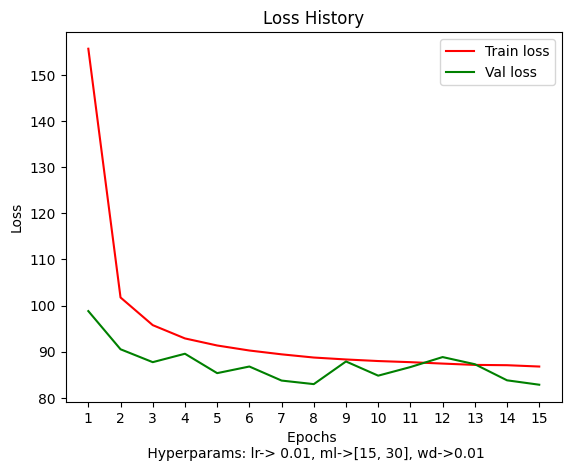

[Epoch: 16, Iteration:     1]  training loss: 84.293
[Epoch: 16, Iteration:   201]  training loss: 81.661
[Epoch: 16, Iteration:   401]  training loss: 80.845
[Epoch: 16, Iteration:   601]  training loss: 85.902
[Epoch: 16, Iteration:     1]  validation loss: 79.740
[Epoch: 17, Iteration:     1]  training loss: 87.515
[Epoch: 17, Iteration:   201]  training loss: 79.912
[Epoch: 17, Iteration:   401]  training loss: 79.695
[Epoch: 17, Iteration:   601]  training loss: 79.829
[Epoch: 17, Iteration:     1]  validation loss: 80.351
[Epoch: 18, Iteration:     1]  training loss: 83.752
[Epoch: 18, Iteration:   201]  training loss: 84.848
[Epoch: 18, Iteration:   401]  training loss: 76.895
[Epoch: 18, Iteration:   601]  training loss: 77.356
[Epoch: 18, Iteration:     1]  validation loss: 75.299
[Epoch: 19, Iteration:     1]  training loss: 85.565
[Epoch: 19, Iteration:   201]  training loss: 81.224
[Epoch: 19, Iteration:   401]  training loss: 84.355
[Epoch: 19, Iteration:   601]  training 

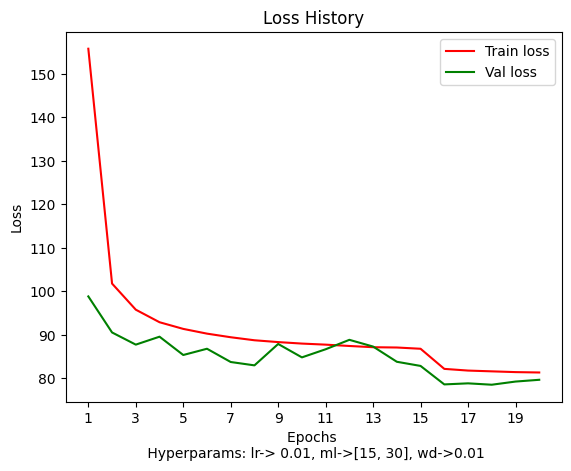

[Epoch: 21, Iteration:     1]  training loss: 86.552
[Epoch: 21, Iteration:   201]  training loss: 83.985
[Epoch: 21, Iteration:   401]  training loss: 79.764
[Epoch: 21, Iteration:   601]  training loss: 82.725
[Epoch: 21, Iteration:     1]  validation loss: 80.991
[Epoch: 22, Iteration:     1]  training loss: 81.460
[Epoch: 22, Iteration:   201]  training loss: 80.781
[Epoch: 22, Iteration:   401]  training loss: 82.440
[Epoch: 22, Iteration:   601]  training loss: 83.315
[Epoch: 22, Iteration:     1]  validation loss: 79.763
[Epoch: 23, Iteration:     1]  training loss: 79.371
[Epoch: 23, Iteration:   201]  training loss: 80.957
[Epoch: 23, Iteration:   401]  training loss: 80.841
[Epoch: 23, Iteration:   601]  training loss: 81.286
[Epoch: 23, Iteration:     1]  validation loss: 78.462
[Epoch: 24, Iteration:     1]  training loss: 87.623
[Epoch: 24, Iteration:   201]  training loss: 84.688
[Epoch: 24, Iteration:   401]  training loss: 83.179
[Epoch: 24, Iteration:   601]  training 

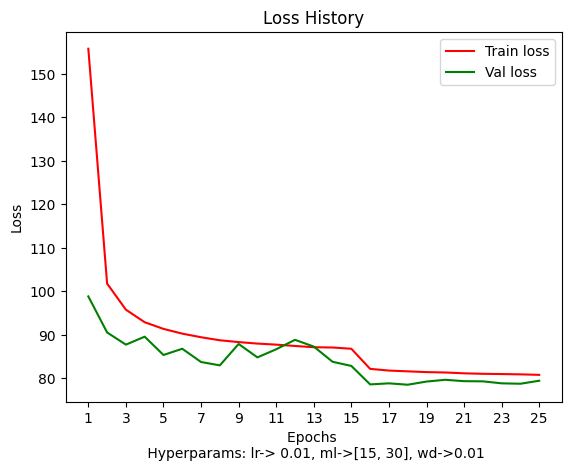

[Epoch: 26, Iteration:     1]  training loss: 75.558
[Epoch: 26, Iteration:   201]  training loss: 82.180
[Epoch: 26, Iteration:   401]  training loss: 82.992
[Epoch: 26, Iteration:   601]  training loss: 82.877
[Epoch: 26, Iteration:     1]  validation loss: 79.950
[Epoch: 27, Iteration:     1]  training loss: 84.496
[Epoch: 27, Iteration:   201]  training loss: 79.604
[Epoch: 27, Iteration:   401]  training loss: 79.733
[Epoch: 27, Iteration:   601]  training loss: 78.782
[Epoch: 27, Iteration:     1]  validation loss: 80.145
[Epoch: 28, Iteration:     1]  training loss: 84.459
[Epoch: 28, Iteration:   201]  training loss: 80.109
[Epoch: 28, Iteration:   401]  training loss: 81.258
[Epoch: 28, Iteration:   601]  training loss: 84.735
[Epoch: 28, Iteration:     1]  validation loss: 79.222
[Epoch: 29, Iteration:     1]  training loss: 82.913
[Epoch: 29, Iteration:   201]  training loss: 82.094
[Epoch: 29, Iteration:   401]  training loss: 79.170
[Epoch: 29, Iteration:   601]  training 

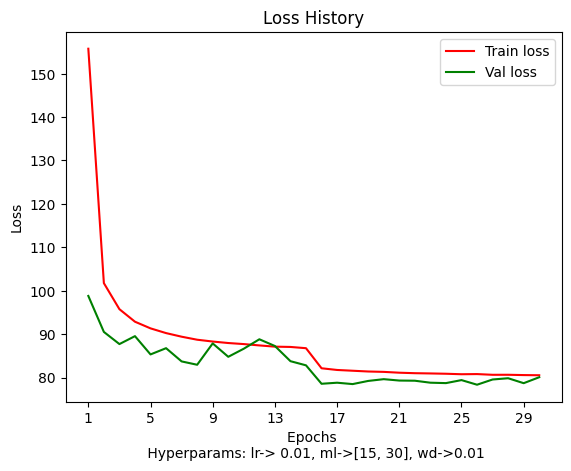

[Epoch: 31, Iteration:     1]  training loss: 81.795
[Epoch: 31, Iteration:   201]  training loss: 79.982
[Epoch: 31, Iteration:   401]  training loss: 81.293
[Epoch: 31, Iteration:   601]  training loss: 77.522
[Epoch: 31, Iteration:     1]  validation loss: 76.442
[Epoch: 32, Iteration:     1]  training loss: 82.563
[Epoch: 32, Iteration:   201]  training loss: 85.638
[Epoch: 32, Iteration:   401]  training loss: 79.072
[Epoch: 32, Iteration:   601]  training loss: 78.556
[Epoch: 32, Iteration:     1]  validation loss: 81.409
[Epoch: 33, Iteration:     1]  training loss: 78.915
[Epoch: 33, Iteration:   201]  training loss: 81.813
[Epoch: 33, Iteration:   401]  training loss: 81.424
[Epoch: 33, Iteration:   601]  training loss: 81.454
[Epoch: 33, Iteration:     1]  validation loss: 77.061
[Epoch: 34, Iteration:     1]  training loss: 83.163
[Epoch: 34, Iteration:   201]  training loss: 79.055
[Epoch: 34, Iteration:   401]  training loss: 82.847
[Epoch: 34, Iteration:   601]  training 

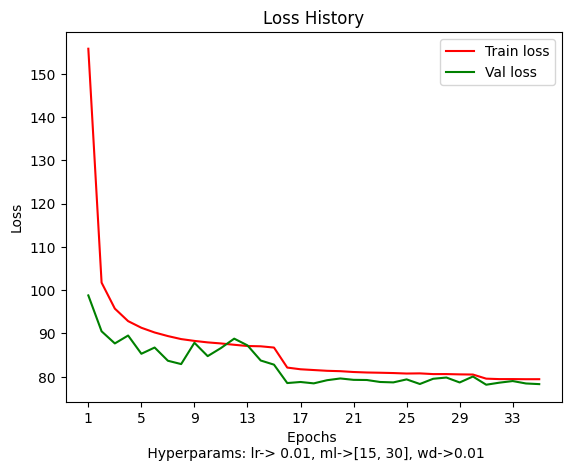

[Epoch: 36, Iteration:     1]  training loss: 77.671
[Epoch: 36, Iteration:   201]  training loss: 80.760
[Epoch: 36, Iteration:   401]  training loss: 84.342
[Epoch: 36, Iteration:   601]  training loss: 82.452
[Epoch: 36, Iteration:     1]  validation loss: 78.204
[Epoch: 37, Iteration:     1]  training loss: 78.503
[Epoch: 37, Iteration:   201]  training loss: 75.195
[Epoch: 37, Iteration:   401]  training loss: 85.395
[Epoch: 37, Iteration:   601]  training loss: 79.558
[Epoch: 37, Iteration:     1]  validation loss: 80.010
[Epoch: 38, Iteration:     1]  training loss: 80.760
[Epoch: 38, Iteration:   201]  training loss: 80.629
[Epoch: 38, Iteration:   401]  training loss: 79.518
[Epoch: 38, Iteration:   601]  training loss: 81.419
[Epoch: 38, Iteration:     1]  validation loss: 81.947
[Epoch: 39, Iteration:     1]  training loss: 82.967
[Epoch: 39, Iteration:   201]  training loss: 83.556
[Epoch: 39, Iteration:   401]  training loss: 78.783
[Epoch: 39, Iteration:   601]  training 

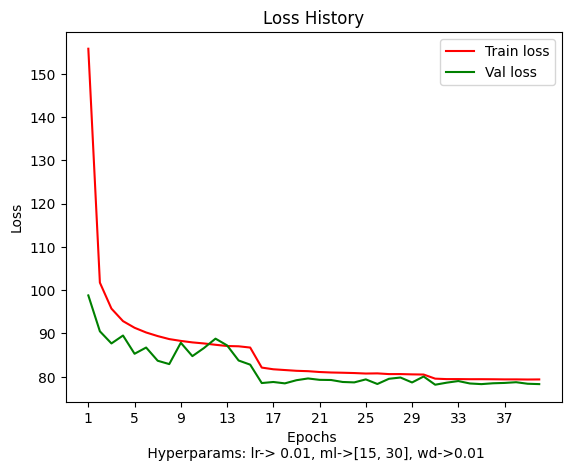

 94%|█████████▍| 17/18 [4:47:15<16:54, 1014.32s/it]

total number of parameters of the network is: 26859
[Epoch: 1, Iteration:     1]  training loss: 554.191
[Epoch: 1, Iteration:   201]  training loss: 153.971
[Epoch: 1, Iteration:   401]  training loss: 120.799
[Epoch: 1, Iteration:   601]  training loss: 104.024
[Epoch: 1, Iteration:     1]  validation loss: 105.205
[Epoch: 2, Iteration:     1]  training loss: 113.923
[Epoch: 2, Iteration:   201]  training loss: 106.672
[Epoch: 2, Iteration:   401]  training loss: 100.969
[Epoch: 2, Iteration:   601]  training loss: 102.205
[Epoch: 2, Iteration:     1]  validation loss: 87.703
[Epoch: 3, Iteration:     1]  training loss: 95.773
[Epoch: 3, Iteration:   201]  training loss: 99.770
[Epoch: 3, Iteration:   401]  training loss: 94.358
[Epoch: 3, Iteration:   601]  training loss: 93.537
[Epoch: 3, Iteration:     1]  validation loss: 87.292
[Epoch: 4, Iteration:     1]  training loss: 96.248
[Epoch: 4, Iteration:   201]  training loss: 93.901
[Epoch: 4, Iteration:   401]  training loss: 91.3

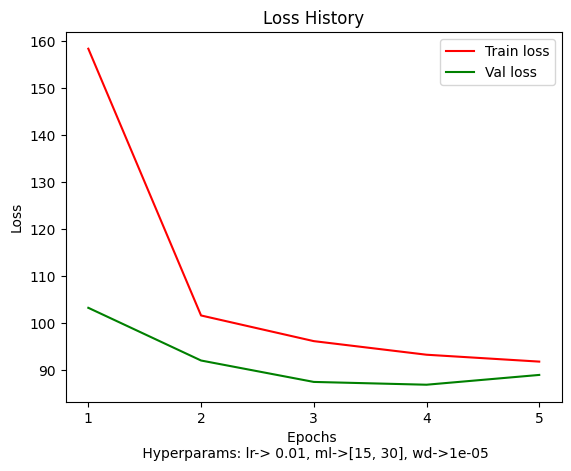

[Epoch: 6, Iteration:     1]  training loss: 96.814
[Epoch: 6, Iteration:   201]  training loss: 92.821
[Epoch: 6, Iteration:   401]  training loss: 90.510
[Epoch: 6, Iteration:   601]  training loss: 90.123
[Epoch: 6, Iteration:     1]  validation loss: 84.270
[Epoch: 7, Iteration:     1]  training loss: 87.000
[Epoch: 7, Iteration:   201]  training loss: 93.040
[Epoch: 7, Iteration:   401]  training loss: 90.212
[Epoch: 7, Iteration:   601]  training loss: 93.068
[Epoch: 7, Iteration:     1]  validation loss: 93.084
[Epoch: 8, Iteration:     1]  training loss: 88.701
[Epoch: 8, Iteration:   201]  training loss: 93.836
[Epoch: 8, Iteration:   401]  training loss: 86.100
[Epoch: 8, Iteration:   601]  training loss: 89.578
[Epoch: 8, Iteration:     1]  validation loss: 84.330
[Epoch: 9, Iteration:     1]  training loss: 87.816
[Epoch: 9, Iteration:   201]  training loss: 92.922
[Epoch: 9, Iteration:   401]  training loss: 85.016
[Epoch: 9, Iteration:   601]  training loss: 89.755
[Epoch

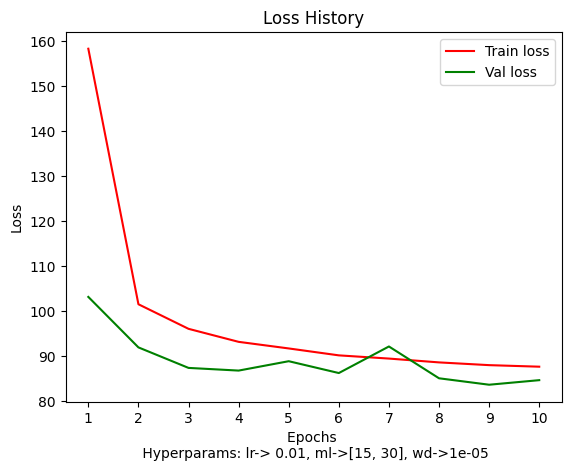

[Epoch: 11, Iteration:     1]  training loss: 85.903
[Epoch: 11, Iteration:   201]  training loss: 89.258
[Epoch: 11, Iteration:   401]  training loss: 90.512
[Epoch: 11, Iteration:   601]  training loss: 85.138
[Epoch: 11, Iteration:     1]  validation loss: 84.898
[Epoch: 12, Iteration:     1]  training loss: 88.407
[Epoch: 12, Iteration:   201]  training loss: 86.596
[Epoch: 12, Iteration:   401]  training loss: 84.855
[Epoch: 12, Iteration:   601]  training loss: 83.519
[Epoch: 12, Iteration:     1]  validation loss: 83.105
[Epoch: 13, Iteration:     1]  training loss: 87.243
[Epoch: 13, Iteration:   201]  training loss: 87.196
[Epoch: 13, Iteration:   401]  training loss: 87.047
[Epoch: 13, Iteration:   601]  training loss: 87.184
[Epoch: 13, Iteration:     1]  validation loss: 86.096
[Epoch: 14, Iteration:     1]  training loss: 87.442
[Epoch: 14, Iteration:   201]  training loss: 84.417
[Epoch: 14, Iteration:   401]  training loss: 88.021
[Epoch: 14, Iteration:   601]  training 

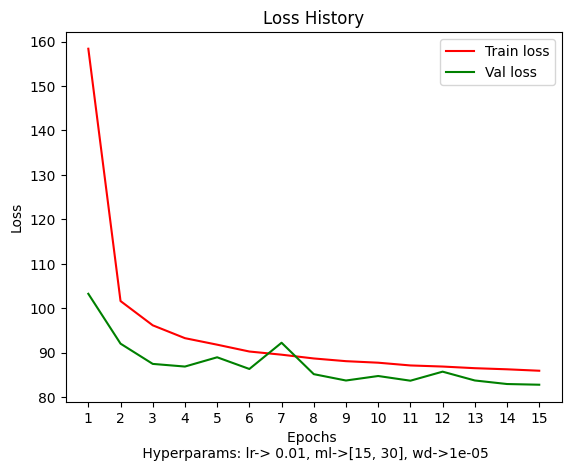

[Epoch: 16, Iteration:     1]  training loss: 90.835
[Epoch: 16, Iteration:   201]  training loss: 85.790
[Epoch: 16, Iteration:   401]  training loss: 81.043
[Epoch: 16, Iteration:   601]  training loss: 79.742
[Epoch: 16, Iteration:     1]  validation loss: 85.437
[Epoch: 17, Iteration:     1]  training loss: 76.994
[Epoch: 17, Iteration:   201]  training loss: 86.526
[Epoch: 17, Iteration:   401]  training loss: 84.602
[Epoch: 17, Iteration:   601]  training loss: 80.568
[Epoch: 17, Iteration:     1]  validation loss: 82.173
[Epoch: 18, Iteration:     1]  training loss: 82.963
[Epoch: 18, Iteration:   201]  training loss: 89.288
[Epoch: 18, Iteration:   401]  training loss: 82.686
[Epoch: 18, Iteration:   601]  training loss: 78.453
[Epoch: 18, Iteration:     1]  validation loss: 81.577
[Epoch: 19, Iteration:     1]  training loss: 85.148
[Epoch: 19, Iteration:   201]  training loss: 85.705
[Epoch: 19, Iteration:   401]  training loss: 84.702
[Epoch: 19, Iteration:   601]  training 

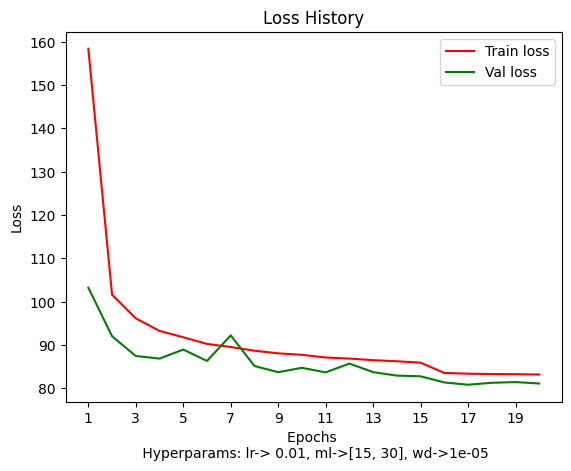

[Epoch: 21, Iteration:     1]  training loss: 82.234
[Epoch: 21, Iteration:   201]  training loss: 85.776
[Epoch: 21, Iteration:   401]  training loss: 84.791
[Epoch: 21, Iteration:   601]  training loss: 83.067
[Epoch: 21, Iteration:     1]  validation loss: 80.824
[Epoch: 22, Iteration:     1]  training loss: 81.823
[Epoch: 22, Iteration:   201]  training loss: 88.072
[Epoch: 22, Iteration:   401]  training loss: 76.640
[Epoch: 22, Iteration:   601]  training loss: 76.503
[Epoch: 22, Iteration:     1]  validation loss: 83.147
[Epoch: 23, Iteration:     1]  training loss: 83.173
[Epoch: 23, Iteration:   201]  training loss: 81.962
[Epoch: 23, Iteration:   401]  training loss: 85.998
[Epoch: 23, Iteration:   601]  training loss: 84.444
[Epoch: 23, Iteration:     1]  validation loss: 83.956
[Epoch: 24, Iteration:     1]  training loss: 89.610
[Epoch: 24, Iteration:   201]  training loss: 80.904
[Epoch: 24, Iteration:   401]  training loss: 80.007
[Epoch: 24, Iteration:   601]  training 

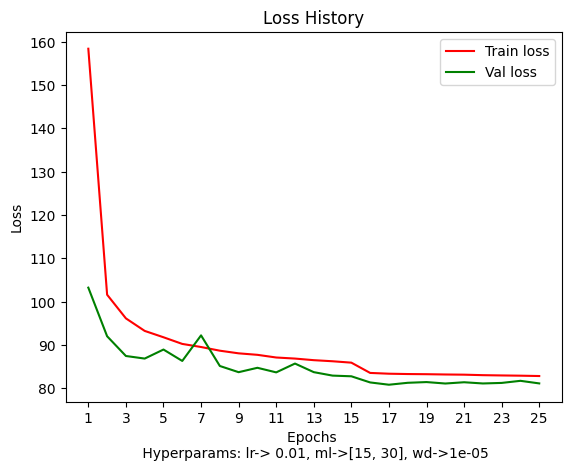

[Epoch: 26, Iteration:     1]  training loss: 80.422
[Epoch: 26, Iteration:   201]  training loss: 77.378
[Epoch: 26, Iteration:   401]  training loss: 83.452
[Epoch: 26, Iteration:   601]  training loss: 83.970
[Epoch: 26, Iteration:     1]  validation loss: 80.538
[Epoch: 27, Iteration:     1]  training loss: 81.212
[Epoch: 27, Iteration:   201]  training loss: 80.307
[Epoch: 27, Iteration:   401]  training loss: 84.831
[Epoch: 27, Iteration:   601]  training loss: 80.839
[Epoch: 27, Iteration:     1]  validation loss: 81.661
[Epoch: 28, Iteration:     1]  training loss: 79.619
[Epoch: 28, Iteration:   201]  training loss: 81.491
[Epoch: 28, Iteration:   401]  training loss: 88.563
[Epoch: 28, Iteration:   601]  training loss: 82.747
[Epoch: 28, Iteration:     1]  validation loss: 77.242
[Epoch: 29, Iteration:     1]  training loss: 84.102
[Epoch: 29, Iteration:   201]  training loss: 80.166
[Epoch: 29, Iteration:   401]  training loss: 77.917
[Epoch: 29, Iteration:   601]  training 

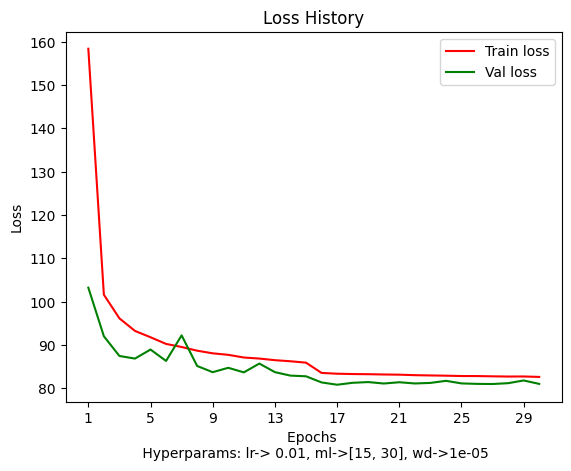

[Epoch: 31, Iteration:     1]  training loss: 82.179
[Epoch: 31, Iteration:   201]  training loss: 82.345
[Epoch: 31, Iteration:   401]  training loss: 79.682
[Epoch: 31, Iteration:   601]  training loss: 85.404
[Epoch: 31, Iteration:     1]  validation loss: 81.831
[Epoch: 32, Iteration:     1]  training loss: 79.936
[Epoch: 32, Iteration:   201]  training loss: 77.752
[Epoch: 32, Iteration:   401]  training loss: 85.743
[Epoch: 32, Iteration:   601]  training loss: 86.447
[Epoch: 32, Iteration:     1]  validation loss: 83.427
[Epoch: 33, Iteration:     1]  training loss: 81.364
[Epoch: 33, Iteration:   201]  training loss: 84.064
[Epoch: 33, Iteration:   401]  training loss: 80.737
[Epoch: 33, Iteration:   601]  training loss: 83.636
[Epoch: 33, Iteration:     1]  validation loss: 81.109
[Epoch: 34, Iteration:     1]  training loss: 82.378
[Epoch: 34, Iteration:   201]  training loss: 81.998
[Epoch: 34, Iteration:   401]  training loss: 82.366
[Epoch: 34, Iteration:   601]  training 

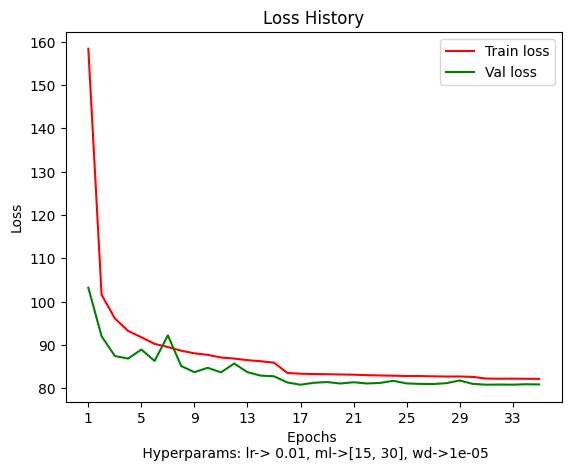

[Epoch: 36, Iteration:     1]  training loss: 81.804
[Epoch: 36, Iteration:   201]  training loss: 84.053
[Epoch: 36, Iteration:   401]  training loss: 88.947
[Epoch: 36, Iteration:   601]  training loss: 74.824
[Epoch: 36, Iteration:     1]  validation loss: 81.730
[Epoch: 37, Iteration:     1]  training loss: 79.626
[Epoch: 37, Iteration:   201]  training loss: 80.181
[Epoch: 37, Iteration:   401]  training loss: 79.618
[Epoch: 37, Iteration:   601]  training loss: 78.368
[Epoch: 37, Iteration:     1]  validation loss: 82.779
[Epoch: 38, Iteration:     1]  training loss: 81.219
[Epoch: 38, Iteration:   201]  training loss: 84.808
[Epoch: 38, Iteration:   401]  training loss: 85.511
[Epoch: 38, Iteration:   601]  training loss: 76.219
[Epoch: 38, Iteration:     1]  validation loss: 82.544
[Epoch: 39, Iteration:     1]  training loss: 75.373
[Epoch: 39, Iteration:   201]  training loss: 81.934
[Epoch: 39, Iteration:   401]  training loss: 87.015
[Epoch: 39, Iteration:   601]  training 

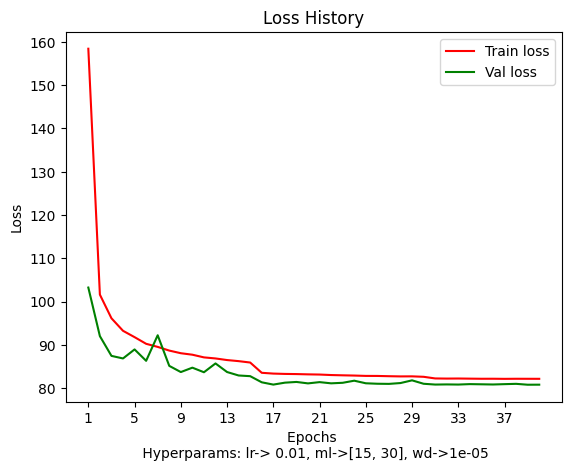

100%|██████████| 18/18 [5:02:40<00:00, 1008.92s/it]

Best validation loss reached: 77.60003662109375
Best hyperparameters: (0.1, [15, 30], 1e-05)


In [11]:
learning_rates = [1e-1, 1e-2]
milestones = [[10, 25, 30], [15, 25, 35], [15, 30]]
weight_decays = [0, 1e-2, 1e-5]

all_hp_combinations = [(lr, ml, wd) for lr in learning_rates for ml in milestones for wd in weight_decays]

best_validation_loss = float('inf')
best_hyperparameters = None

path_to_save_model = './HyperparamsTuning/models'
path_to_save_plots = './HyperparamsTuning/plots'

# Creation of a folder where to save plots
if path.exists("./HyperparamsTuning/") == False:
    os.mkdir("./HyperparamsTuning/")

for lr, ml, wd in tqdm(all_hp_combinations):
    model = instantiate_model() # All default model parameters are chosen
    training_losses, validation_losses = train(model, data_loader, vald_loader, lr, ml, wd, gamma=0.1, use_scheduler=True, save_and_plot=True, path_to_save_model=path_to_save_model, path_to_save_plots=path_to_save_plots)

    # Calculate the minimum validation loss
    min_validation_loss = min(validation_losses)

    if min_validation_loss < best_validation_loss:
        best_validation_loss = min_validation_loss
        best_hyperparameters = (lr, ml, wd)

print(f"Best validation loss reached: {best_validation_loss}")
print(f"Best hyperparameters: {best_hyperparameters}")